<a href="https://colab.research.google.com/github/sebatlab/Antaki2021/blob/main/Antaki2021_figures.2022_06_13_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import statsmodels.stats.multitest
from statsmodels.stats.contingency_tables import Table2x2
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import re

%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

# Figure parameters
SMALL = 20
MEDIUM = 25
BIG = 30
MASSIVE = 60
YLABEL_PAD = 25.0
FIGSIZE_DEFAULT = (26, 16)
LINEWIDTH = 5

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Figure 1a

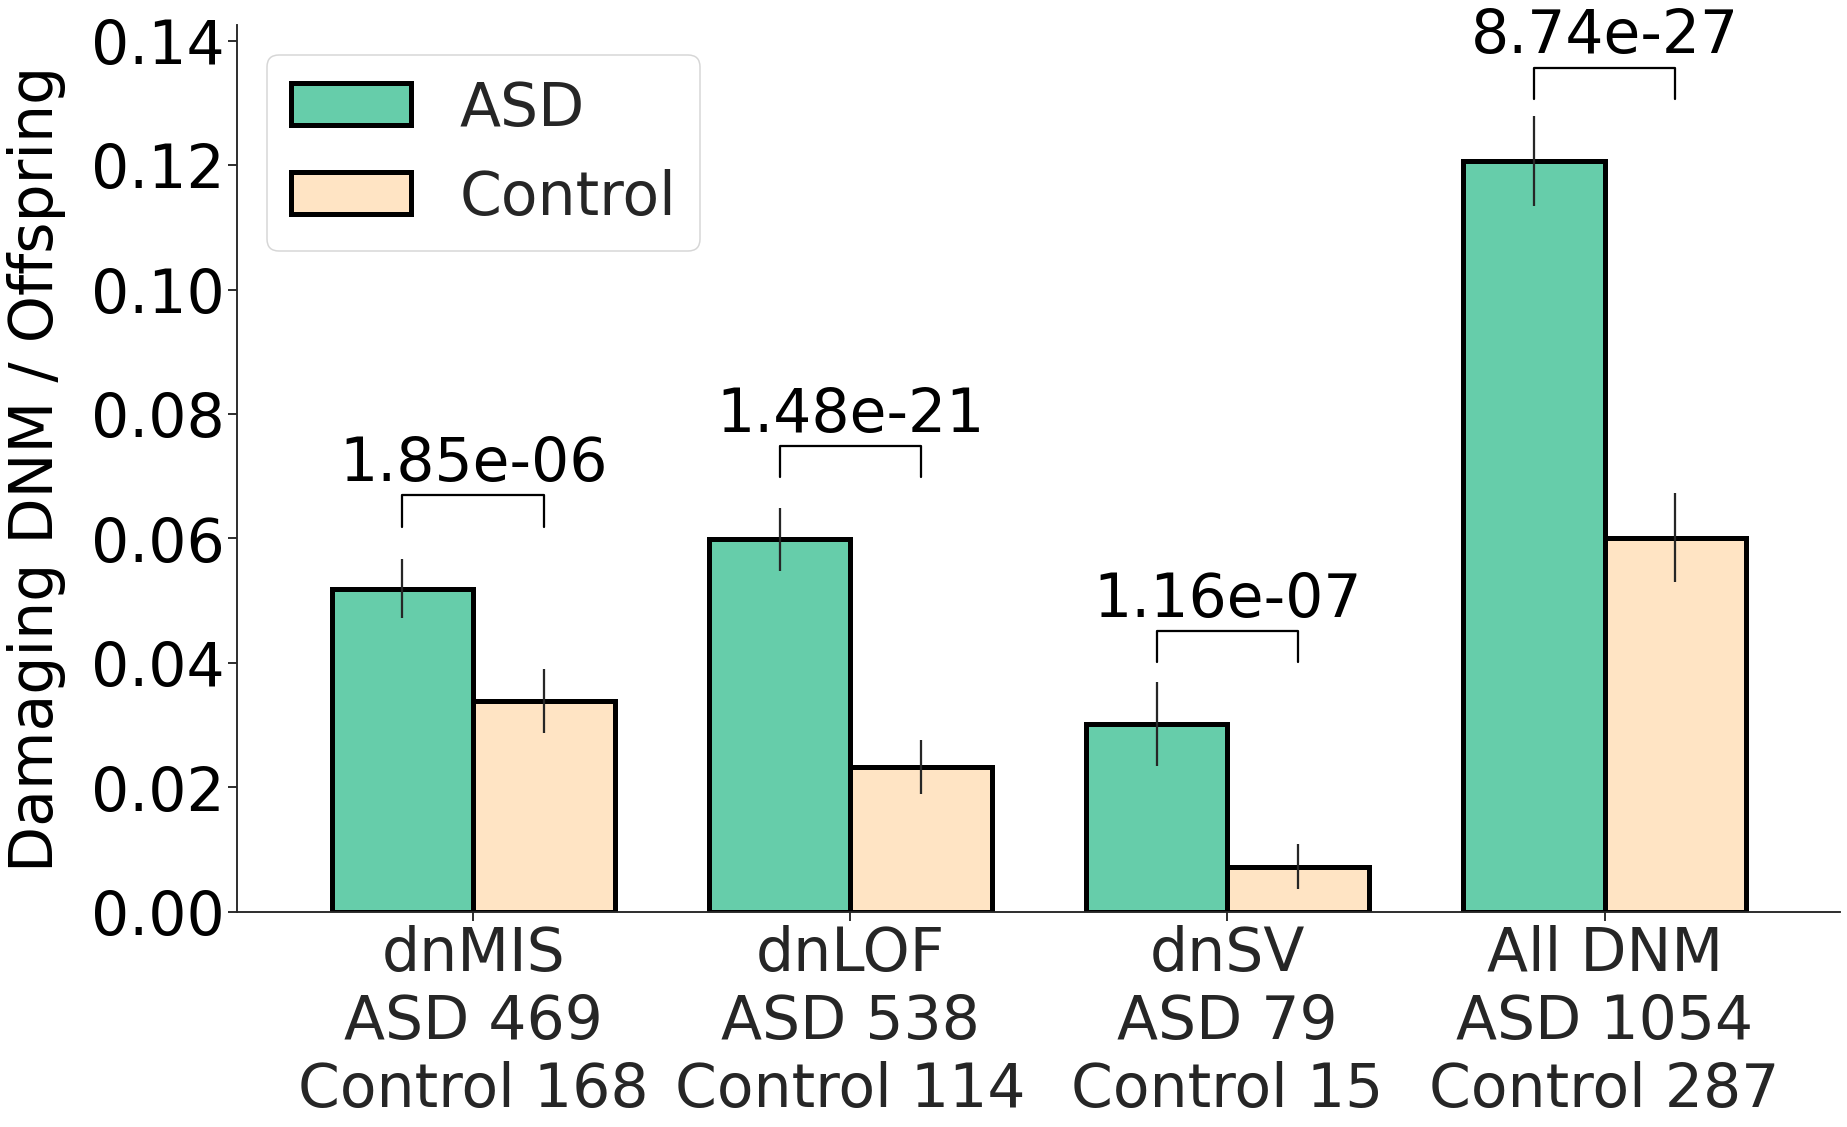

In [ ]:
# Figure 1A

""" Analysis """
def make_df(df, col, cohort = None):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]
  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["Cohort", "DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])
  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])

# Make dataframes for each of the de novo columns
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep = ",")

df['All DNM'] = df['dnLOF'] + df['dnMIS'] + df['dnSV'].fillna(0)
# cols = ['dnMIS','dnLOF','dnSV','dnAll'] 
df_dnmis = make_df(df, col = "dnMIS")
df_dnlof = make_df(df, col = "dnLOF")
df_dnsv  = make_df(df, col = "dnSV")
df_dnall = make_df(df, col = "All DNM")

# Concatenate the dataframes
df_dn = pd.concat([df_dnmis, df_dnlof, df_dnsv, df_dnall])


""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.75
df_dn.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_dn[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax,
    xlabel = ""
)

legend = ax.legend(loc = 2, fontsize = MASSIVE)

df_dn_labels = df_dn["DNMs"].astype(str) + "\n" + "ASD" + " " + df_dn["ASD Samples"].astype(str) + "\n" + "Control" + " " + df_dn["Control Samples"].astype(str)

ax.set_xticklabels(df_dn_labels, rotation = 0, fontsize = MASSIVE)
ax.set_ylabel("Damaging DNM / Offspring", fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")
plt.yticks(fontsize = MASSIVE, color = "black")

# Plot p-values
def plot_pvals(ax, index, pval, line_buffer = 0, text_buffer = 0):
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk = "***"
  elif pval < 0.01: pval_asterisk = "**"
  elif pval < 0.05: pval_asterisk = "*"

  # Properties of the bar
  width = ax.patches[index].get_width()
  x_start = ax.patches[index].xy[0]
  x_end   = x_start + width
  height  = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  x_left  = midpoint
  x_right = midpoint + width
  y_bottom = height + line_buffer
  y_top    = height + line_buffer + 0.005

  # Plotting p-value line segments
  ax.plot([x_left, x_left, x_right, x_right],
          [y_bottom, y_top, y_top, y_bottom], color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE, color = "black")


plot_pvals(ax, index = 0, pval = df_dn["P-value"].values[0], line_buffer = 0.01, text_buffer = 0.02)
plot_pvals(ax, index = 1, pval = df_dn["P-value"].values[1], line_buffer = 0.01, text_buffer = 0.02)
plot_pvals(ax, index = 2, pval = df_dn["P-value"].values[2], line_buffer = 0.01, text_buffer = 0.02)
plot_pvals(ax, index = 3, pval = df_dn["P-value"].values[3], line_buffer = 0.01, text_buffer = 0.02)


sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig1a.png", bbox_inches = "tight")
f.savefig("fig1a.svg", bbox_inches = "tight")
f.savefig("fig1a.pdf", bbox_inches = "tight")


""" Make supplementary table """
df["dnLOF_dnSV"] = df['dnLOF'] + df['dnSV'].fillna(0)
df_dnlof_snv_indel_sv = make_df(df, col = "dnLOF_dnSV")
df_dn = pd.concat([df_dn, df_dnlof_snv_indel_sv]).reset_index(drop = True)
df_dn = df_dn.reindex([0, 1, 2, 4, 3]).reset_index(drop = True)
df_dn["DNMs"] = df_dn["DNMs"].replace({
    "dnMIS": "De Novo Missense",
    "dnLOF": "De Novo SNV/INDEL LoF",
    "dnSV": "De Novo SV LoF",
    "dnLOF_dnSV": "De Novo LoF",
    "All DNM": "De Novo All",
})

df_dn.to_csv("SupplementaryTable2.Figure1A.csv", index = False)

# Figure 1b

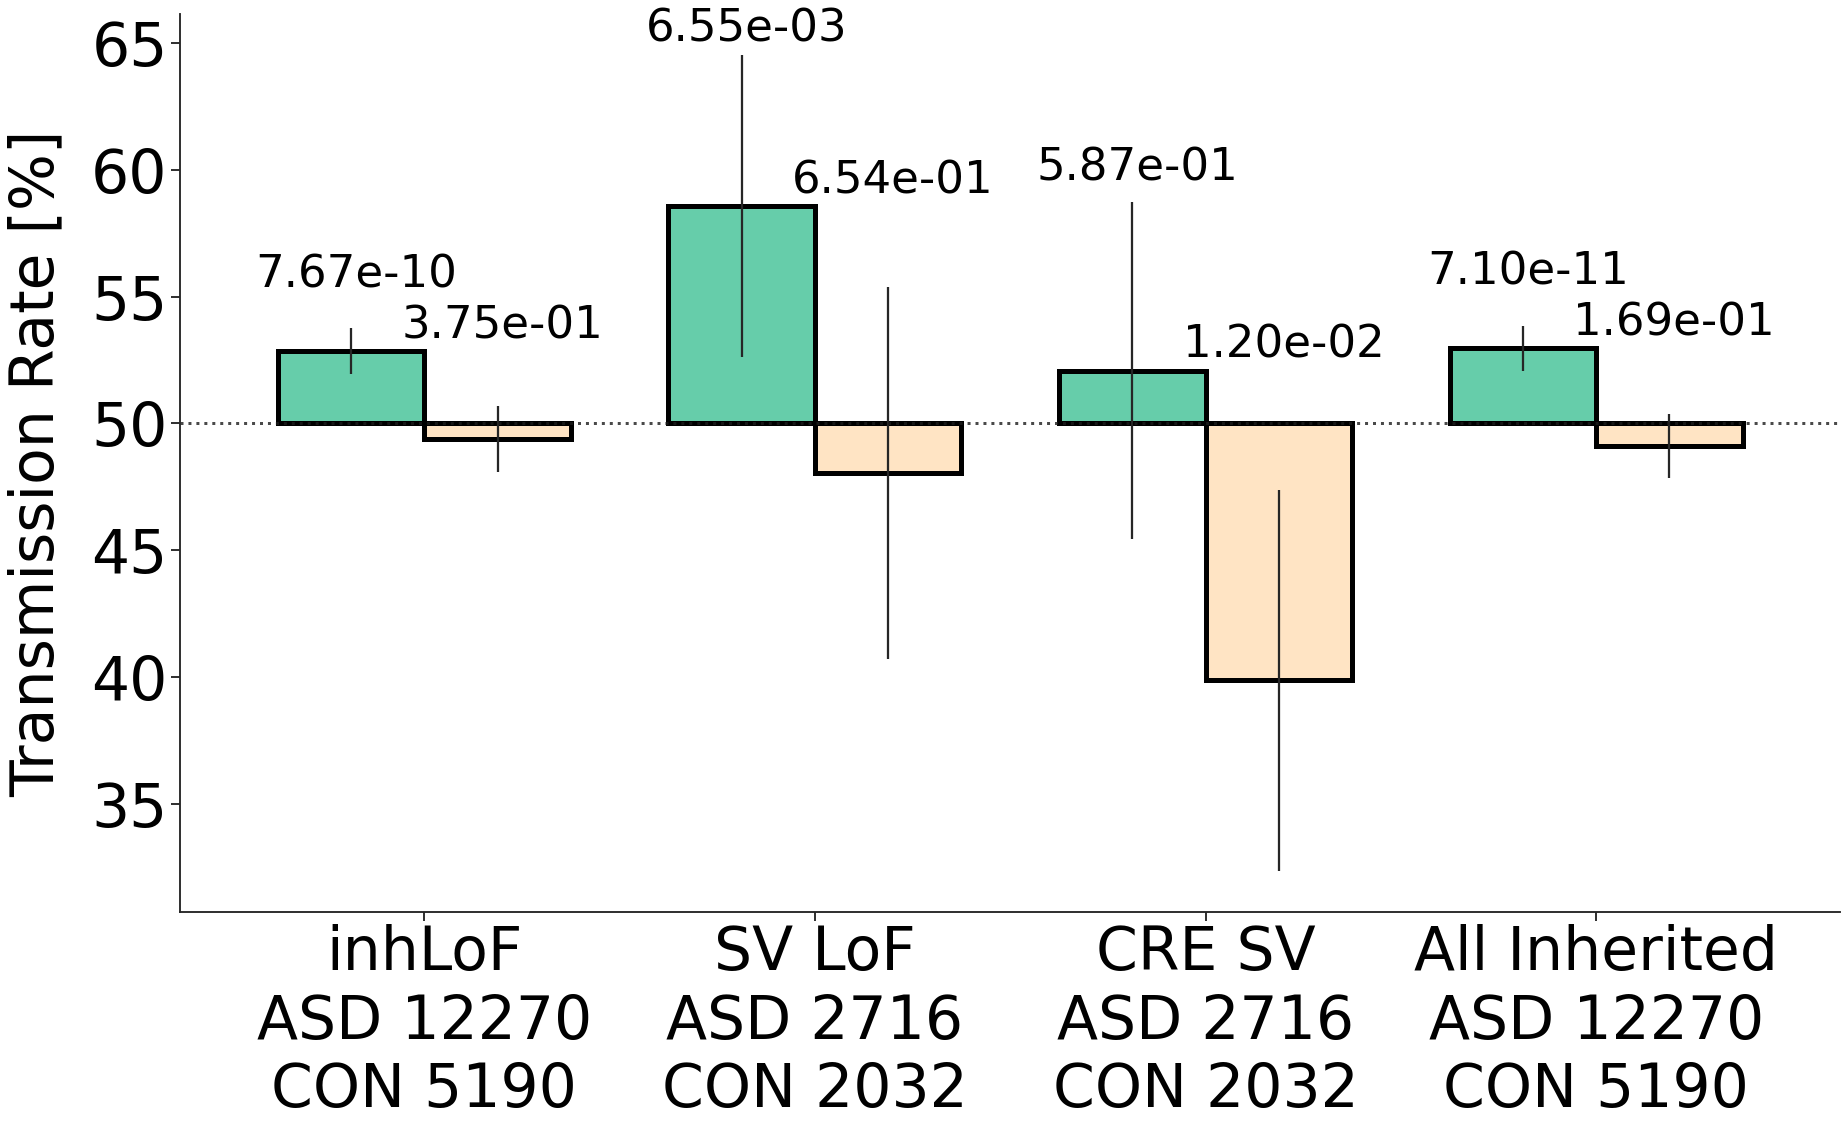

In [ ]:
# Figure 1B
""" Analysis """
df = pd.read_csv("all_t1burden_tdt_results.tsv",sep="\t")
groups = ['snv_indel_lof', 'sv_lof', 'cresv', 'combined_lof_cre']
df = df[df["group_id"].isin(groups)].reset_index(drop = True)
df = df[["group_id", "aff_trate", "aff_tci", "aff_tpval", "n_asd_tot", "con_trate", "con_tci", "con_tpval", "n_con_tot", "tot_chisq"]]
# Reindex to get this order: inhLoF, SV LoF, CRE SV, All Inherited
df = df.reindex([2, 1, 0, 3]).reset_index(drop = True)
df["group_id"] = df["group_id"].replace({
    "snv_indel_lof": "inhLoF",
    "sv_lof": "SV LoF",
    "cresv": "CRE SV",
    "combined_lof_cre": "All Inherited",
})


""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

df["aff_trate_height"] = (df["aff_trate"] - 0.5)
df["con_trate_height"] = (df["con_trate"] - 0.5)

# df["aff_tci_yerr"] = df["aff_tci"]*100
# df["con_tci_yerr"] = df["con_tci"]*100

f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.75
df.plot.bar(
    x = "group_id",
    y = ["aff_trate_height", "con_trate_height"],
    yerr = df[["aff_tci", "con_tci"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax,
    xlabel = "",
    legend = None
)

df_labels = df["group_id"].astype(str) + "\n" + "ASD" + " " + df["n_asd_tot"].astype(str) + "\n" + "CON" + " " + df["n_con_tot"].astype(str)

ax.set_xticklabels(df_labels, rotation = 0, fontsize = MASSIVE)
ax.set_ylabel('Transmission Rate [%]', fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")
plt.yticks(fontsize = MASSIVE, color = "black")

ytick_step = 5
rng = 20
ax.set_yticklabels([x for x in range(50 - rng, 50 + rng + ytick_step, ytick_step)])
# # Make new yticklabels_list (Convert to percentage and turn 0 to 0.5) (DOESN'T WORK)
# from decimal import Decimal
# import re
# yticklabels_new = []
# for text_obj in ax.get_yticklabels(): # ax.get_yticklabels() is a list object
#   tmp = text_obj.get_text()
#   tmp = re.sub(r'[^\x00-\x7F]+','-', tmp)
#   new_val = Decimal(tmp)*100 + 50
#   yticklabels_new.append(new_val)
# ax.set_yticklabels(yticklabels_new)

xmin, xmax = ax.set_xlim()
ax.hlines(y = 0, xmin = xmin, xmax = xmax, alpha = 0.8, color = '#1c1c1c', linestyle = ':',linewidth=3)
ax.set_axisbelow(True)

# Plot p-values
def plot_pvals_1sample(ax, index, pval, x_pos = "x_start", text_buffer = 0):
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk = "***"
  elif pval < 0.01: pval_asterisk = "**"
  elif pval < 0.05: pval_asterisk = "*"

  # Properties of the bar
  width = ax.patches[index].get_width()
  x_start = ax.patches[index].xy[0]
  x_end   = x_start + width
  height  = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  # Show p-value
  if x_pos == "x_start":
    ax.text(x = x_start + 0.2, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE - 15, color = "black")
  elif x_pos == "x_end":
    ax.text(x = x_end + 0.2, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE - 15, color = "black")

plot_pvals_1sample(ax, index = 0, pval = df["aff_tpval"].values[0], x_pos = "x_start", text_buffer = 0.03)
plot_pvals_1sample(ax, index = 0, pval = df["con_tpval"].values[0], x_pos = "x_end", text_buffer = 0.01)
plot_pvals_1sample(ax, index = 1, pval = df["aff_tpval"].values[1], x_pos = "x_start", text_buffer = 0.07)
plot_pvals_1sample(ax, index = 1, pval = df["con_tpval"].values[1], x_pos = "x_end", text_buffer = 0.01)
plot_pvals_1sample(ax, index = 2, pval = df["aff_tpval"].values[2], x_pos = "x_start", text_buffer = 0.08)
plot_pvals_1sample(ax, index = 2, pval = df["con_tpval"].values[2], x_pos = "x_end", text_buffer = 0.01)
plot_pvals_1sample(ax, index = 3, pval = df["aff_tpval"].values[3], x_pos = "x_start", text_buffer = 0.03)
plot_pvals_1sample(ax, index = 3, pval = df["con_tpval"].values[3], x_pos = "x_end", text_buffer = 0.01)

sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig1b.png", bbox_inches = "tight")
f.savefig("fig1b.pdf", bbox_inches = "tight")
f.savefig("fig1b.svg", bbox_inches = "tight")

""" Make supplementary table """
# The supplementary table is basically this input table, but with this ordering:
# group_id n_asd	n_con	case_pt	case_pn	case_mt	case_mn	case_rate	case_ci	case_pval	con_pt	con_pn	con_mt	con_mn	con_rate	con_ci	con_pval	odds	odds_lo	odds_hi
df = pd.read_csv("all_t1burden_tdt_results.tsv",sep="\t")
groups = ['snv_indel_lof', 'sv_lof', 'cresv', 'combined_lof_cre']
df = df[df["group_id"].isin(groups)].reset_index(drop = True)
df = df[["group_id", "n_asd_tot", "n_con_tot", 
    "aff_pt", "aff_pn", "aff_mt", "aff_mn", "aff_trate", "aff_tci", "aff_tpval",
    "con_pt", "con_pn", "con_mt", "con_mn", "con_trate", "con_tci", "con_tpval", 
    "tot_odds", "tot_odds_lo", "tot_odds_hi"]]
df = df.rename(columns = lambda x: re.sub("aff", "case", x))
df = df.rename(columns = {"n_asd_tot": "n_asd",
                          "n_con_tot": "n_con",
                          "case_trate": "case_rate",
                          "case_tci": "case_ci",
                          "case_tpval": "case_pval",
                          "con_trate": "con_rate",
                          "con_tci": "con_ci",
                          "con_tpval": "con_pval",
                          "tot_odds": "odds",
                          "tot_odds_lo": "odds_lo",
                          "tot_odds_hi": "odds_hi"})

df.to_csv("SupplementaryTable3.Figure1B.csv", index = False)

# Figure 1c

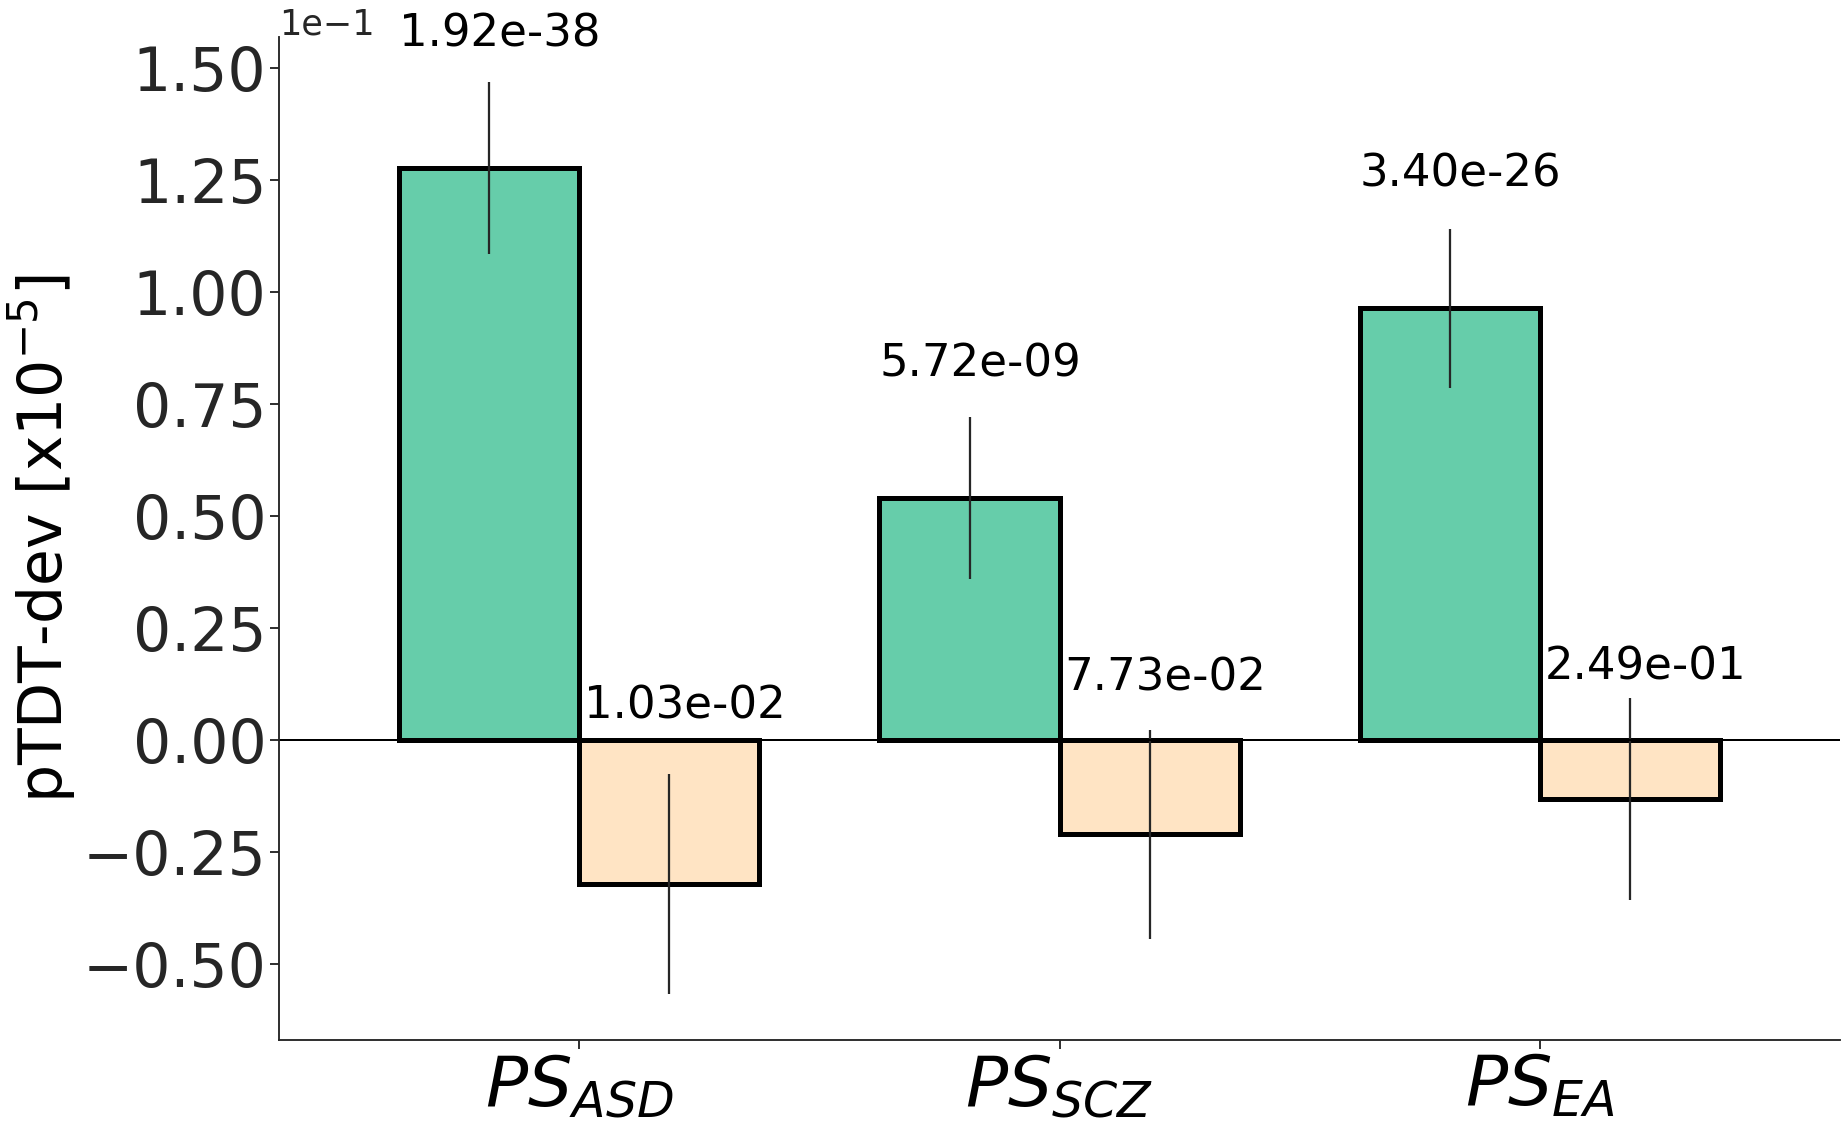

In [ ]:
# Figure 1C
""" Analysis """
def make_df(df, col, cohort = None):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]
  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Not applicable to pTDT PRS
  # # Get number of cases and controls with more than 0 of specified column
  # num_cas = cas[cas[col] > 0].shape[0]
  # num_ctl = ctl[ctl[col] > 0].shape[0]
  # # Sum column value
  # cas_sum = sum(cas[col])
  # ctl_sum = sum(ctl[col])
  # # Frequency
  # cas_freq = cas_sum/cas.shape[0]
  # ctl_freq = ctl_sum/ctl.shape[0]

  # p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]
    
  num_cas = cas.shape[0]
  num_ctl = ctl.shape[0]

  cas_p_val_1s = scipy.stats.ttest_1samp(cas[col], popmean = 0)[1]
  ctl_p_val_1s = scipy.stats.ttest_1samp(ctl[col], popmean = 0)[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_p_val_1s, ctl_mean, ctl_ci, num_ctl, ctl_p_val_1s]], columns = ["Cohort, ""PS", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD P-value", "Control Mean", "Control 95% CI", "Control Samples", "Control P-value"])

  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_p_val_1s, ctl_mean, ctl_ci, num_ctl, ctl_p_val_1s]], columns = ["PS", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD P-value", "Control Mean", "Control 95% CI", "Control Samples", "Control P-value"])

df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[df["EUR Ancestry"] == 1]
cols = ['pTDT ASD Dev', 'pTDT SCZ Dev', 'pTDT EA Dev']

# Make dataframes for each of the pTDT (PRS) columns
df_ptdt_asd = make_df(df, col = "pTDT ASD Dev")
df_ptdt_scz = make_df(df, col = "pTDT SCZ Dev")
df_ptdt_edu = make_df(df, col = "pTDT EA Dev")

# Concatenate the dataframes
df_ptdt = pd.concat([df_ptdt_asd, df_ptdt_scz, df_ptdt_edu]).reset_index(drop = True)

""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.75
df_ptdt.plot.bar(
    x = "PS",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_ptdt[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax,
    xlabel = "",
    legend = None
)

ax.set_xticklabels(['$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$'], rotation = 0, fontsize = MASSIVE)
ax.set_ylabel('pTDT-dev [x10$^{-5}$]', fontsize = MASSIVE, color = "black")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(BIG + 5)
ax.axhline(linewidth = 2, color = 'black')

plt.xticks(fontsize = MASSIVE + 10, color = "black")
plt.yticks(fontsize = MASSIVE)

# Plot p-values
def plot_pvals_1sample(ax, index, pval, x_pos = "x_start", text_buffer = 0):
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk = "***"
  elif pval < 0.01: pval_asterisk = "**"
  elif pval < 0.05: pval_asterisk = "*"

  # Properties of the bar
  width = ax.patches[index].get_width()
  x_start = ax.patches[index].xy[0]
  x_end   = x_start + width
  height  = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  # Show p-value
  if x_pos == "x_start":
    ax.text(x = x_start + 0.21, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE - 15, color = "black")
  elif x_pos == "x_end":
    ax.text(x = x_end + 0.22, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE - 15, color = "black")

plot_pvals_1sample(ax, index = 0, pval = df_ptdt["ASD P-value"].values[0], x_pos = "x_start", text_buffer = 0.03)
plot_pvals_1sample(ax, index = 0, pval = df_ptdt["Control P-value"].values[0], x_pos = "x_end", text_buffer = -0.12)
plot_pvals_1sample(ax, index = 1, pval = df_ptdt["ASD P-value"].values[1], x_pos = "x_start", text_buffer = 0.03)
plot_pvals_1sample(ax, index = 1, pval = df_ptdt["Control P-value"].values[1], x_pos = "x_end", text_buffer = -0.04)
plot_pvals_1sample(ax, index = 2, pval = df_ptdt["ASD P-value"].values[2], x_pos = "x_start", text_buffer = 0.03)
plot_pvals_1sample(ax, index = 2, pval = df_ptdt["Control P-value"].values[2], x_pos = "x_end", text_buffer = -0.08)


sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig1c.png", bbox_inches = "tight")
f.savefig("fig1c.svg", bbox_inches = "tight")
f.savefig("fig1c.pdf", bbox_inches = "tight")


""" Make supplementary table """
df_ptdt["PS"] = df_ptdt["PS"].replace({
    "pTDT ASD Dev": "PS ASD Child-Midparent",
    "pTDT SCZ Dev": "PS SCZ Child-Midparent",
    "pTDT EA Dev": "PS EA Child-Midparent",
})

df_ptdt.to_csv("SupplementaryTable4.Figure1C.csv", index = False)

# Figure 2a

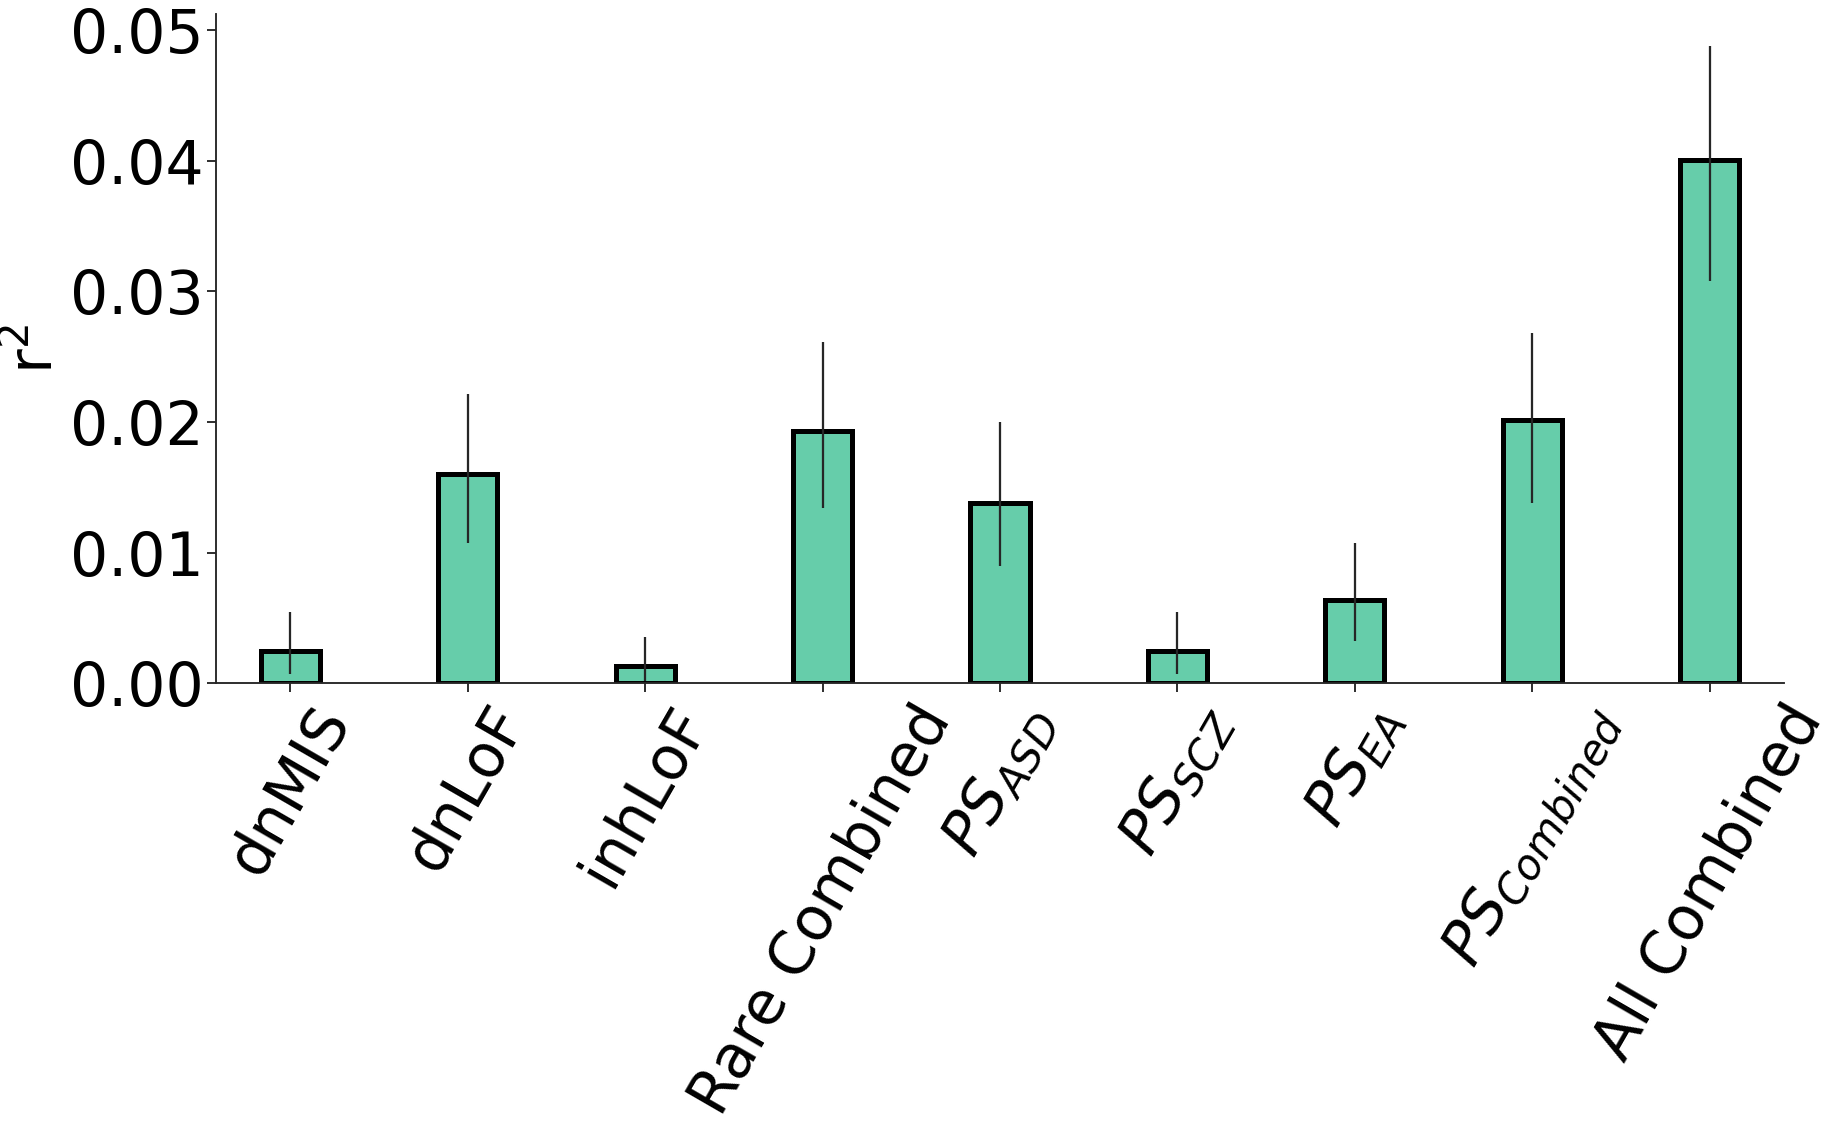

In [ ]:
# Figure 2A
""" Analysis """
df = pd.read_csv("/content/r2_table.csv", sep = ",")
# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand = True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})
# To get the error bars, Danny uses the upper confidence interval value (shortcut?)
df['ci'] = df['ci_upper'] - df['nagelkerke_R2_val']
df["ci_lower_adj"] = df["nagelkerke_R2_val"] - df["ci_lower"]
df["ci_upper_adj"] = df["ci_upper"] - df["nagelkerke_R2_val"]
df = df[df["Sex"] == "Female & Male"].reset_index(drop = True)
df = df.reindex([1, 0, 3, 8, 5, 7, 6, 4, 2]).reset_index(drop = True)


""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

# I have to do this to plot the asymmetric confidence intervals
ci_lower_upper = df[['ci_lower_adj', 'ci_upper_adj']].apply(tuple, axis = 1).tolist()
ci_lower_upper = np.array(ci_lower_upper).T.tolist()

f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

width = 1/3
df.plot.bar(
    x = "R2_type",
    y = "nagelkerke_R2_val",
    yerr = ci_lower_upper,
    color = 'mediumaquamarine',
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax,
    xlabel = "",
    legend = None
)

ax.set_ylabel('r$^2$', fontsize = MASSIVE, color = "black")
xlabs = [
    'dnMIS','dnLoF','inhLoF','Rare Combined',
    '$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$',
    '$PS_{Combined}$',
    'All Combined'
]
ax.set_xticklabels(xlabs, rotation = 60)

plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")

sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig2a.png", bbox_inches = "tight")
f.savefig("fig2a.svg", bbox_inches = "tight")
f.savefig("fig2a.pdf", bbox_inches = "tight")

""" Make supplementary table """
df = df[["R2_type", "nagelkerke_R2_val", "ci_lower", "ci_upper", "lr_p_val", "ste"]]
df = df.rename(columns = {"R2_type": "Model",
                          "nagelkerke_R2_val": "r2",
                          "ci_lower": "Lower 95% CI",
                          "ci_upper": "Upper 95% CI",
                          "lr_p_val": "P-Value",
                          "ste": "Standard Error"})
df["Model"] = df["Model"].replace({
    "combined": "All Combined",
    "prs": "PS Combined",
    "rare": "Rare Combined",
    "ptdt.asd.dev": "PS ASD",
    "ptdt.ea.dev": "PS EA",
    "ptdt.scz.dev": "PS SCZ",
    "dnMIS": "dnMis",
    "dnLOF": "dnLoF",
    "inhLOF": "inhLoF"
})

df.to_csv("SupplementaryTable5.Figure2A.csv", index = False)

# Figure 2b

9.13631141396819
10.56581854574864


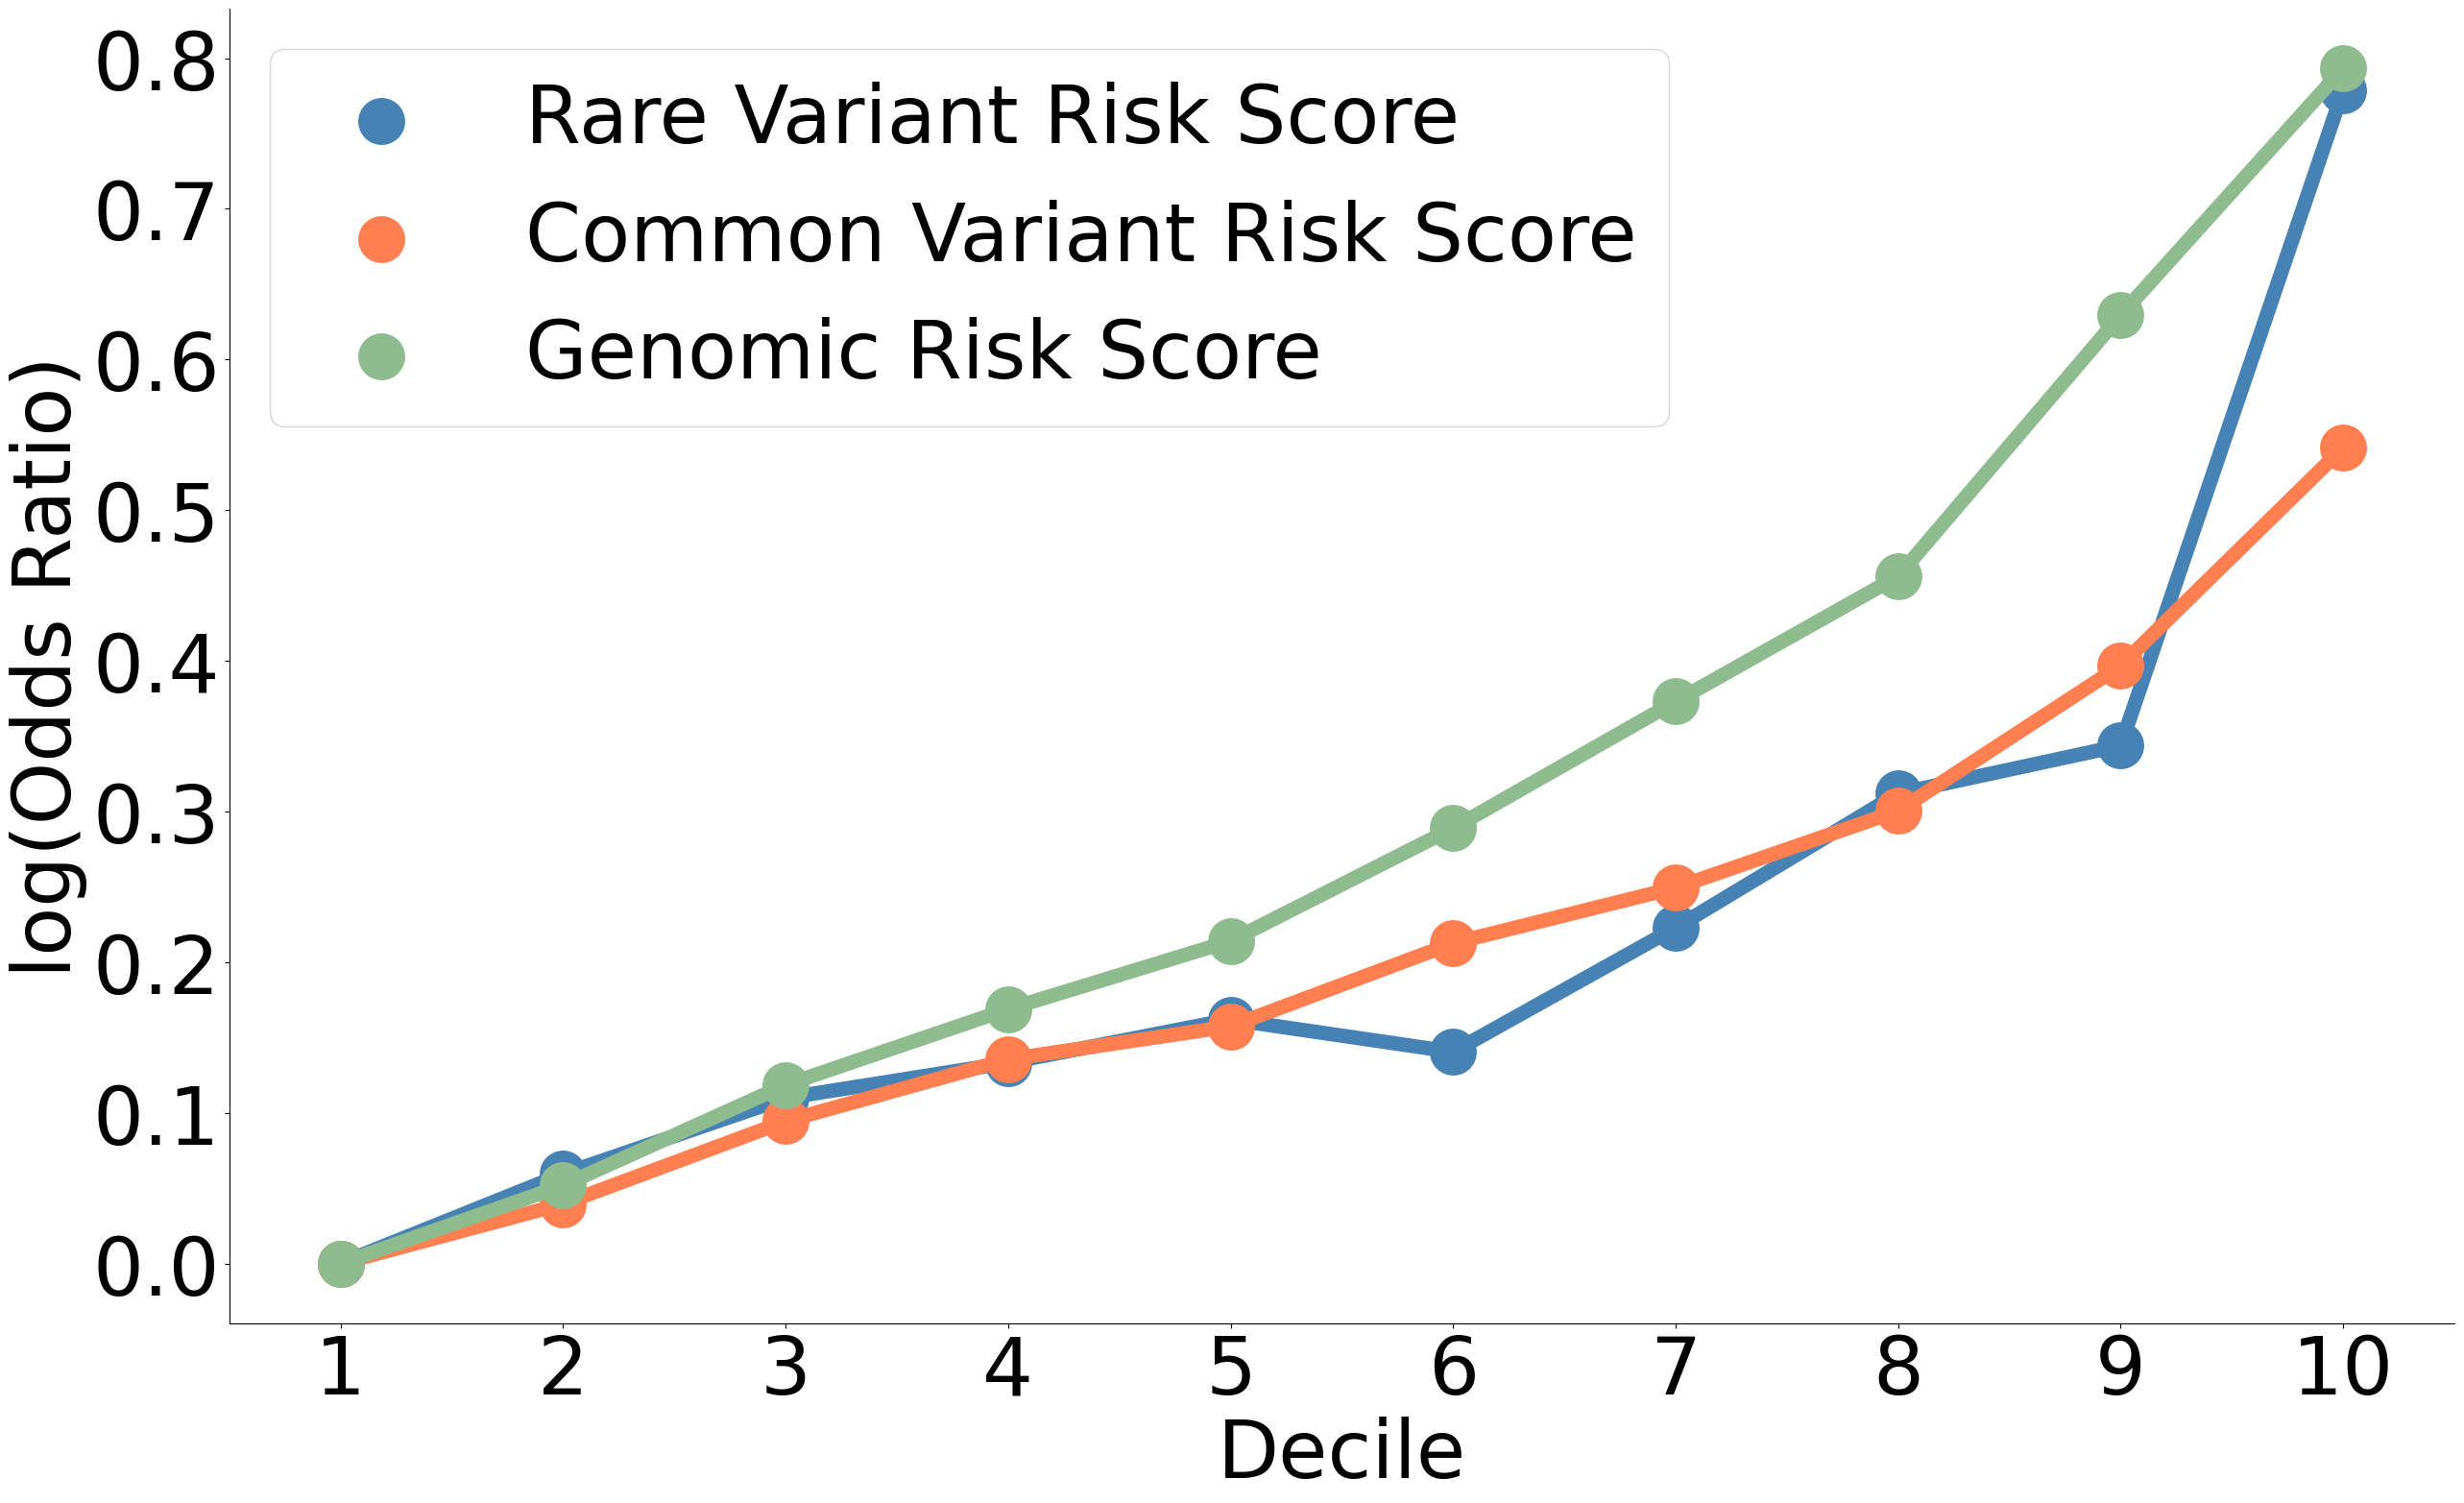

In [ ]:
# Figure 2B
""" Analysis """
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")
df = df.dropna(subset=["GRS", "PRS", "RVRS"])
df['Sex'] = df['Sex'].replace({0: 'Male', 1: 'Female'})
df['Phenotype'] = df['Phenotype'].replace({0: 'Control', 1: 'ASD'})

def response_or(df, col):
  """
                    asd   |  con
      at thres    | a     |   b
      below thres | c     |   d
      
      OR = a/c / b/d
  """
  results = []
  for x in range(1, 11):
    a = len(df[(df["Phenotype"] == "ASD")     & (df[col] >= x)])
    b = len(df[(df["Phenotype"] == "Control") & (df[col] >= x)])
    c = len(df[df["Phenotype"] == "ASD"])
    d = len(df[df["Phenotype"] == "Control"])

    # Make a 2x2 contigency table
    table = Table2x2([[a, b], [c, d]], shift_zeros = True)
    c_, p, dof, expected = chi2_contingency([[a, b], [c, d]])
    lo, hi = table.oddsratio_confint()
    results.append([col, x, table.oddsratio, lo, hi, p, a, b, c, d])
  return pd.DataFrame.from_records(results, columns=['Risk score', 'Decile', 'Odds Ratio', 'Odds Ratio Lower 95% CI', 'Odds Ratio Upper 95% CI', 'ChiSq P-Value', 'Cases > Decile Threshold', 'Controls > Decile Threshold', 'Cases Total', 'Controls Total'])

df["Genomic Risk Score"] = pd.qcut(df["GRS"], q = 10, labels = [x for x in range(1, 11)])
df_co = response_or(df, col = "Genomic Risk Score")
df["Common Variant Risk Score"] = pd.qcut(df["PRS"], q = 10, labels = [x for x in range(1, 11)])
df_ps = response_or(df, col = "Common Variant Risk Score")
df["Rare Variant Risk Score"] = pd.qcut(df["RVRS"], q = 10, labels = [x for x in range(1, 11)])
df_ra = response_or(df, col = "Rare Variant Risk Score")

df_risk_deciles = pd.concat([df_co, df_ps, df_ra]).reset_index(drop = True)
df_risk_deciles["log(Odds Ratio)"] = np.log(df_risk_deciles["Odds Ratio"])

""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

sns.pointplot(
    x = 'Decile',
    y = 'log(Odds Ratio)',
    data = df_risk_deciles,
    hue = 'Risk score',
    hue_order = ['Rare Variant Risk Score', 'Common Variant Risk Score', 'Genomic Risk Score'],
    palette = ['steelblue', 'coral', 'darkseagreen'],
    saturation = 1,
    scale = 4
)

ax.legend(loc = 2, title='', fontsize = MASSIVE)
ax.set_xlabel('Decile', fontsize = MASSIVE, color = "black")
ax.set_ylabel('log(Odds Ratio)', fontsize = MASSIVE, color = "black")
plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")

sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig2b.svg", bbox_inches = "tight")
f.savefig("fig2b.png", bbox_inches = "tight")
f.savefig("fig2b.pdf", bbox_inches = "tight")

""" Make supplementary table(s) """
df_risk_deciles_to_table = df_risk_deciles[["Risk score", "Decile", 
                 "Cases > Decile Threshold", "Controls > Decile Threshold",
                 "Cases Total", "Controls Total", 
                 "Odds Ratio", "Odds Ratio Lower 95% CI", "Odds Ratio Upper 95% CI",
                 "ChiSq P-Value"]]

df_risk_deciles_to_table.to_csv("SupplementaryTable5.Figure2B.csv", index = False)

# Make logOR comparison figure
df_risk_deciles_comparison = df_risk_deciles[["Risk score", "Decile", "Odds Ratio", "log(Odds Ratio)"]]
df_risk_deciles_comparison = df_risk_deciles_comparison.pivot(index = "Decile", columns = "Risk score", values = "Odds Ratio")

df_risk_deciles_comparison = df_risk_deciles_comparison.rename(columns = {"Genomic Risk Score": "GRS",
                          "Rare Variant Risk Score": "RVRS",
                          "Common Variant Risk Score": "CVRS",
                         })

df_risk_deciles_comparison.apply(np.log, axis = 0)

df_risk_deciles_comparison["GRS vs RVRS"] = (df_risk_deciles_comparison["GRS"] - df_risk_deciles_comparison["RVRS"])/df_risk_deciles_comparison["RVRS"]
df_risk_deciles_comparison["GRS vs CVRS"] = (df_risk_deciles_comparison["GRS"] - df_risk_deciles_comparison["CVRS"])/df_risk_deciles_comparison["CVRS"]

df_risk_deciles_comparison['GRS vs RVRS'] = df_risk_deciles_comparison['GRS vs RVRS'].fillna(0)
df_risk_deciles_comparison['GRS vs CVRS'] = df_risk_deciles_comparison['GRS vs CVRS'].fillna(0)

df_risk_deciles_comparison['GRS vs RVRS'] = df_risk_deciles_comparison['GRS vs RVRS']*100
df_risk_deciles_comparison['GRS vs CVRS'] = df_risk_deciles_comparison['GRS vs CVRS']*100

# Print means of percent increases in effect sizes
print(df_risk_deciles_comparison["GRS vs RVRS"].mean())
print(df_risk_deciles_comparison["GRS vs CVRS"].mean())

df_risk_deciles_comparison.to_csv("SupplementaryTable5.Figure2B.logOR_comparison.csv", index = False)

# Figure 3a

In [ ]:
# Figure 3A
""" Analysis """

df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")
feature = "RVRS"
df = df.dropna(subset = [feature])
df['Sex'] = df['Sex'].replace({0: 'Male', 1: 'Female'})
df['Phenotype'] = df['Phenotype'].replace({0: 'Control', 1: 'ASD'})

df_asd_male       = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")]
df_asd_female     = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")]
df_control_male   = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")]
df_control_female = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")]

asd_male_female_p_value = scipy.stats.ttest_ind(df_asd_male[feature], df_asd_female[feature])[1]
con_male_female_p_value = scipy.stats.ttest_ind(df_control_male[feature], df_control_female[feature])[1]

""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = (8, 8))

ax = sns.barplot(
    x = "Phenotype",
    y = feature,
    hue = "Sex",
    data = df,
    hue_order=['Female', 'Male'],
    order = ["ASD", "Control"],
    palette = ['coral', 'dodgerblue'],
    linewidth = 2,
    edgecolor = "k",
    saturation = 1,
    ax = ax
)

ax.legend(loc = 1, title = '', fontsize = BIG)
ax.set_xlabel("")
ax.set_ylabel("Rare Variant Risk Score", fontsize = BIG, color = "black")
ax.axhline(linewidth = 2, color='black')

plt.yticks(fontsize = BIG, color = "black")
plt.xticks(fontsize = BIG, color = "black")

# Plot p-values
def plot_pvals(ax, index, pval, line_buffer = 0, text_buffer = 0):
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk = "***"
  elif pval < 0.01: pval_asterisk = "**"
  elif pval < 0.05: pval_asterisk = "*"

  # Properties of the bar
  width = ax.patches[index].get_width()
  x_start = ax.patches[index].xy[0]
  x_end   = x_start + width
  height  = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  x_left  = midpoint
  x_right = midpoint + width
  y_bottom = height + line_buffer
  y_top    = height + line_buffer + 0.03

  # Plotting p-value line segments
  ax.plot([x_left, x_left, x_right, x_right],
          [y_bottom, y_top, y_top, y_bottom], color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = BIG - 5, color = "black")

plot_pvals(ax, index = 0, pval = asd_male_female_p_value, line_buffer = 0.11, text_buffer = 0.16)
plot_pvals(ax, index = 1, pval = con_male_female_p_value, line_buffer = 0.18, text_buffer = 0.23)

sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig3a.png", bbox_inches = "tight") # Maybe remove bbox_inches parameter
f.savefig("fig3a.svg", bbox_inches = "tight")
f.savefig("fig3a.pdf", bbox_inches = "tight")

# Figure 3b

In [ ]:
# Figure 3B
""" Analysis """

df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")
feature = "PRS"
df = df.dropna(subset = [feature])
df['Sex'] = df['Sex'].replace({0: 'Male', 1: 'Female'})
df['Phenotype'] = df['Phenotype'].replace({0: 'Control', 1: 'ASD'})

df_asd_male       = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")]
df_asd_female     = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")]
df_control_male   = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")]
df_control_female = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")]

asd_male_female_p_value = scipy.stats.ttest_ind(df_asd_male[feature], df_asd_female[feature])[1]
con_male_female_p_value = scipy.stats.ttest_ind(df_control_male[feature], df_control_female[feature])[1]

""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = (8, 8))

ax = sns.barplot(
    x = "Phenotype",
    y = "PRS",
    hue = "Sex",
    data = df,
    hue_order=['Female', 'Male'],
    order = ["ASD", "Control"],
    palette = ['coral', 'dodgerblue'],
    linewidth = 2,
    edgecolor = "k",
    saturation = 1,
    ax = ax
)

ax.legend(loc = 1, title = '', fontsize = BIG)
ax.set_xlabel("")
ax.set_ylabel("Common Variant Risk Score", fontsize = BIG, color = "black")
ax.axhline(linewidth = 2, color='black')

plt.yticks(fontsize = BIG, color = "black")
plt.xticks(fontsize = BIG, color = "black")

# Plot p-values
def plot_pvals(ax, index, pval, line_buffer = 0, text_buffer = 0):
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk = "***"
  elif pval < 0.01: pval_asterisk = "**"
  elif pval < 0.05: pval_asterisk = "*"

  # Properties of the bar
  width = ax.patches[index].get_width()
  x_start = ax.patches[index].xy[0]
  x_end   = x_start + width
  height  = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  x_left  = midpoint
  x_right = midpoint + width
  y_bottom = height + line_buffer
  y_top    = height + line_buffer + 0.03

  # Plotting p-value line segments
  ax.plot([x_left, x_left, x_right, x_right],
          [y_bottom, y_top, y_top, y_bottom], color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = BIG - 5, color = "black")

plot_pvals(ax, index = 0, pval = asd_male_female_p_value, line_buffer = 0.07, text_buffer = 0.12)
plot_pvals(ax, index = 1, pval = con_male_female_p_value, line_buffer = 0.14, text_buffer = 0.19)

sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig3b.png", bbox_inches = "tight") # Maybe remove bbox_inches parameter
f.savefig("fig3b.svg", bbox_inches = "tight")
f.savefig("fig3b.pdf", bbox_inches = "tight")

# Figure 3c

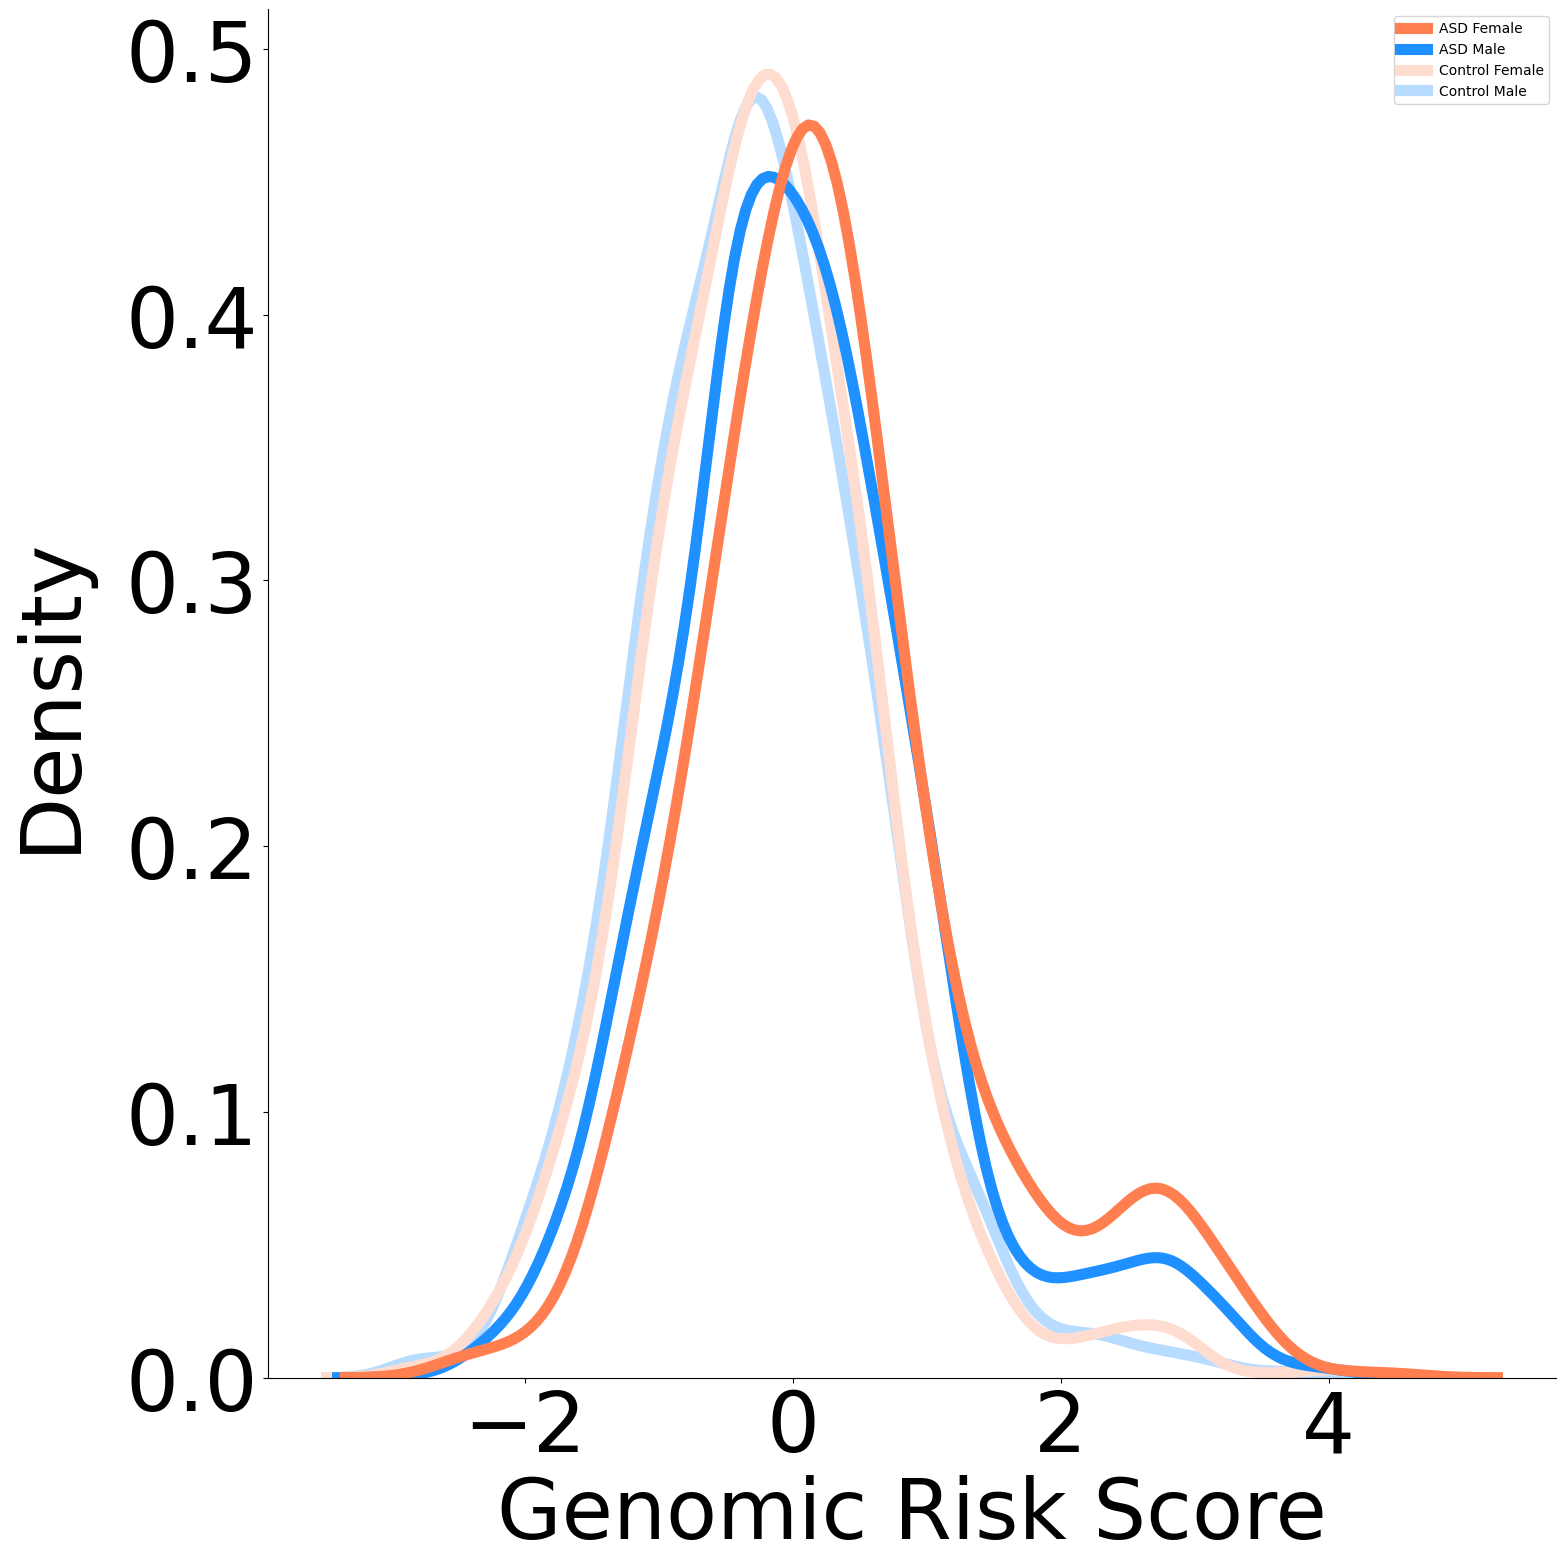

In [ ]:
# Figure 3C
""" Analysis """

df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")
feature = "GRS"
df = df.dropna(subset = [feature])
df['Sex'] = df['Sex'].replace({0: 'Male', 1: 'Female'})
df['Phenotype'] = df['Phenotype'].replace({0: 'Control', 1: 'ASD'})
df['Category'] = df['Phenotype'] + ' ' + df['Sex']

""" Plotting """
# Grid and grey background keeps showing up, so I'm putting this here (sets matplotlib to default settings)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = (16, 16))

kdeplot = sns.kdeplot(
    data = df,
    x = "GRS",
    hue = "Category",
    linewidth = 8,
    hue_order = ['ASD Female', 'ASD Male', 'Control Female', 'Control Male'],
    palette = ['coral', 'dodgerblue', '#ffdcd0', '#b8dcff'],
    alpha = 0.8,
    common_norm = False,
    legend = 'brief',
    multiple = "layer",
    ax = ax)

kdeplot.legend_.set_title(None)

ax.set_xlabel('Genomic Risk Score', fontsize = MASSIVE, color = "black")
ax.set_ylabel("Density", fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")
# Why does the grid appear randomly?
# ax.grid(True)
# ax.set_facecolor('white')

plt.xticks(fontsize = MASSIVE, color = "black")
plt.yticks(fontsize = MASSIVE, color = "black")

sns.set(font_scale = 3)
sns.set_context("talk")
# sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig3c.png", bbox_inches = "tight") # Maybe remove bbox_inches parameter
f.savefig("fig3c.svg", bbox_inches = "tight")
f.savefig("fig3c.pdf", bbox_inches = "tight")

# Figure 3d

In [ ]:
# Figure 3D
""" Analysis """

df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")
feature = "GRS"
df = df.dropna(subset = [feature])
df['Sex'] = df['Sex'].replace({0: 'Male', 1: 'Female'})
df['Phenotype'] = df['Phenotype'].replace({0: 'Control', 1: 'ASD'})
df['Category'] = df['Phenotype'] + ' ' + df['Sex']

""" Plotting """
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = (16, 16))

kdeplot = sns.kdeplot(
    data = df,
    x = "GRS",
    hue = "Category",
    linewidth = 2,
    hue_order = ['ASD Female','ASD Male','Control Female','Control Male'],
    palette = ['coral','dodgerblue','#ffdcd0','#b8dcff'],
    alpha = 0.8,
    common_norm = False,
    legend = 'brief',
    multiple = "fill",
    ax = ax)

kdeplot.legend_.set_title(None)

ax.set_xlabel('Genomic Risk Score', fontsize = MASSIVE, color = "black")
ax.set_ylabel("Density", fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")

plt.xticks(fontsize = MASSIVE, color = "black")
plt.yticks(fontsize = MASSIVE, color = "black")

sns.set(font_scale = 3)
sns.set_context("talk")
# sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig3d.png", bbox_inches = "tight") # Maybe remove bbox_inches parameter
f.savefig("fig3d.svg", bbox_inches = "tight")
f.savefig("fig3d.pdf", bbox_inches = "tight")

# Figure 4a

In [ ]:
# Figure 4A
""" Analysis """

df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")
feature = "PRS"
df = df.dropna(subset = [feature])
df['Phenotype'] = df['Phenotype'].replace({0: 'Control', 1: 'ASD'})

df["dnAll"] = df["dnLOF"] + df["dnMIS"]

# Only get samples with ASD
df = df[df["Phenotype"] == "ASD"]
df['Sex'] = df['Sex'].replace({0: 'ASD Male', 1: 'ASD Female'})
df["dnBool"] = df["dnAll"] > 0
df['dnBool'] = df['dnBool'].replace({True: 'Damaging DNM Carrier', False: 'No Damaging DNM'})

df_asd_male_dnm       = df[(df["dnBool"] == "Damaging DNM Carrier") & (df["Sex"] == "ASD Male")]
df_asd_male_no_dnm    = df[(df["dnBool"] == "No Damaging DNM")      & (df["Sex"] == "ASD Male")]
df_asd_female_dnm     = df[(df["dnBool"] == "Damaging DNM Carrier") & (df["Sex"] == "ASD Female")]
df_asd_female_no_dnm  = df[(df["dnBool"] == "No Damaging DNM")      & (df["Sex"] == "ASD Female")]

asd_male_dnm_no_dnm_p_value   = scipy.stats.ttest_ind(df_asd_male_dnm[feature], df_asd_male_no_dnm[feature])[1]
asd_female_dnm_no_dnm_p_value = scipy.stats.ttest_ind(df_asd_female_dnm[feature], df_asd_female_no_dnm[feature])[1]

""" Plotting """
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

f, ax = plt.subplots(1, 1, figsize = (16, 16))

ax = sns.barplot(
    x = "Sex",
    y = feature,
    hue = "dnBool",
    data = df,
    hue_order = ['No Damaging DNM', 'Damaging DNM Carrier'],
    order = ['ASD Female', 'ASD Male'],
    linewidth = 2,
    edgecolor = 'k',
    saturation = 1,
    ax = ax,
)

legend_handles = [
    Patch(facecolor = 'white', edgecolor = 'k', label = 'No Damaging DNM'),
    Patch(facecolor = 'white', edgecolor = 'k', label = 'Damaging DNM Carrier', hatch = '/')
]
# ax.legend(loc = 1, title = '', handles = leg, fontsize = BIG + 5)
ax.legend(loc = 1, title = '', fontsize = BIG + 5)

# ax.patches[0].set_color("coral")
# ax.patches[1].set_color("dodgerblue")
# ax.patches[2].set_hatch('/')
# ax.patches[2].set_color("#ffb296")
# ax.patches[3].set_hatch('/')
# ax.patches[3].set_color("#78bcff")

for i,p in enumerate(ax.patches):
  if i == 2 or i == 3:
    p.set_hatch('/')
  if i == 0:
    p.set_color("coral")
  if i == 1:
    p.set_color("dodgerblue")
  if i == 2:
    p.set_color('#ffb296')
  if i == 3:
    p.set_color("#78bcff")
  p.set_linewidth(2)
  p.set_edgecolor("k")
  
ax.axhline(linewidth=2, color='black')

ax.set_xlabel("")
ax.set_ylabel("Common Variant Risk Score", fontsize = MASSIVE, color = "black")

plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")

# Plot p-values
def plot_pvals(ax, index, pval, line_buffer = 0, text_buffer = 0):
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk = "***"
  elif pval < 0.01: pval_asterisk = "**"
  elif pval < 0.05: pval_asterisk = "*"

  # Properties of the bar
  width = ax.patches[index].get_width()
  x_start = ax.patches[index].xy[0]
  x_end   = x_start + width
  height  = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  x_left  = midpoint
  x_right = midpoint + width
  y_bottom = height + line_buffer
  y_top    = height + line_buffer + 0.03

  # Plotting p-value line segments
  ax.plot([x_left, x_left, x_right, x_right],
          [y_bottom, y_top, y_top, y_bottom], color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = BIG - 5, color = "black")

plot_pvals(ax, index = 0, pval = asd_female_dnm_no_dnm_p_value, line_buffer = 0.09, text_buffer = 0.13)
plot_pvals(ax, index = 1, pval = asd_male_dnm_no_dnm_p_value, line_buffer = 0.05, text_buffer = 0.09)


sns.set_context("talk")
sns.set_style("ticks")
sns.despine(ax = ax)

f.tight_layout()
f.show()

f.savefig("fig4a1.png", bbox_inches = "tight") # Maybe remove bbox_inches parameter
f.savefig("fig4a1.svg", bbox_inches = "tight")
f.savefig("fig4a1.pdf", bbox_inches = "tight")

# Figure 6 (new)

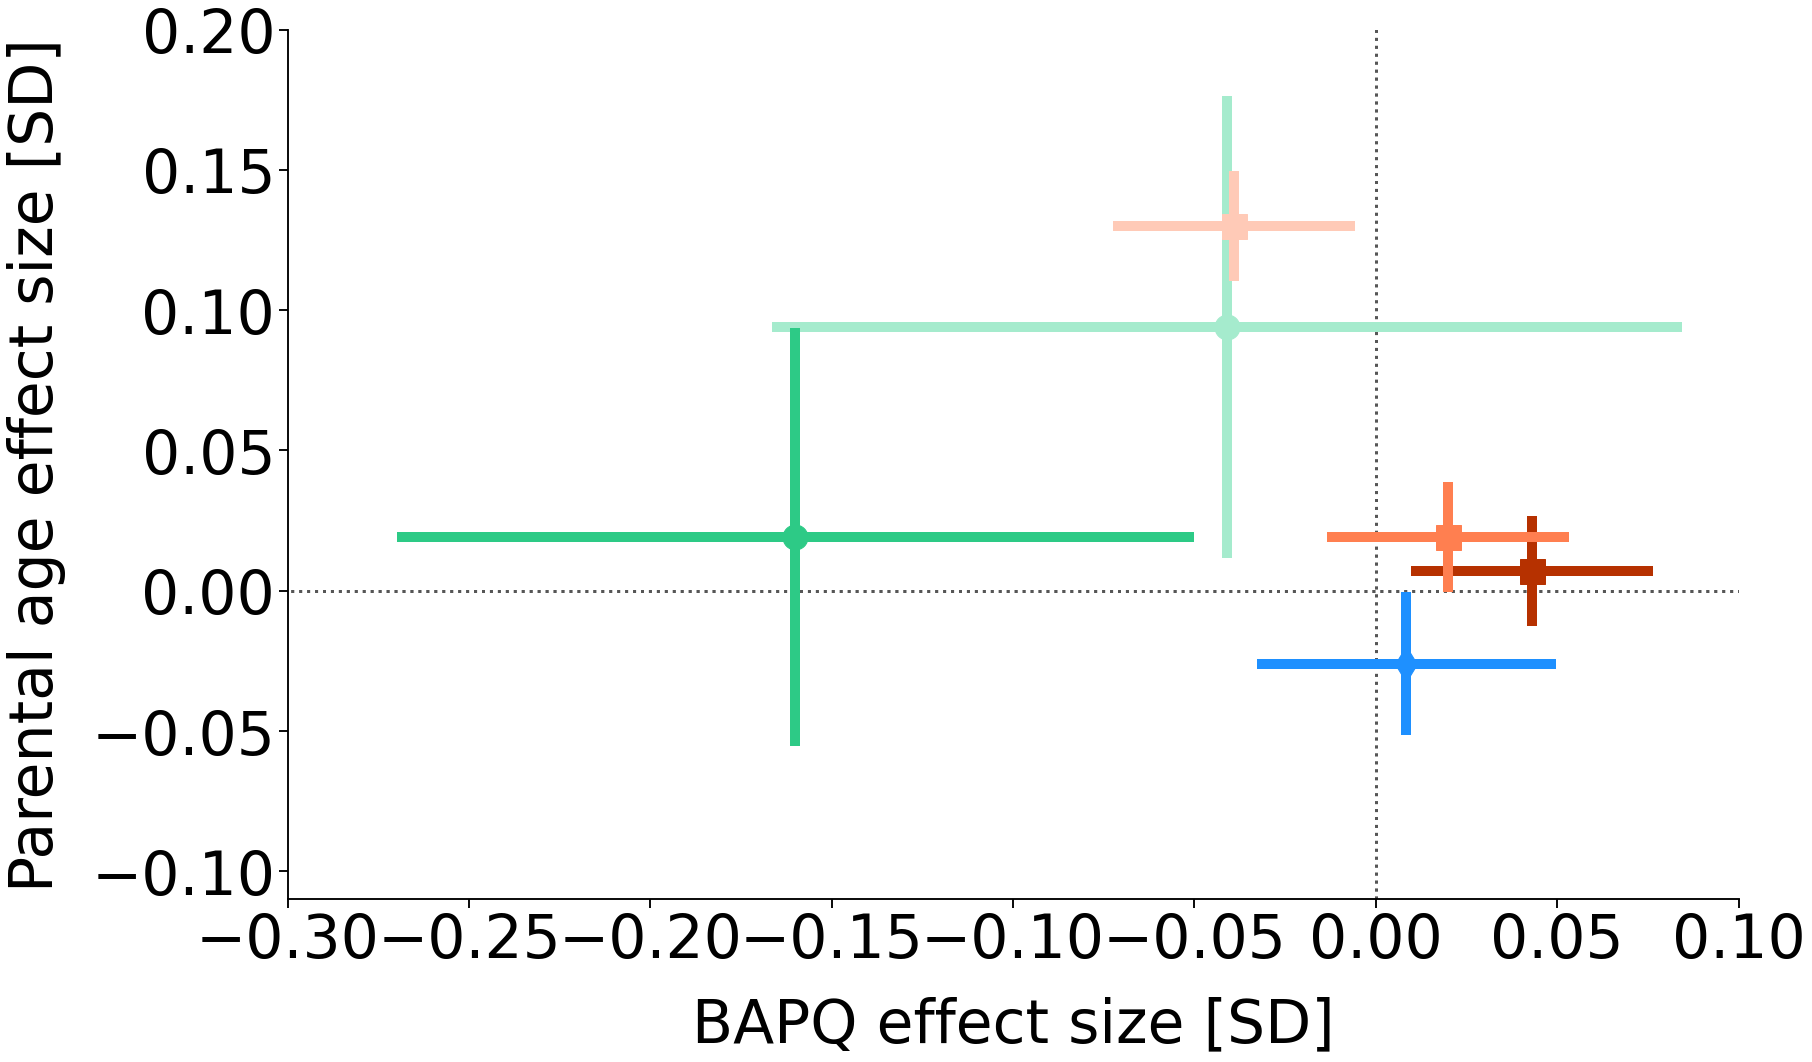

In [ ]:
# Figure 6
""" Analysis """
# Get clinical results table and reformat it
df_clinical = pd.read_csv("/content/clin_results_eur.SBayesR.20210715.csv", sep=",")

df_clinical = df_clinical[["case.status", "phenotype", "group", "variant.type", "r.sq", "est", "est.stderr", "pearson.cc", "x.pval", "sex.pval"]]
df_clinical["variant.type"] = df_clinical["variant.type"].replace({
    "dnmis": "dnMIS",
    "dnlof": "dnLOF",
    "inhLoF": "inhLOF",
    "ps.asd": "PS ASD",
    "ps.ea": "PS EA",
    "ps.sz": "PS SCZ"
})

# Make dataframe that is restricted to parental ages
df_clinical_parental_age = df_clinical[df_clinical["phenotype"] == "Parental Age"]
df_clinical_parental_age = df_clinical_parental_age.reset_index(drop = True)
# "Hacky" way of getting confidence interval from standard error
df_clinical_parental_age["est.ci"] = df_clinical_parental_age["est.stderr"]*1.96

# Make dataframe that is restricted to BAPQ
df_clinical_bapq = df_clinical[df_clinical["phenotype"] == "BAPQ"]
df_clinical_bapq = df_clinical_bapq.reset_index(drop = True)
# "Hacky" way of getting confidence interval from standard error
df_clinical_bapq["est.ci"] = df_clinical_bapq["est.stderr"]*1.96

# Merge
df_merge = pd.merge(df_clinical_parental_age, df_clinical_bapq,
                    on = ["case.status", "group", "variant.type"],
                    suffixes = ('.pa', '.bapq'))

""" Plotting """
def draw_plot(ax, df, index, entry):
  ax.errorbar(
      x = df["est.bapq"],
      y = df["est.pa"],
      xerr = np.abs(df["est.ci.bapq"]),
      yerr = np.abs(df["est.ci.pa"]),
      fmt = "o",
      marker = markers[index],
      color = colors[index],
      markersize = 25,
      linewidth = 10,
      label = entry
  )
  ax.set_ylim(-0.11, 0.2)
  ax.set_xlim(-0.3, 0.1)
  ax.hlines(y = 0, xmin = -0.4, xmax = 0.2, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  ax.vlines(x = 0, ymin = -0.11, ymax = 0.25, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  plt.yticks(fontsize = MASSIVE, color = "black")
  plt.xticks(fontsize = MASSIVE, color = "black")
  sns.despine(ax = ax)

variant_type = ['dnMIS','dnLOF','inhLOF','PS ASD','PS SCZ','PS EA']
colors = ['#a5ebcd', '#2dca86', 'dodgerblue', '#b63100', 'coral', '#ffcab7']
markers = ['o','o','d','s','s','s']

sns.set_context("talk")
# Combined parents plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
for index, entry in enumerate(variant_type):
  df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "parents")]
  draw_plot(ax = ax, df = df_both, index = index, entry = entry)
ax.set_xlabel("BAPQ effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
ax.set_ylabel("Parental age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# # Mother plots
# f_maternal, ax_maternal = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
# for index, entry in enumerate(variant_type):
#   df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "mother")]
#   draw_plot(ax = ax_maternal, df = df_both, index = index, entry = entry)
# ax_maternal.set_xlabel("Maternal BAPQ effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_maternal.set_ylabel("Maternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_maternal.legend(loc = 2, fontsize = MASSIVE - 15)
# # Father plots
# f_paternal, ax_paternal = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
# for index, entry in enumerate(variant_type):
#   df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "father")]
#   draw_plot(ax = ax_paternal, df = df_both, index = index, entry = entry)
# ax_paternal.set_xlabel("Paternal BAPQ effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_paternal.set_ylabel("Paternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")

f.savefig("fig6.both.png", bbox_inches = "tight")
f.savefig("fig6.both.svg", bbox_inches = "tight")
f.savefig("fig6.both.pdf", bbox_inches = "tight")

# f_maternal.savefig("fig6.maternal.png", bbox_inches = "tight")
# f_maternal.savefig("fig6.maternal.svg", bbox_inches = "tight")
# f_maternal.savefig("fig6.maternal.pdf", bbox_inches = "tight")

# f_paternal.savefig("fig6.paternal.png", bbox_inches = "tight")
# f_paternal.savefig("fig6.paternal.svg", bbox_inches = "tight")
# f_paternal.savefig("fig6.paternal.pdf", bbox_inches = "tight")

# Figure 6 (EA)

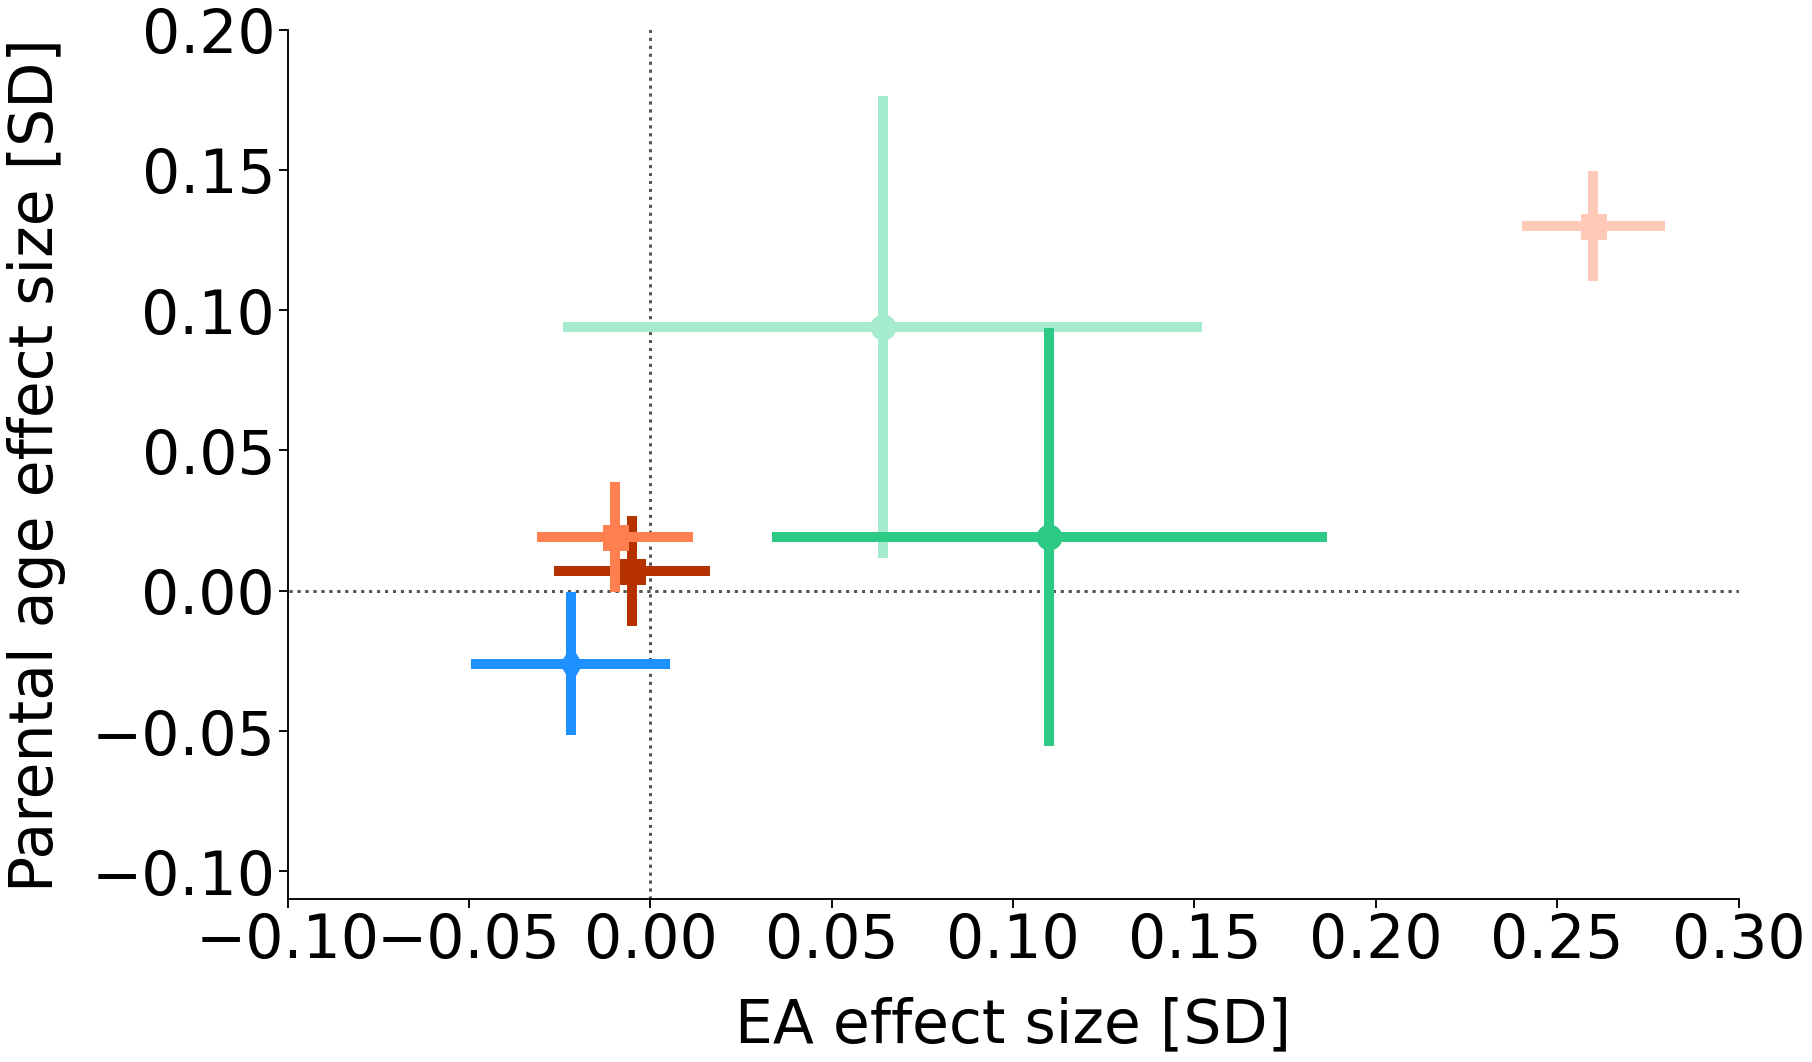

In [ ]:
pd.set_option('display.max_rows', None)
# Figure 6 (Parental EA vs. Parental Age)
""" Analysis """
# Get clinical results table and reformat it
df_clinical = pd.read_csv("/content/clin_results_eur.SBayesR.20210715.csv", sep=",")

df_clinical = df_clinical[["case.status", "phenotype", "group", "variant.type", "r.sq", "est", "est.stderr", "pearson.cc", "x.pval", "sex.pval"]]
df_clinical["variant.type"] = df_clinical["variant.type"].replace({
    "dnmis": "dnMIS",
    "dnlof": "dnLOF",
    "inhLoF": "inhLOF",
    "ps.asd": "PS ASD",
    "ps.ea": "PS EA",
    "ps.sz": "PS SCZ"
})

# Make dataframe that is restricted to parental ages
df_clinical_parental_age = df_clinical[df_clinical["phenotype"] == "Parental Age"]
df_clinical_parental_age = df_clinical_parental_age.reset_index(drop = True)
# "Hacky" way of getting confidence interval from standard error
df_clinical_parental_age["est.ci"] = df_clinical_parental_age["est.stderr"]*1.96

# Make dataframe that is restricted to BAPQ
df_clinical_parental_ea = df_clinical[df_clinical["phenotype"] == "Parental EA"]
df_clinical_parental_ea = df_clinical_parental_ea.reset_index(drop = True)
# "Hacky" way of getting confidence interval from standard error
df_clinical_parental_ea["est.ci"] = df_clinical_parental_ea["est.stderr"]*1.96

# Merge
df_merge = pd.merge(df_clinical_parental_age, df_clinical_parental_ea,
                    on = ["case.status", "group", "variant.type"],
                    suffixes = ('.pa', '.ea'))

""" Plotting """
def draw_plot(ax, df, index, entry):
  ax.errorbar(
      x = df["est.ea"],
      y = df["est.pa"],
      xerr = np.abs(df["est.ci.ea"]),
      yerr = np.abs(df["est.ci.pa"]),
      fmt = "o",
      marker = markers[index],
      color = colors[index],
      markersize = 25,
      linewidth = 10,
      label = entry
  )
  ax.set_ylim(-0.11, 0.2)
  ax.set_xlim(-0.1, 0.3)
  ax.hlines(y = 0, xmin = -0.4, xmax = 0.3, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  ax.vlines(x = 0, ymin = -0.11, ymax = 0.25, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  plt.yticks(fontsize = MASSIVE, color = "black")
  plt.xticks(fontsize = MASSIVE, color = "black")
  sns.despine(ax = ax)

variant_type = ['dnMIS','dnLOF','inhLOF','PS ASD','PS SCZ','PS EA']
colors = ['#a5ebcd', '#2dca86', 'dodgerblue', '#b63100', 'coral', '#ffcab7']
markers = ['o','o','d','s','s','s']

sns.set_context("talk")
# Combined parents plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
for index, entry in enumerate(variant_type):
  df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "parents")]
  draw_plot(ax = ax, df = df_both, index = index, entry = entry)
ax.set_xlabel("EA effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
ax.set_ylabel("Parental age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# # Mother plots
# f_maternal, ax_maternal = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
# for index, entry in enumerate(variant_type):
#   df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "mother")]
#   draw_plot(ax = ax_maternal, df = df_both, index = index, entry = entry)
# ax_maternal.set_xlabel("Maternal EA effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_maternal.set_ylabel("Maternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_maternal.legend(loc = 2, fontsize = MASSIVE - 15)
# # Father plots
# f_paternal, ax_paternal = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
# for index, entry in enumerate(variant_type):
#   df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "father")]
#   draw_plot(ax = ax_paternal, df = df_both, index = index, entry = entry)
# ax_paternal.set_xlabel("Paternal EA effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_paternal.set_ylabel("Paternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")

f.savefig("fig6.both.ea.png", bbox_inches = "tight")
f.savefig("fig6.both.ea.svg", bbox_inches = "tight")
f.savefig("fig6.both.ea.pdf", bbox_inches = "tight")

# f_maternal.savefig("fig6.maternal.ea.png", bbox_inches = "tight")
# f_maternal.savefig("fig6.maternal.ea.svg", bbox_inches = "tight")
# f_maternal.savefig("fig6.maternal.ea.pdf", bbox_inches = "tight")

# f_paternal.savefig("fig6.paternal.ea.png", bbox_inches = "tight")
# f_paternal.savefig("fig6.paternal.ea.svg", bbox_inches = "tight")
# f_paternal.savefig("fig6.paternal.ea.pdf", bbox_inches = "tight")

# Figure 6 (SRS)

In [ ]:
pd.set_option('display.max_rows', None)
# Figure 6 (Parental EA vs. Parental Age)
""" Analysis """
# Get clinical results table and reformat it
df_clinical = pd.read_csv("/content/clin_results_eur.SBayesR.20210715.csv", sep=",")

df_clinical = df_clinical[["case.status", "phenotype", "group", "variant.type", "r.sq", "est", "est.stderr", "pearson.cc", "x.pval", "sex.pval"]]
df_clinical["variant.type"] = df_clinical["variant.type"].replace({
    "dnmis": "dnMIS",
    "dnlof": "dnLOF",
    "inhLoF": "inhLOF",
    "ps.asd": "PS ASD",
    "ps.ea": "PS EA",
    "ps.sz": "PS SCZ"
})

# Make dataframe that is restricted to parental ages
df_clinical_parental_age = df_clinical[df_clinical["phenotype"] == "Parental Age"]
df_clinical_parental_age = df_clinical_parental_age.reset_index(drop = True)
# "Hacky" way of getting confidence interval from standard error
df_clinical_parental_age["est.ci"] = df_clinical_parental_age["est.stderr"]*1.96

# Make dataframe that is restricted to SRS
df_clinical_parental_srs = df_clinical[df_clinical["phenotype"] == "SRS"]
df_clinical_parental_srs = df_clinical_parental_srs.reset_index(drop = True)
# "Hacky" way of getting confidence interval from standard error
df_clinical_parental_srs["est.ci"] = df_clinical_parental_srs["est.stderr"]*1.96

# Merge
df_merge = pd.merge(df_clinical_parental_age, df_clinical_parental_srs,
                    on = ["case.status", "group", "variant.type"],
                    suffixes = ('.pa', '.srs'))

""" Plotting """
def draw_plot(ax, df, index, entry):
  ax.errorbar(
      x = df["est.srs"],
      y = df["est.pa"],
      xerr = np.abs(df["est.ci.srs"]),
      yerr = np.abs(df["est.ci.pa"]),
      fmt = "o",
      marker = markers[index],
      color = colors[index],
      markersize = 25,
      linewidth = 10,
      label = entry
  )
  ax.set_ylim(-0.11, 0.2)
  ax.set_xlim(-0.42, 0.15)
  ax.hlines(y = 0, xmin = -0.45, xmax = 0.3, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  ax.vlines(x = 0, ymin = -0.11, ymax = 0.25, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  plt.yticks(fontsize = MASSIVE, color = "black")
  plt.xticks(fontsize = MASSIVE, color = "black")
  sns.despine(ax = ax)

variant_type = ['dnMIS','dnLOF','inhLOF','PS ASD','PS SCZ','PS EA']
colors = ['#a5ebcd', '#2dca86', 'dodgerblue', '#b63100', 'coral', '#ffcab7']
markers = ['o','o','d','s','s','s']

sns.set_context("talk")
# Combined parents plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
for index, entry in enumerate(variant_type):
  df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "parents")]
  draw_plot(ax = ax, df = df_both, index = index, entry = entry)
ax.set_xlabel("SRS effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
ax.set_ylabel("Parental age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# # Mother plots
# f_maternal, ax_maternal = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
# for index, entry in enumerate(variant_type):
#   df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "mother")]
#   draw_plot(ax = ax_maternal, df = df_both, index = index, entry = entry)
# ax_maternal.set_xlabel("Maternal EA effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_maternal.set_ylabel("Maternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_maternal.legend(loc = 2, fontsize = MASSIVE - 15)
# # Father plots
# f_paternal, ax_paternal = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
# for index, entry in enumerate(variant_type):
#   df_both = df_merge[(df_merge["variant.type"] == entry) & (df_merge["group"] == "father")]
#   draw_plot(ax = ax_paternal, df = df_both, index = index, entry = entry)
# ax_paternal.set_xlabel("Paternal EA effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
# ax_paternal.set_ylabel("Paternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")

f.savefig("fig6.both.srs.png", bbox_inches = "tight")
f.savefig("fig6.both.srs.svg", bbox_inches = "tight")
f.savefig("fig6.both.srs.pdf", bbox_inches = "tight")

# f_maternal.savefig("fig6.maternal.ea.png", bbox_inches = "tight")
# f_maternal.savefig("fig6.maternal.ea.svg", bbox_inches = "tight")
# f_maternal.savefig("fig6.maternal.ea.pdf", bbox_inches = "tight")

# f_paternal.savefig("fig6.paternal.ea.png", bbox_inches = "tight")
# f_paternal.savefig("fig6.paternal.ea.svg", bbox_inches = "tight")
# f_paternal.savefig("fig6.paternal.ea.pdf", bbox_inches = "tight")

# Figure 6 (old)

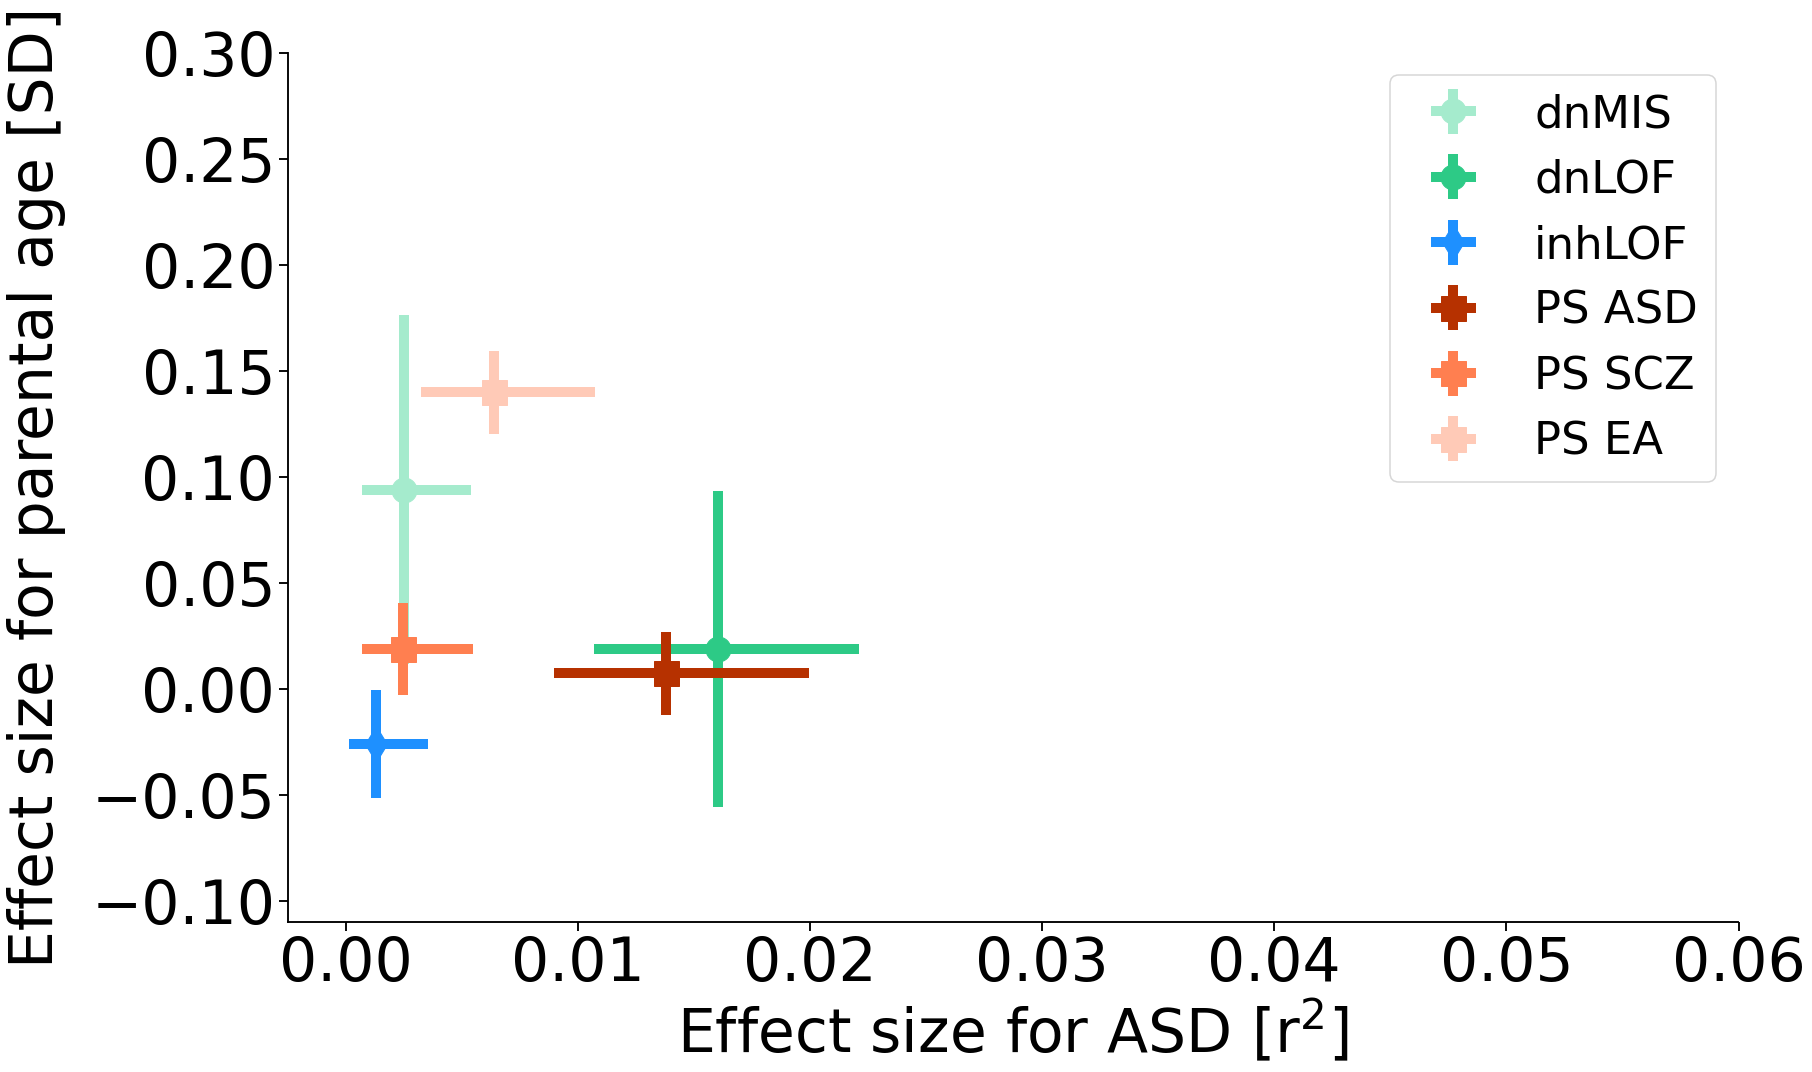

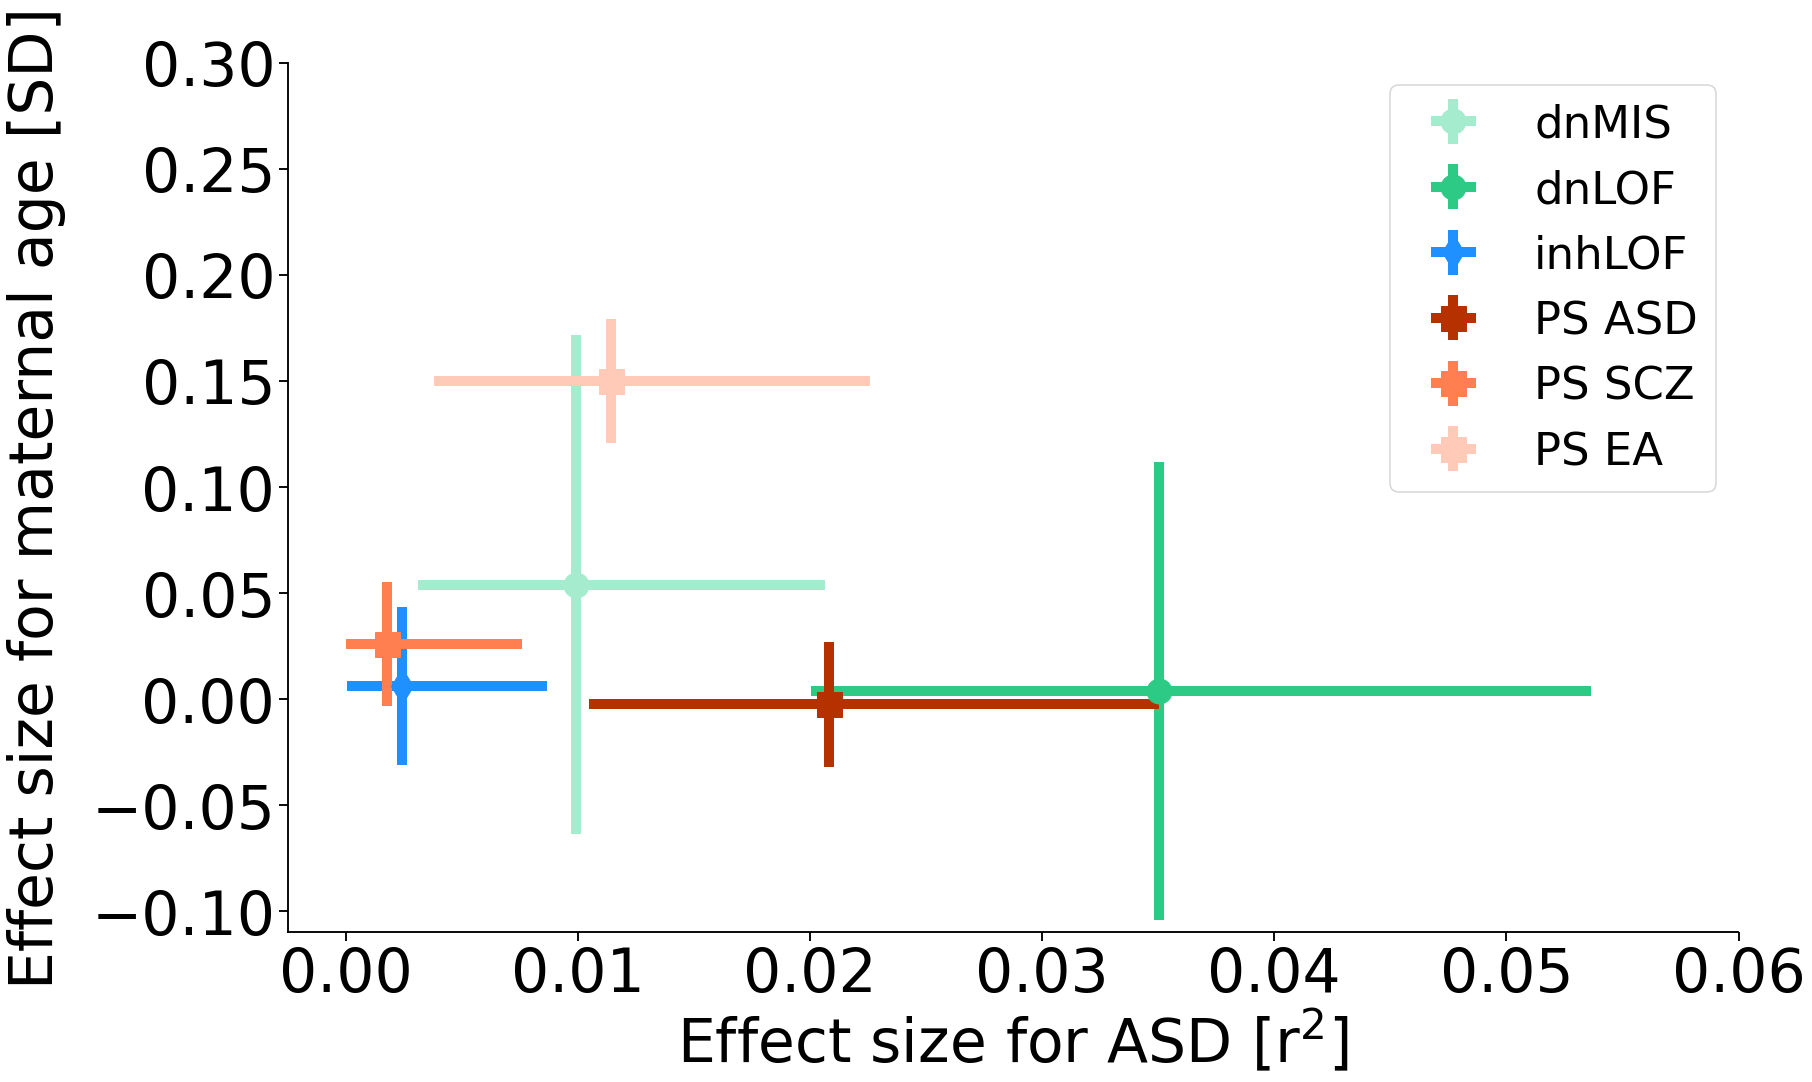

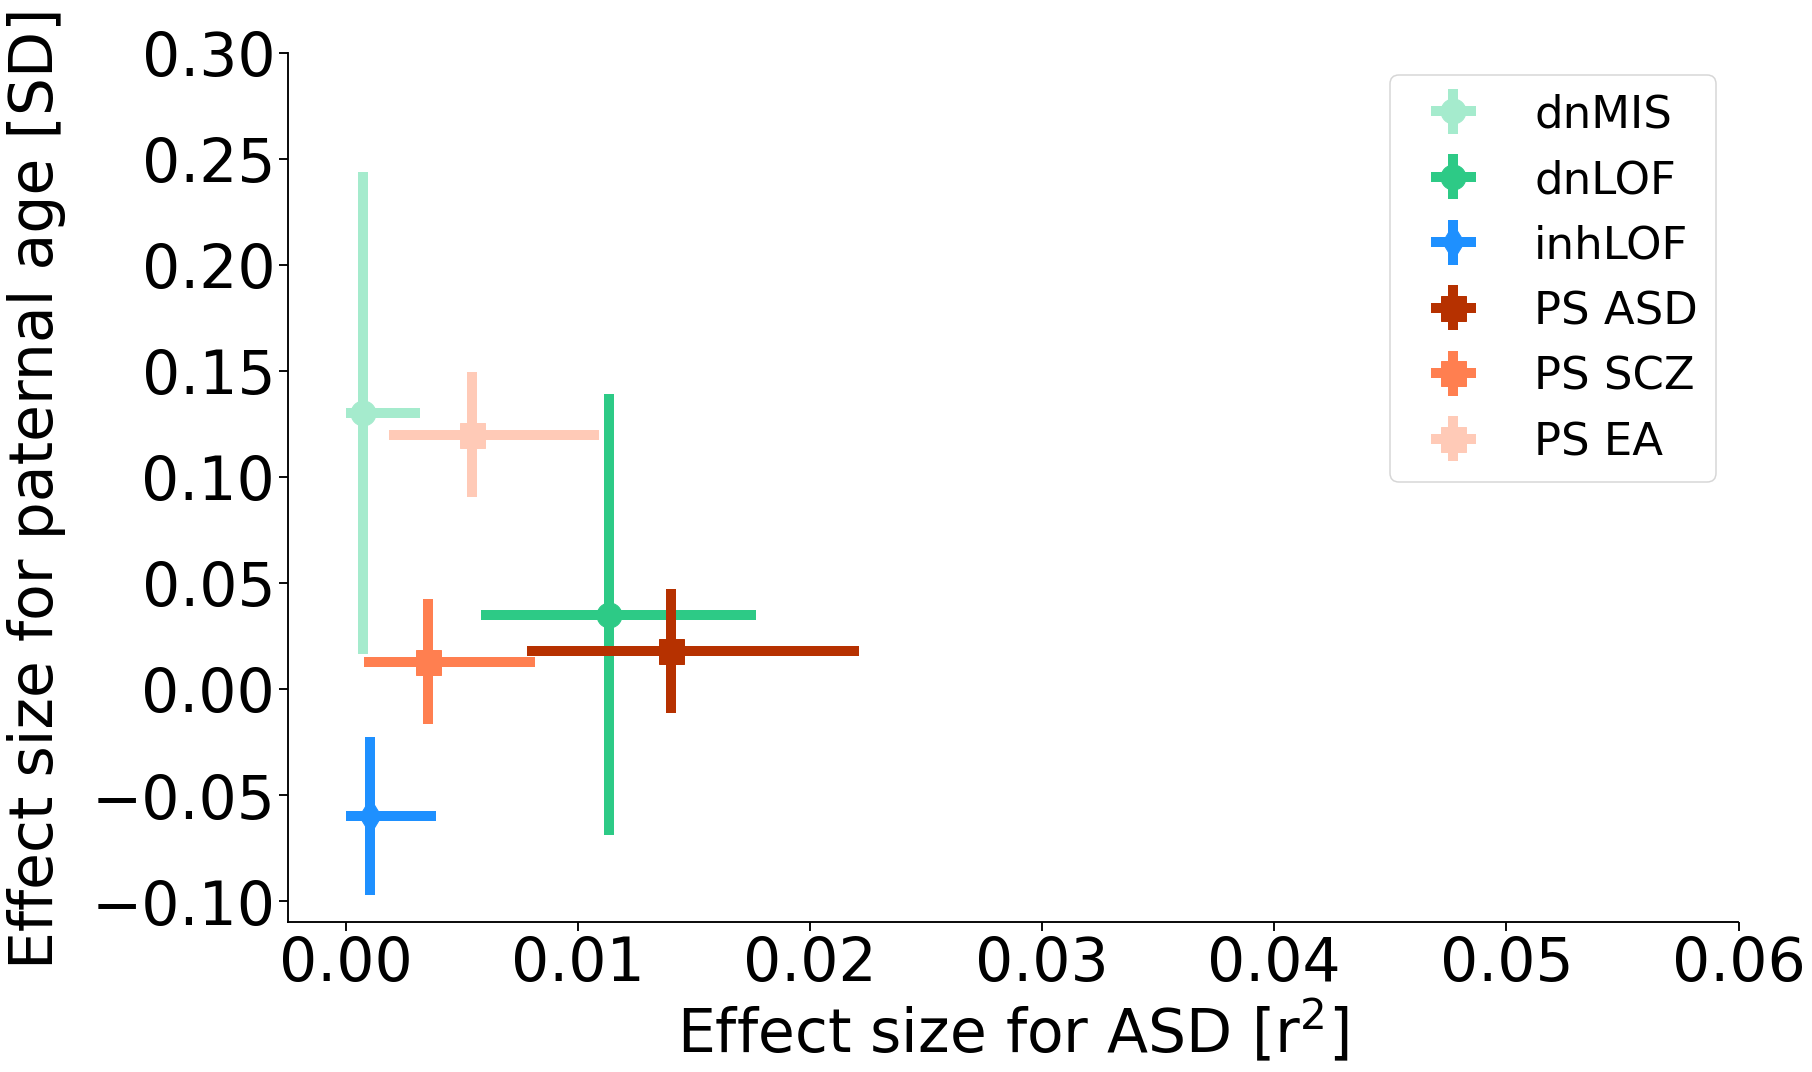

In [ ]:
# Figure 6
# Get Parental Age Estimates Table and reformat it
df_clin = pd.read_csv("/content/clin_results_eur.SBayesR.20210715.csv", sep=",")

df_clin = df_clin[["case.status", "phenotype", "group", "variant.type", "r.sq", "est", "est.stderr", "pearson.cc", "x.pval", "sex.pval"]]
df_clin["variant.type"] = df_clin["variant.type"].replace({
    "dnmis": "dnMIS",
    "dnlof": "dnLOF",
    "inhLoF": "inhLOF",
    "ps.asd": "PS ASD",
    "ps.ea": "PS EA",
    "ps.sz": "PS SCZ"
})
df_clin_parental_age = df_clin[df_clin["phenotype"] == "Parental Age"]

# Add sex column based on "group" column value
def set_sex(df_row):
  if df_row["group"] == "mother":
    return "female"
  elif df_row["group"] == "father":
    return "male"
  else:
    return "both"
df_clin_parental_age = df_clin_parental_age.assign(Sex=df_clin_parental_age.apply(set_sex, axis=1))
df_clin_parental_age = df_clin_parental_age.reset_index(drop=True)
# "Hacky" way of getting confidence interval from standard error
df_clin_parental_age["est.ci"] = df_clin_parental_age["est.stderr"]*1.96

# Get R2 Table and reformat it
df_r2 = pd.read_csv("/content/r2_table.csv", sep=",")


df_r2["ci_lower_adj"] = df_r2["nagelkerke_R2_val"] - df_r2["ci_lower"]
df_r2["ci_upper_adj"] = df_r2["ci_upper"] - df_r2["nagelkerke_R2_val"]

# df_r2[["R2_type", "Sex"]] = df_r2['R2_type'].str.split('_', 1, expand=True)
df_r2[["R2_type", "Sex"]] = df_r2['text'].str.split('_', 1, expand=True)
df_r2 = df_r2.rename(columns = {"R2_type": "variant.type"})
df_r2 = df_r2[(df_r2["variant.type"] == "dnLOF") | 
              (df_r2["variant.type"] == "dnMIS") |
              (df_r2["variant.type"] == "inhLOF") |
              (df_r2["variant.type"] == "ptdt.asd.dev") |
              (df_r2["variant.type"] == "ptdt.ea.dev") |
              (df_r2["variant.type"] == "ptdt.scz.dev")
              ]
df_r2["variant.type"] = df_r2["variant.type"].replace({
    "ptdt.asd.dev": "PS ASD",
    "ptdt.ea.dev": "PS EA",
    "ptdt.scz.dev": "PS SCZ"
})



df_r2 = df_r2.reset_index(drop=True)
# Merge Parental Age Estimates Table and R2 Table.
df_merge = df_clin_parental_age.merge(df_r2, on=["variant.type", "Sex"])


# Plotting
df = df_merge
def draw_plot(ax, df_in, index):
  ax.errorbar(
      x = df_in["nagelkerke_R2_val"],
      y = df_in["est"],
      # xerr = np.abs(df_in["ci"]),
      xerr = (np.abs(df_in["ci_lower_adj"]), np.abs(df_in["ci_upper_adj"])),
      yerr = np.abs(df_in["est.ci"]),
      fmt = "o",
      marker = mak[index],
      color = pal[index],
      # markersize = 18,
      markersize = 25,
      label = entry,
      # linewidth = 5,
      linewidth = 10,
      # alpha = 0.5
  )
  # ax.set_xlabel("Effect size for ASD [r$^2$]")
  # ax.set_ylabel("Effect size for parental age [standard deviation]")
  ax.set_xlabel("Effect size for ASD [r$^2$]", fontsize = MASSIVE, color = "black")
  # ax.set_ylabel("Effect size for parental age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")

  # ax.xaxis.grid(alpha=0.5)
  # ax.yaxis.grid(alpha=0.5)
  sns.despine(ax=ax)
  ax.set_ylim(-0.11,0.3)
  # ax.set_ylim(-0.5,0.5)
  ax.set_xlim(-0.0025,0.06)
  # ax.set_xlim(-0.01,0.03)
  
  plt.yticks(fontsize = MASSIVE, color = "black")
  plt.xticks(fontsize = MASSIVE, color = "black")
  ax.grid(False)

  ax.set_facecolor('white')
  ax.legend(loc = 1, fontsize = MASSIVE - 15)

  # ax.axhline(linewidth=2, color='black', y = -0.1)
  # ax.axvline(linewidth=2, color='black')



sns.set_context("talk")
mod = ['dnMIS','dnLOF','inhLOF','PS ASD','PS SCZ','PS EA']
pal = ['#a5ebcd','#2dca86','dodgerblue','#b63100','coral','#ffcab7']
mak = ['o','o','d','s','s','s']


f1, ax1 = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)

for index, entry in enumerate(mod):
  df_both = df[(df["variant.type"] == entry) & (df["Sex"] == "both")]
  draw_plot(ax1, df_both, index)
  ax1.set_ylabel("Effect size for parental age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")


  f1.savefig("fig6.both.png", bbox_inches = "tight")
  f1.savefig("fig6.both.svg", bbox_inches = "tight")
  f1.savefig("fig6.both.pdf", bbox_inches = "tight")


f2, ax2 = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)

for index, entry in enumerate(mod):
  df_mother = df[(df["variant.type"] == entry) & (df["Sex"] == "female")]
  draw_plot(ax2, df_mother, index)
  ax2.set_ylabel("Effect size for maternal age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")

  f2.savefig("fig6.mother.png", bbox_inches = "tight")
  f2.savefig("fig6.mother.svg", bbox_inches = "tight")
  f2.savefig("fig6.mother.pdf", bbox_inches = "tight")


f3, ax3 = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)

for index, entry in enumerate(mod):
  df_father = df[(df["variant.type"] == entry) & (df["Sex"] == "male")]
  draw_plot(ax3, df_father, index)
  ax3.set_ylabel("Effect size for paternal age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")

  f3.savefig("fig6.father.png", bbox_inches = "tight")
  f3.savefig("fig6.father.svg", bbox_inches = "tight")
  f3.savefig("fig6.father.pdf", bbox_inches = "tight")


In [ ]:
# Zip and download all the data
!zip -r /content/Antaki2021_figure_data.zip /content
from google.colab import files
files.download("/content/Antaki2021_figure_data.zip")


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.09.16/ (stored 0%)
  adding: content/.config/logs/2021.09.16/13.39.42.091206.log (deflated 86%)
  adding: content/.config/logs/2021.09.16/13.39.26.986455.log (deflated 54%)
  adding: content/.config/logs/2021.09.16/13.39.08.594436.log (deflated 91%)
  adding: content/.config/logs/2021.09.16/13.40.04.258538.log (deflated 55%)
  adding: content/.config/logs/2021.09.16/13.39.47.632524.log (deflated 53%)
  adding: content/.config/logs/2021.09.16/13.40.04.910768.log (deflated 54%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configuration

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ttest_indResult(statistic=-1.064790720505704, pvalue=0.2876764514512674)
Ttest_indResult(statistic=3.2312191204869367, pvalue=0.0012422602896057613)
Ttest_indResult(statistic=-1.1713594154380293, pvalue=0.2414842738404432)
Ttest_indResult(statistic=0.32856003056205774, pvalue=0.7424932336801155)


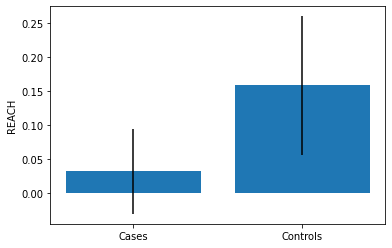

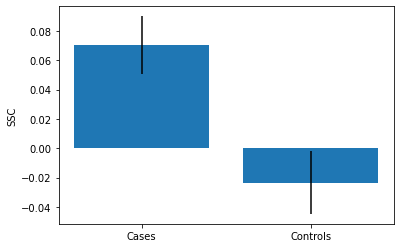

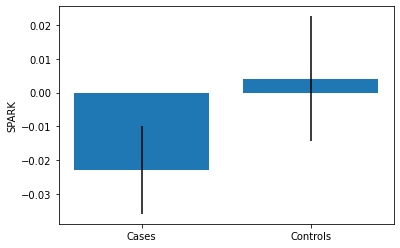

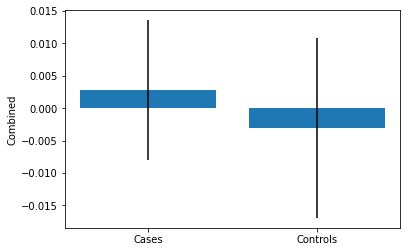

In [ ]:
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]

# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)

# Get parental ages
df_mp = pd.read_csv("/content/master_phen_4.SBayesR.csv", sep=",")
df_mp = df_mp[["fid", "iid", "phen", "sex", "cohort",
               "father.age.at.birth.z", "mother.age.at.birth.z"]]
df_mp = df_mp.rename(columns = {"fid": "FID", "iid": "IID", "phen": "Phenotype", "sex": "Sex", "cohort": "Cohort"})
df_mp['Sex'] = df_mp['Sex'].replace({"Male": 0, "Female": 1})
df_mp['Phenotype'] = df_mp['Phenotype'].replace({"CON": 0, "ASD": 1})
df_mp['Cohort'] = df_mp['Cohort'].replace({1: "REACH", 2: "SSC", 3: "SPARK"})

df_dnms_pa_merge = df_dnms_merge.merge(df_mp, on = ["IID", "FID", "Sex", "Phenotype", "Cohort"], how = "left")
# df_dnms_pa_merge[df_dnms_pa_merge["father.age.at.birth.z"].isna()]
# df_dnms_pa_merge[df_dnms_pa_merge["mother.age.at.birth.z"].isna()]
# df_dnms_pa_merge[df_dnms_pa_merge["father.age.at.birth.z"].isna() & df_dnms_pa_merge["mother.age.at.birth.z"].notna()]
# df_dnms_pa_merge[df_dnms_pa_merge["mother.age.at.birth.z"].isna() & df_dnms_pa_merge["father.age.at.birth.z"].notna()]
df_dnms_pa_merge = df_dnms_pa_merge.dropna(subset = ["father.age.at.birth.z"])

df_cas = df_dnms_pa_merge[df_dnms_pa_merge["Phenotype"] == 1]
df_ctl = df_dnms_pa_merge[df_dnms_pa_merge["Phenotype"] == 0]

df_cas_reach = df_cas[df_cas["Cohort"] == "REACH"]
df_cas_ssc   = df_cas[df_cas["Cohort"] == "SSC"]
df_cas_spark = df_cas[df_cas["Cohort"] == "SPARK"]

df_ctl_reach = df_ctl[df_ctl["Cohort"] == "REACH"]
df_ctl_ssc   = df_ctl[df_ctl["Cohort"] == "SSC"]
df_ctl_spark = df_ctl[df_ctl["Cohort"] == "SPARK"]

# col = "father.age.at.birth.z"
# REACH
# print(scipy.stats.ttest_ind(df_cas_reach[col], df_ctl_reach[col]))
# # SSC
# print(scipy.stats.ttest_ind(df_cas_ssc[col], df_ctl_ssc[col]))
# # SPARK
# print(scipy.stats.ttest_ind(df_cas_spark[col], df_ctl_spark[col]))

def plot_bar(df, col, ax, cohort = None):
  df_tmp = df
  if cohort:
    df_tmp = df[df["Cohort"] == cohort]

  df_cas = df_tmp[df_tmp["Phenotype"] == 1]
  df_ctl = df_tmp[df_tmp["Phenotype"] == 0]

  cas_mean = df_cas[col].mean()
  cas_sem = df_cas[col].sem()

  ctl_mean = df_ctl[col].mean()
  ctl_sem = df_ctl[col].sem()

  print(scipy.stats.ttest_ind(df_cas["father.age.at.birth.z"], df_ctl["father.age.at.birth.z"]))

  ax.bar(
    x = ["Cases", "Controls"],
    height = [cas_mean, ctl_mean],
    yerr = [cas_sem, ctl_sem],
    )
  
  if cohort:
    ax.set_ylabel(cohort)
  else:
    ax.set_ylabel("Combined")



f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax, cohort = "REACH")

f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax, cohort = "SSC")

f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax, cohort = "SPARK")

f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax)


# All the QC plots

df_dnms_pa_merge = df_dnms_pa_merge.dropna(subset = ["father.age.at.birth.z"])


# LoF, Missense, Synonymous
# Potential confounders?



In [ ]:
# dnLoF, dnMis, and dnSyn counts

exclude_iids = ["SSC00428",
"SSC00796",
"SSC12169",
"SSC10120",
"SSC10135",
"SSC06079",
"SSC10085",
"SSC06086",
"SSC12150",
"SSC10090"]

def plot_pvals(ax, index, pval, text_buffer = 0, line_buffer = 0):
  # if pval > 0.05: return
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk =  "***"
  elif pval < 0.01: pval_asterisk =  "**"
  elif pval < 0.05: pval_asterisk =  "*"

  # Properties of the bar
  xy = ax.patches[index].xy
  x_start = xy[0]
  width = ax.patches[index].get_width()
  x_end = x_start + width
  height = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  ax.plot([midpoint, midpoint, midpoint + width, midpoint + width], [height + line_buffer, height + 0.005 + line_buffer, height + 0.005 + line_buffer, height + line_buffer], linewidth = 2, color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE, color = "black")


def make_df(df, col, cohort = None):
  df_tmp = df.dropna(subset = [col])

  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["Cohort", "DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])
  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])


# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]
# Exclude the hypermutators
df = df[~df["IID"].isin(exclude_iids)]

# Get DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)
df_dnms_merge["sum_count"] = df_dnms_merge['lof_count'] + df_dnms_merge['mis_count'] + df_dnms_merge['syn_count']

# Combined cohort
df_lof_count = make_df(df_dnms_merge, "lof_count")
# df_lof_count_original = make_df(df_dnms_merge, "dnLOF")
df_mis_count = make_df(df_dnms_merge, "mis_count")
# df_mis_count_original = make_df(df_dnms_merge, "dnMIS")
df_syn_count = make_df(df_dnms_merge, "syn_count")
# df_2b = pd.concat([df_lof_count, df_lof_count_original, df_mis_count, df_mis_count_original, df_syn_count])
df_sum_count = make_df(df_dnms_merge, "sum_count")
df_2b = pd.concat([df_lof_count, df_mis_count, df_syn_count, df_sum_count])

# Per cohort
df_lof_count_REACH = make_df(df_dnms_merge, "lof_count", "REACH")
# df_lof_count_REACH_original = make_df(df_dnms_merge, "dnLOF", "REACH")
df_mis_count_REACH = make_df(df_dnms_merge, "mis_count", "REACH")
# df_mis_count_REACH_original = make_df(df_dnms_merge, "dnMIS", "REACH")
df_syn_count_REACH = make_df(df_dnms_merge, "syn_count", "REACH")
df_sum_count_REACH = make_df(df_dnms_merge, "sum_count", "REACH")

df_lof_count_SSC = make_df(df_dnms_merge, "lof_count", "SSC")
# df_lof_count_SSC_original = make_df(df_dnms_merge, "dnLOF", "SSC")
df_mis_count_SSC = make_df(df_dnms_merge, "mis_count", "SSC")
# df_mis_count_SSC_original = make_df(df_dnms_merge, "dnMIS", "SSC")
df_syn_count_SSC = make_df(df_dnms_merge, "syn_count", "SSC")
df_sum_count_SSC = make_df(df_dnms_merge, "sum_count", "SSC")

df_lof_count_SPARK = make_df(df_dnms_merge, "lof_count", "SPARK")
# df_lof_count_SPARK_original = make_df(df_dnms_merge, "dnLOF", "SPARK")
df_mis_count_SPARK = make_df(df_dnms_merge, "mis_count", "SPARK")
# df_mis_count_SPARK_original = make_df(df_dnms_merge, "dnMIS", "SPARK")
df_syn_count_SPARK = make_df(df_dnms_merge, "syn_count", "SPARK")
df_sum_count_SPARK = make_df(df_dnms_merge, "sum_count", "SPARK")

# df_2b_cohorts = pd.concat([df_lof_count_REACH, df_lof_count_REACH_original, df_mis_count_REACH, df_mis_count_REACH_original, df_syn_count_REACH,
#                            df_lof_count_SSC, df_lof_count_SSC_original, df_mis_count_SSC, df_mis_count_SSC_original, df_syn_count_SSC,
#                            df_lof_count_SPARK, df_lof_count_SPARK_original, df_mis_count_SPARK, df_mis_count_SPARK_original, df_syn_count_SPARK])
df_2b_cohorts = pd.concat([df_lof_count_REACH, df_mis_count_REACH, df_syn_count_REACH, df_sum_count_REACH,
                           df_lof_count_SSC, df_mis_count_SSC, df_syn_count_SSC, df_sum_count_SSC,
                           df_lof_count_SPARK, df_mis_count_SPARK, df_syn_count_SPARK, df_sum_count_SPARK])


# Plotting
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_2b.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b["ASD Samples"].astype(str) + "\n" + df_2b["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b["P-value"].values[2], text_buffer = 0.1)
plot_pvals(ax, index = 3, pval = df_2b["P-value"].values[3], text_buffer = 0.05)

f.savefig("fig.rebuttal.combined.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.combined.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.combined.pdf", bbox_inches = "tight")


# REACH plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"].plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["REACH ASD", "REACH Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('REACH DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["ASD Samples"].astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[2], text_buffer = 0.1)
plot_pvals(ax, index = 3, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[3], text_buffer = 0.05)

f.savefig("fig.rebuttal.reach.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.reach.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.reach.pdf", bbox_inches = "tight")


# SSC plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"].plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SSC ASD", "SSC Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('SSC DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["ASD Samples"].astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[2], text_buffer = 0.1)
plot_pvals(ax, index = 3, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[3], text_buffer = 0.05)

f.savefig("fig.rebuttal.ssc.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.ssc.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.ssc.pdf", bbox_inches = "tight")


# SPARK plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"].plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('SPARK DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["ASD Samples"].astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[2], text_buffer = 0.05)
plot_pvals(ax, index = 3, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[3], text_buffer = 0.05)


f.savefig("fig.rebuttal.spark.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.spark.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.spark.pdf", bbox_inches = "tight")



df_2b.to_csv("df_rebuttal.csv", index = False)
df_2b_cohorts.to_csv("df_rebuttal_cohorts.csv", index = False)

FileNotFoundError: ignored

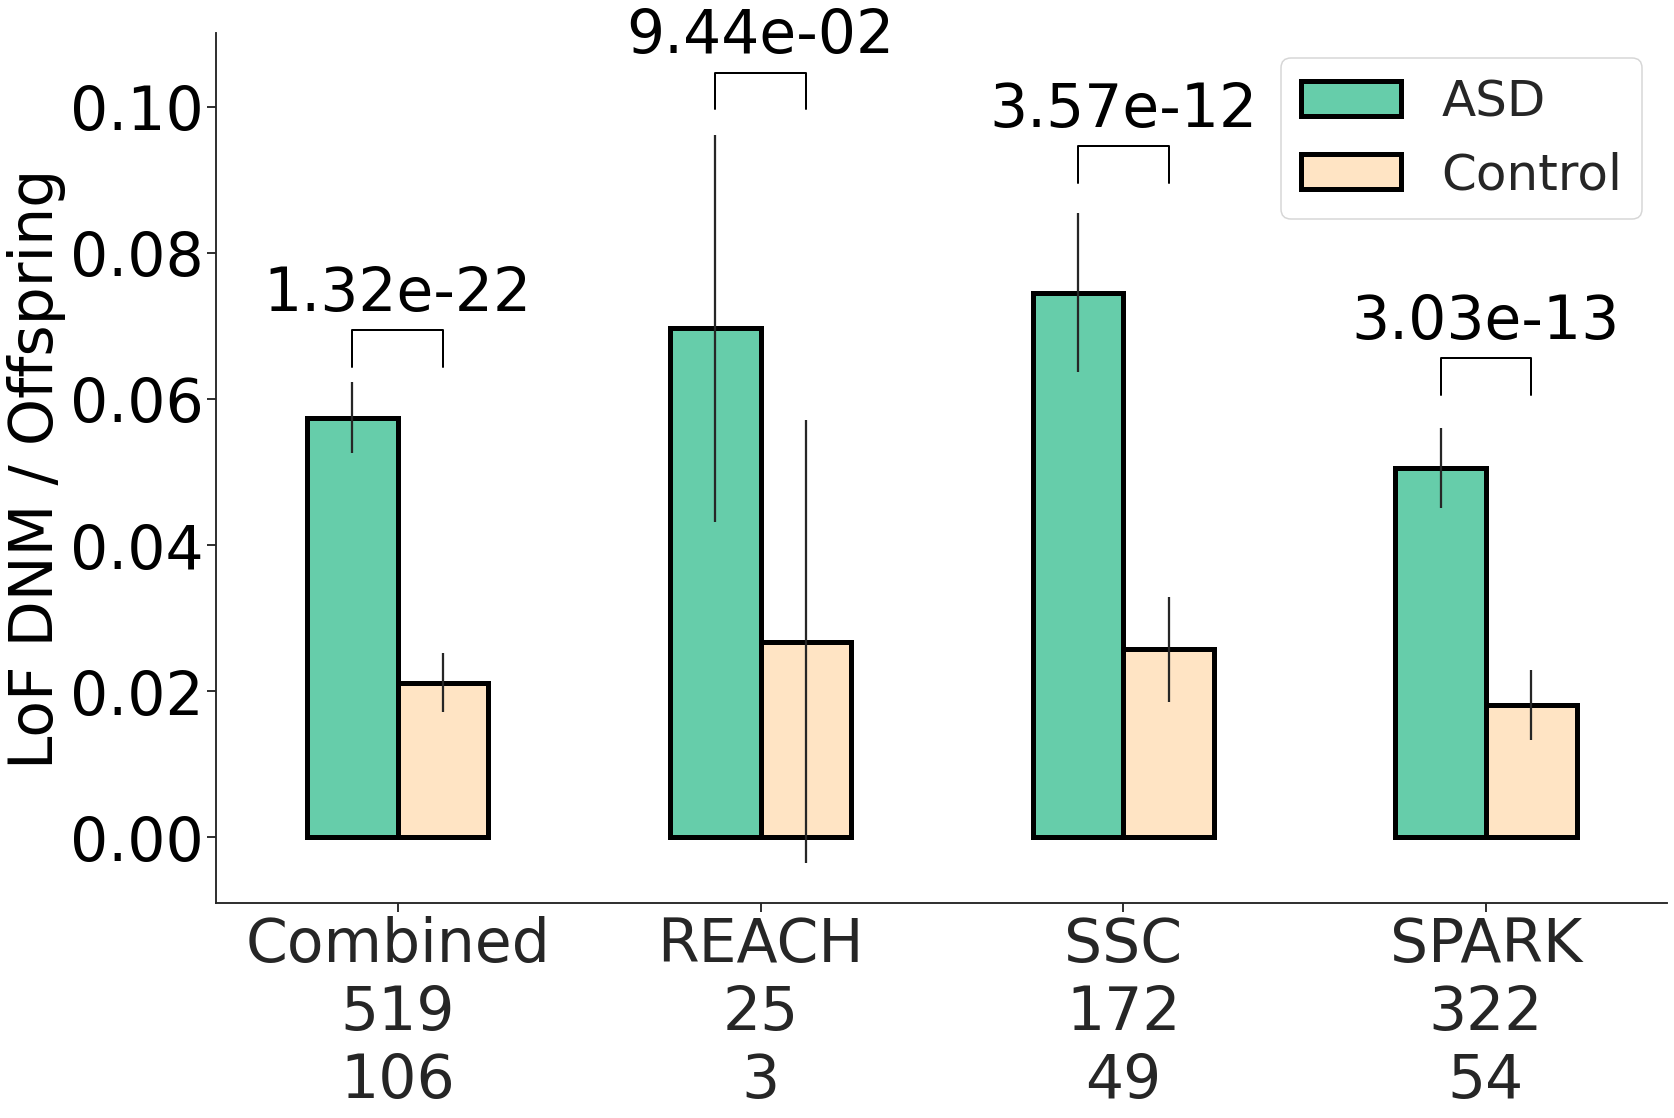

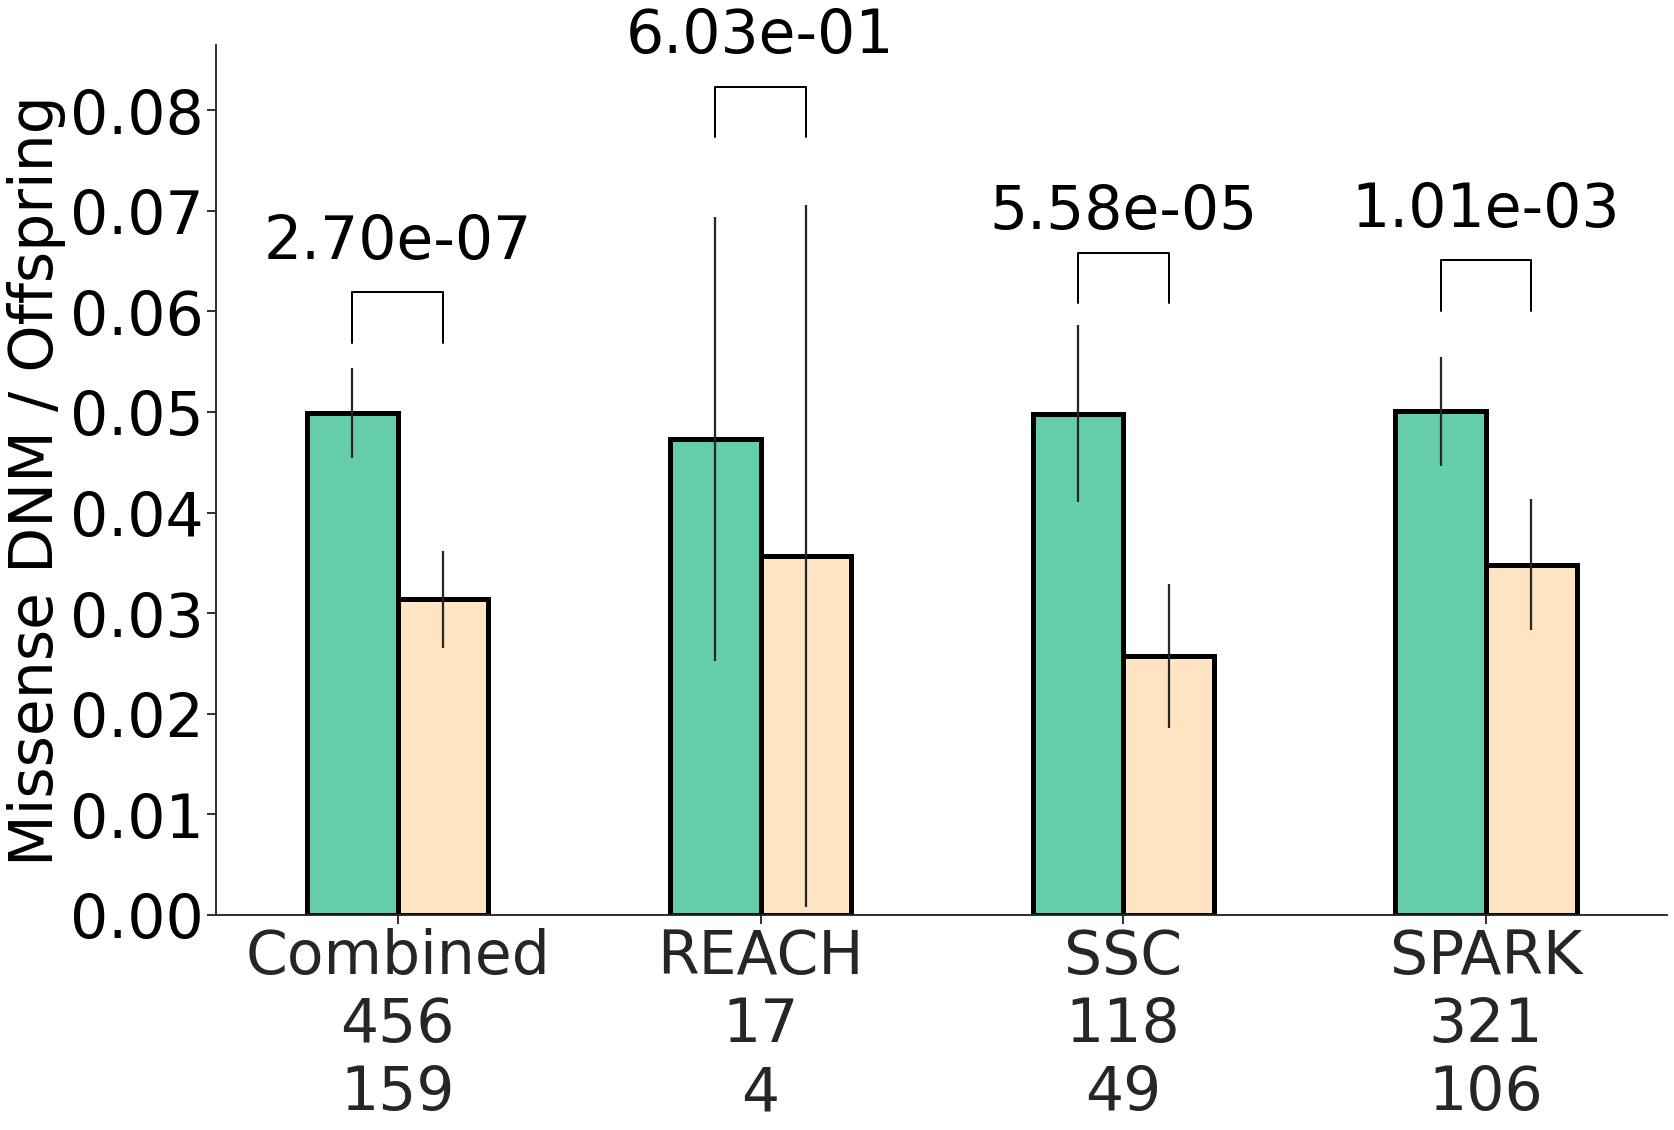

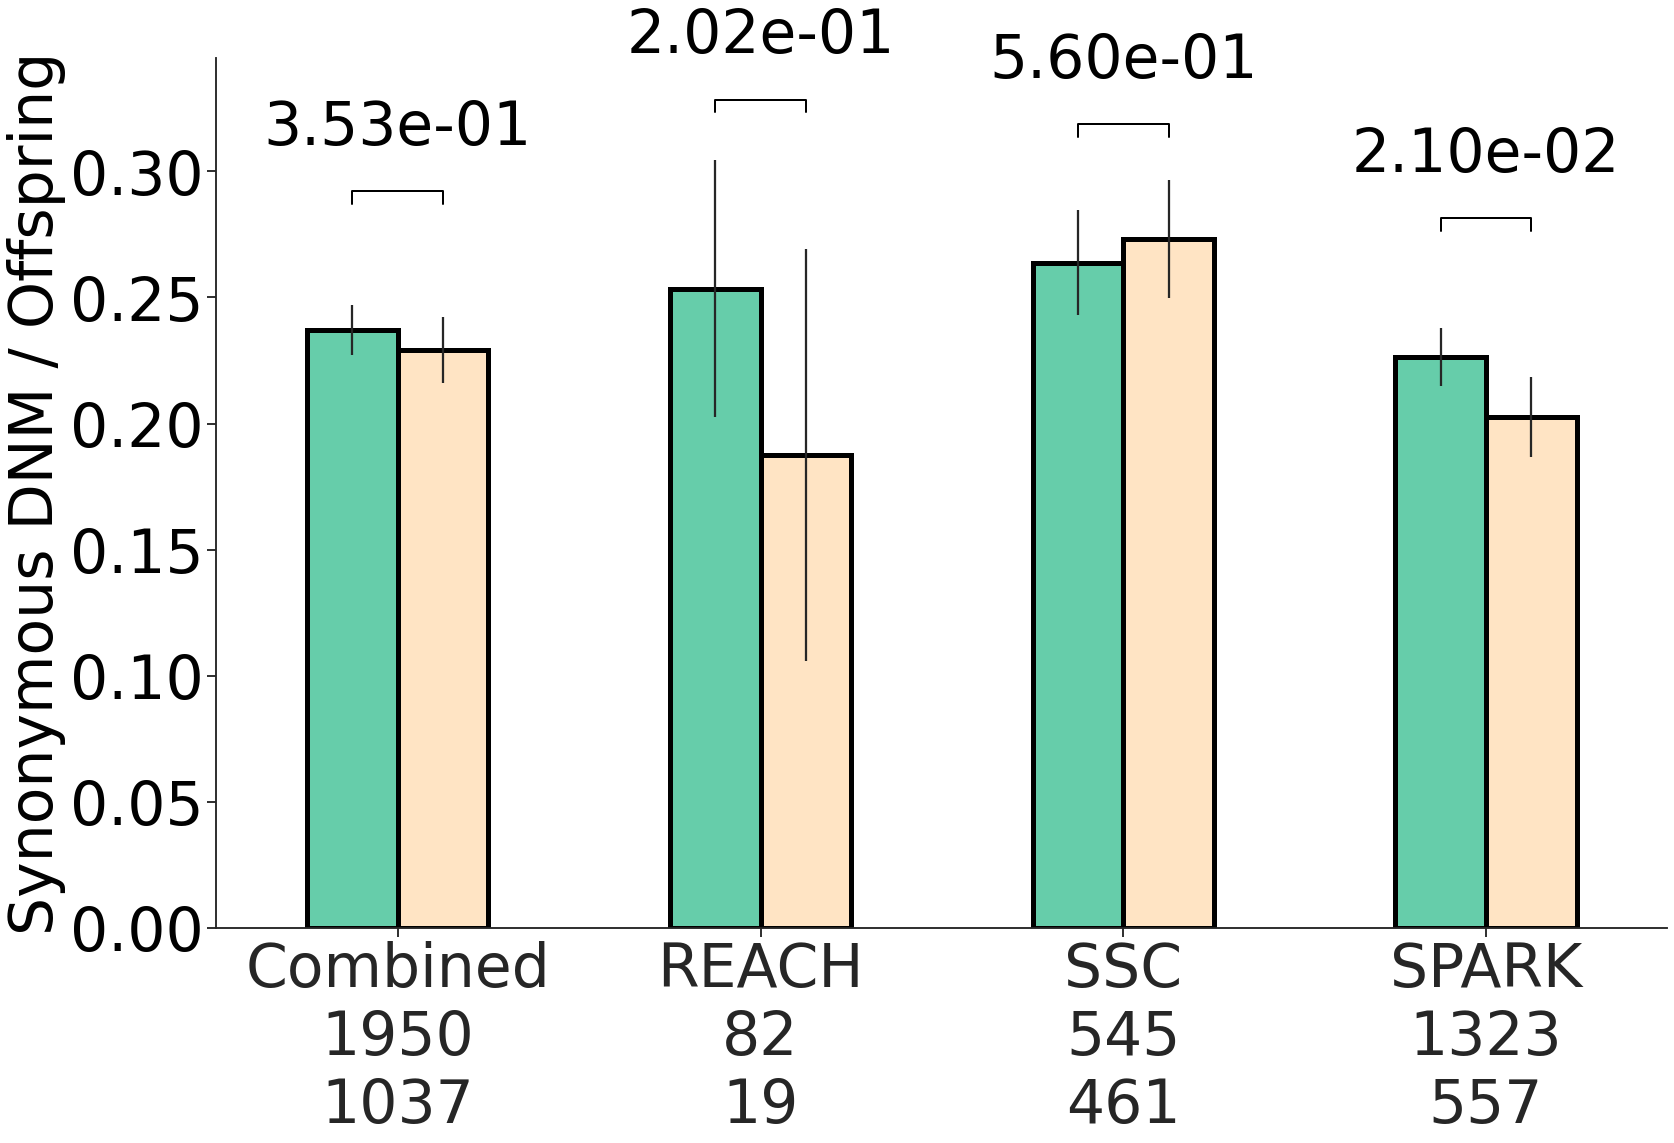

In [ ]:
df_2b["Cohort"] = ["Combined"]*4
df_lof = pd.concat([df_2b[df_2b["DNMs"] == "lof_count"], df_2b_cohorts[df_2b_cohorts["DNMs"] == "lof_count"]])
df_mis = pd.concat([df_2b[df_2b["DNMs"] == "mis_count"], df_2b_cohorts[df_2b_cohorts["DNMs"] == "mis_count"]])
df_syn = pd.concat([df_2b[df_2b["DNMs"] == "syn_count"], df_2b_cohorts[df_2b_cohorts["DNMs"] == "syn_count"]])

# LoF
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_lof.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_lof[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('LoF DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_lof_labels = df_lof["Cohort"].astype(str) + "\n" + df_lof["ASD Samples"].astype(str) + "\n" + df_lof["Control Samples"].astype(str)
ax.set_xticklabels(df_lof_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_lof["P-value"].values[0], line_buffer = 0.007, text_buffer = 0.017)
plot_pvals(ax, index = 1, pval = df_lof["P-value"].values[1], line_buffer = 0.030, text_buffer = 0.040)
plot_pvals(ax, index = 2, pval = df_lof["P-value"].values[2], line_buffer = 0.015, text_buffer = 0.025)
plot_pvals(ax, index = 3, pval = df_lof["P-value"].values[3], line_buffer = 0.010, text_buffer = 0.020)

f.savefig("fig.rebuttal.lof.exclude_hypermutators.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.lof.exclude_hypermutators.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.lof.exclude_hypermutators.pdf", bbox_inches = "tight")


# Missense
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_mis.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_mis[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    legend = None,
    ax = ax
)

# leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('Missense DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_mis_labels = df_mis["Cohort"].astype(str) + "\n" + df_mis["ASD Samples"].astype(str) + "\n" + df_mis["Control Samples"].astype(str)
ax.set_xticklabels(df_mis_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_mis["P-value"].values[0], line_buffer = 0.007, text_buffer = 0.017)
plot_pvals(ax, index = 1, pval = df_mis["P-value"].values[1], line_buffer = 0.030, text_buffer = 0.040)
plot_pvals(ax, index = 2, pval = df_mis["P-value"].values[2], line_buffer = 0.011, text_buffer = 0.020)
plot_pvals(ax, index = 3, pval = df_mis["P-value"].values[3], line_buffer = 0.010, text_buffer = 0.020)

f.savefig("fig.rebuttal.mis.exclude_hypermutators.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.mis.exclude_hypermutators.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.mis.exclude_hypermutators.pdf", bbox_inches = "tight")


# Synonymous
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_syn.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_syn[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    legend = None,
    ax = ax
)

# leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('Synonymous DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_syn_labels = df_syn["Cohort"].astype(str) + "\n" + df_syn["ASD Samples"].astype(str) + "\n" + df_syn["Control Samples"].astype(str)
ax.set_xticklabels(df_syn_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_syn["P-value"].values[0], line_buffer = 0.05, text_buffer = 0.08)
plot_pvals(ax, index = 1, pval = df_syn["P-value"].values[1], line_buffer = 0.07, text_buffer = 0.10)
plot_pvals(ax, index = 2, pval = df_syn["P-value"].values[2], line_buffer = 0.05, text_buffer = 0.08)
plot_pvals(ax, index = 3, pval = df_syn["P-value"].values[3], line_buffer = 0.05, text_buffer = 0.08)

f.savefig("fig.rebuttal.syn.exclude_hypermutators.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.syn.exclude_hypermutators.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.syn.exclude_hypermutators.pdf", bbox_inches = "tight")

In [ ]:
# Rebuttal supplementary table
df_dnms = pd.concat([df_lof, df_mis, df_syn])
df_dnms = df_dnms[["Cohort", "DNMs", 
                   "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", 
                   "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations",
                   "P-value"]]
df_dnms["DNMs"] = df_dnms["DNMs"].replace({
    "lof_count": "dnLoF",
    "mis_count": "dnMis",
    "syn_count": "dnSyn",
})

df_dnms.to_csv("SupplementaryTable2.dnms.rebuttal.csv", index = False)

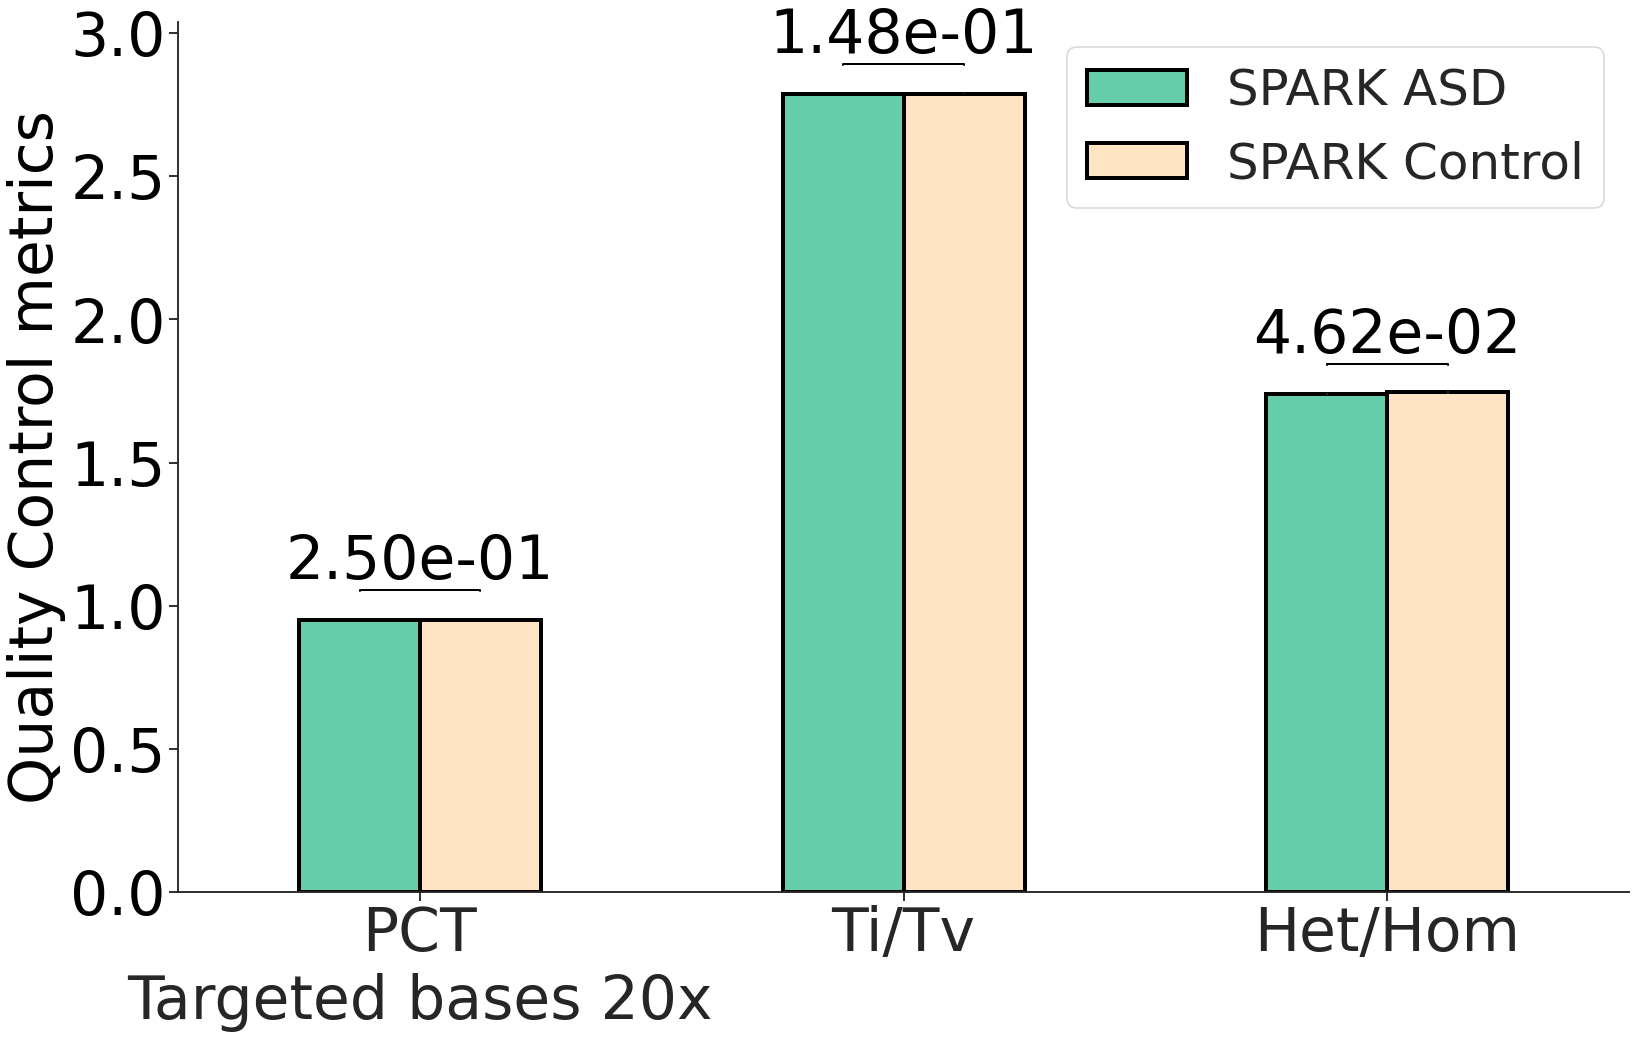

In [ ]:
# SPARK quality control metrics
def plot_pvals(ax, index, pval, text_buffer = 0, line_buffer = 0):
  # if pval > 0.05: return
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk =  "***"
  elif pval < 0.01: pval_asterisk =  "**"
  elif pval < 0.05: pval_asterisk =  "*"

  # Properties of the bar
  xy = ax.patches[index].xy
  x_start = xy[0]
  width = ax.patches[index].get_width()
  x_end = x_start + width
  height = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  ax.plot([midpoint, midpoint, midpoint + width, midpoint + width], [height + line_buffer, height + 0.005 + line_buffer, height + 0.005 + line_buffer, height + line_buffer], linewidth = 2, color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE, color = "black")


def make_df(df, col, cohort = "SPARK"):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["Cohort", "QC_Metric", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])
  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["QC_Metric", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])

# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]

# Get SPARK DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['dnLoF_Iossifov'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['dnMis_Iossifov'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['dnSyn_Iossifov'] = df_dnms_merge['syn_count'].fillna(value = 0)

# We're only looking at SPARK DNMs for this part of the analysis
df_spark_dnms = df_dnms_merge[df_dnms_merge["Cohort"] == "SPARK"]

# Get quality control metrics for SPARK
df_spark_info = pd.read_csv("df.spark_info.csv")
df_spark_info['Sex'] = df_spark_info['Sex'].replace({1: 0, 2: 1})
df_spark_info['Phenotype'] = df_spark_info['Phenotype'].replace({1: 0, 2: 1})

# Merge df_spark_info (quality control metrics) with the merged dataframe
df_spark_dnms_info = df_spark_dnms.merge(df_spark_info, on = ["IID", "FID", "Phenotype", "Sex"])

# Get parental ages
df_mp = pd.read_csv("/content/master_phen_4.SBayesR.csv", sep=",")
df_mp = df_mp[["fid", "iid", "phen", "sex", "cohort", "father.age.at.birth.z", "mother.age.at.birth.z"]]
df_mp = df_mp.rename(columns = {"fid": "FID", "iid": "IID", "phen": "Phenotype", "sex": "Sex", "cohort": "Cohort"})
df_mp['Sex'] = df_mp['Sex'].replace({"Male": 0, "Female": 1})
df_mp['Phenotype'] = df_mp['Phenotype'].replace({"CON": 0, "ASD": 1})
df_mp['Cohort'] = df_mp['Cohort'].replace({1: "REACH", 2: "SSC", 3: "SPARK"})

# Merge df_mp (containing parental ages at birth of child) with merged dataframe
df_spark_dnms_info = df_spark_dnms_info.merge(df_mp, on = ["IID", "FID", "Phenotype", "Cohort"])

# Make dataframes for each of the quality control metrics
df_spark_pct = make_df(df_spark_dnms_info, col = "PCT_Targeted_bases_20x")
df_spark_ti_tv = make_df(df_spark_dnms_info, col = "ti_tv")
df_spark_het_hom_ratio = make_df(df_spark_dnms_info, col = "het_hom_ratio")
df_spark_father_age_at_birth = make_df(df_spark_dnms_info, col = "father.age.at.birth.z")

# Concatenate the quality control metric dataframes
df_spark_qc = pd.concat([df_spark_pct, df_spark_ti_tv, df_spark_het_hom_ratio])

# Plotting
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_spark_qc.plot.bar(
    x = "QC_Metric",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_spark_qc[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    ax = ax
)

leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('Quality Control metrics', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_spark_qc_labels = ["PCT\nTargeted bases 20x", "Ti/Tv", "Het/Hom"]
ax.set_xticklabels(df_spark_qc_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_spark_qc["P-value"].values[0], line_buffer = 0.10, text_buffer = 0.20)
plot_pvals(ax, index = 1, pval = df_spark_qc["P-value"].values[1], line_buffer = 0.10, text_buffer = 0.20)
plot_pvals(ax, index = 2, pval = df_spark_qc["P-value"].values[2], line_buffer = 0.10, text_buffer = 0.20)


f.savefig("rebuttal.spark.qc.png", bbox_inches = "tight")
f.savefig("rebuttal.spark.qc.svg", bbox_inches = "tight")
f.savefig("rebuttal.spark.qc.pdf", bbox_inches = "tight")


In [ ]:
# Correlate dnSyn and Het/Hom
scipy.stats.pearsonr(df_spark_dnms_info['dnSyn_Iossifov'], df_spark_dnms_info['het_hom_ratio'])

(-0.010860566115926382, 0.2869242816537576)

In [ ]:
# Supplementary table 6 (Figure 4B genetic correlation results)
df = pd.read_csv("/content/asd_genetic_correlations_by_sex_final.SBayesR.20210715.tsv", sep = "\t")
df = df.rename(columns = {"y": "Y",
                          "x": "X",
                          "male_est": "Male Estimate",
                          "male_pval": "Male P-value",
                          "male_r2": "Male r2",
                          "male_cor": "Male Correlation",
                          "female_est": "Female Estimate",
                          "female_pval": "Female P-value",
                          "female_r2": "Female r2",
                          "female_cor": "Female Correlation",
                          "combined_est": "Combined Estimate",
                          "combined_pval": "Combined P-value",
                          "combined_r2": "Combined r2",
                          "combined_cor": "Combined Correlation",
                          "sex_interaction_pval": "Gene by Sex Interaction P-value"}
               )
# Filter df for only statistically significant results
df_filtered = df[(df["Male P-value"] <= 0.05) | (df["Female P-value"] <= 0.05) | (df["Combined P-value"] <= 0.05) | (df["Gene by Sex Interaction P-value"] <= 0.05)]

df.to_csv("SupplementaryTable6.full.csv", index = False)
df_filtered.to_csv("SupplementaryTable6.statsig.csv", index = False)


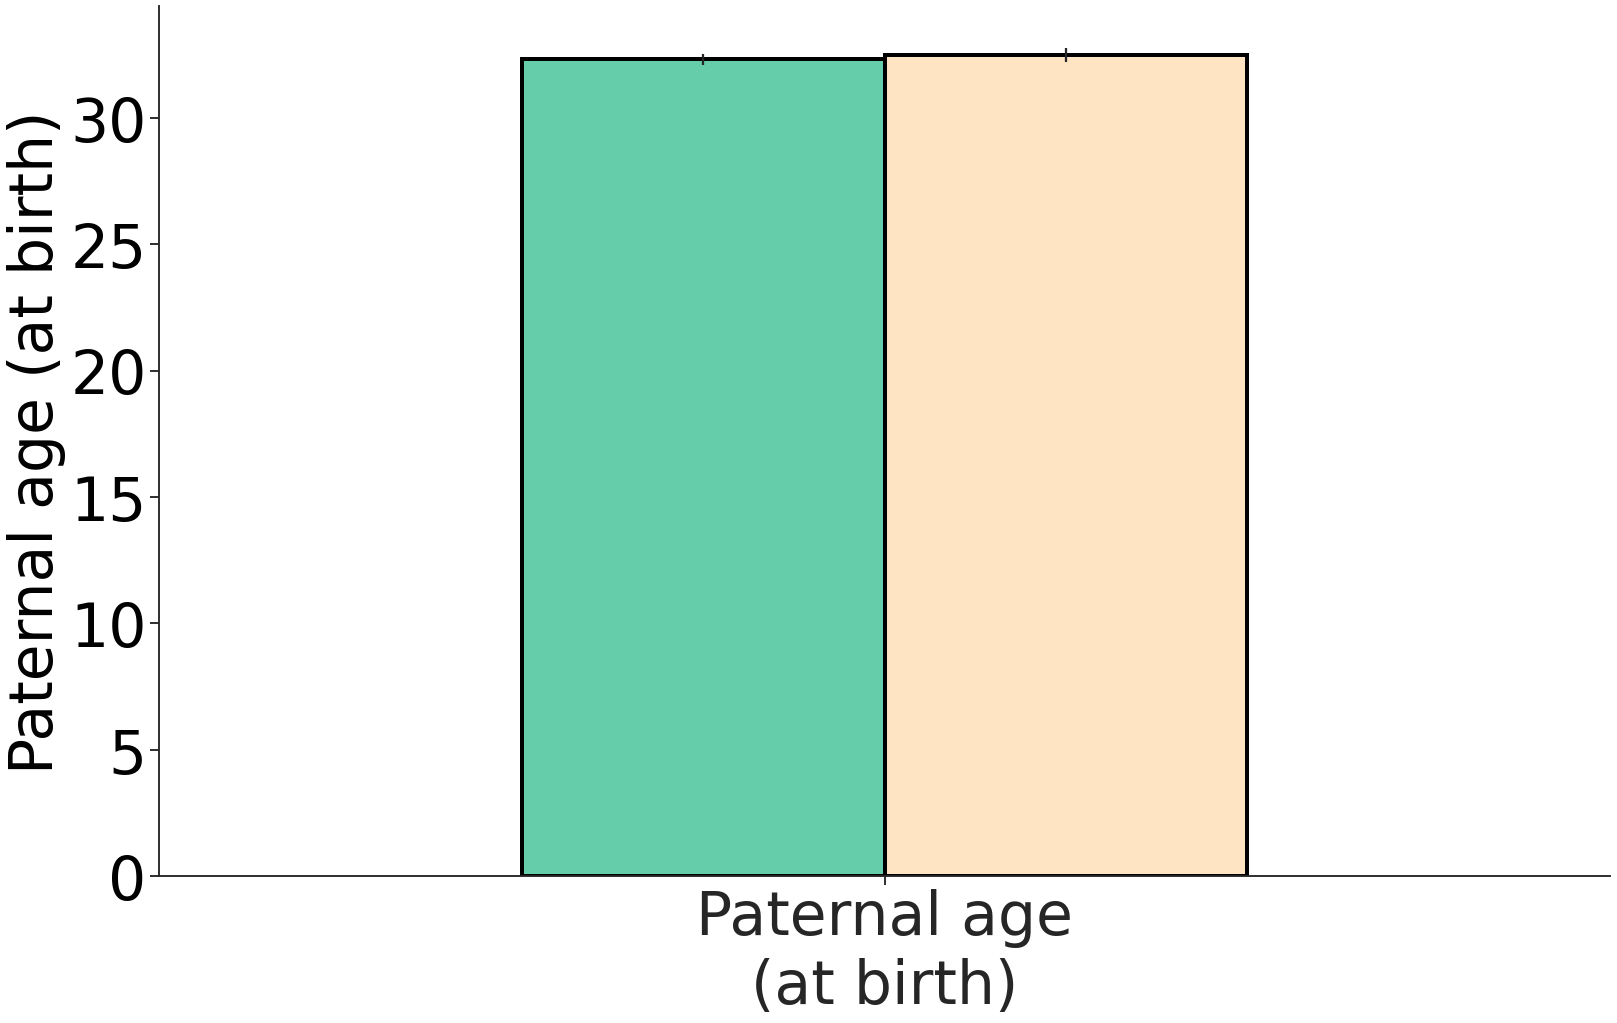

In [ ]:
def make_df(df, col, cohort = "SPARK"):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0])
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0])

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]
  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, ctl_mean, ctl_ci, p_val]], columns = ["Cohort", "QC_Metric", "ASD Mean", "ASD 95% CI", "Control Mean", "Control 95% CI", "P-value"])

  return pd.DataFrame([[col, cas_mean, cas_ci, ctl_mean, ctl_ci, p_val]], columns = ["QC_Metric", "ASD Mean", "ASD 95% CI", "Control Mean", "Control 95% CI", "P-value"])



# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]
# Exclude the hypermutators
df = df[~df["IID"].isin(exclude_iids)]

# Get DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)

# Get parental ages
df_pa = pd.read_csv("/content/parental_ages_reach_ssc_spark.csv")
df_pa = df_pa[["IID", "Father_IID", "Mother_IID", "FATHER_AGE", "MOTHER_AGE", "cohort"]]
df_pa = df_pa.rename(columns = {"cohort": "Cohort"})

# Merge
df_dnms_merge = df_dnms_merge.merge(df_pa, on = ["IID", "Cohort"])

# Split by cohort
df_dnms_reach = df_dnms_merge[df_dnms_merge["Cohort"] == "REACH"]
df_dnms_spark = df_dnms_merge[df_dnms_merge["Cohort"] == "SPARK"]
df_dnms_ssc   = df_dnms_merge[df_dnms_merge["Cohort"] == "SSC"]

# Make dataframes for fathers' ages
df_reach_father_age_at_birth = make_df(df_dnms_reach, col = "FATHER_AGE", cohort = "REACH")
df_spark_father_age_at_birth = make_df(df_dnms_spark, col = "FATHER_AGE", cohort = "SPARK")
df_ssc_father_age_at_birth   = make_df(df_dnms_ssc,   col = "FATHER_AGE", cohort = "SSC")


# Plotting
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_spark_father_age_at_birth.plot.bar(
    x = "QC_Metric",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_spark_father_age_at_birth[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    legend = None,
    ax = ax
)

ax.set_ylabel('Paternal age (at birth)', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_spark_father_age_at_birth_labels = ["Paternal age\n(at birth)"]
ax.set_xticklabels(df_spark_father_age_at_birth_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

f.savefig("rebuttal.spark.paternal_age.png", bbox_inches = "tight")
f.savefig("rebuttal.spark.paternal_age.svg", bbox_inches = "tight")
f.savefig("rebuttal.spark.paternal_age.pdf", bbox_inches = "tight")

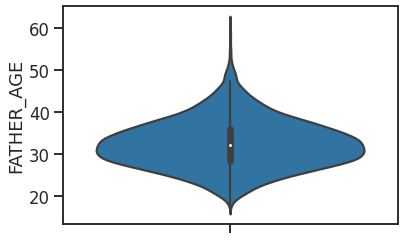

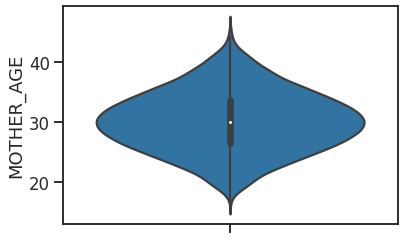

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

df_dnms_spark[["FID", "IID", "FATHER_AGE", "MOTHER_AGE"]]

f, ax = plt.subplots(1, 1)
ax = sns.violinplot(y = "FATHER_AGE", data = df_dnms_spark)
f, ax = plt.subplots(1, 1)
ax = sns.violinplot(y = "MOTHER_AGE", data = df_dnms_spark)

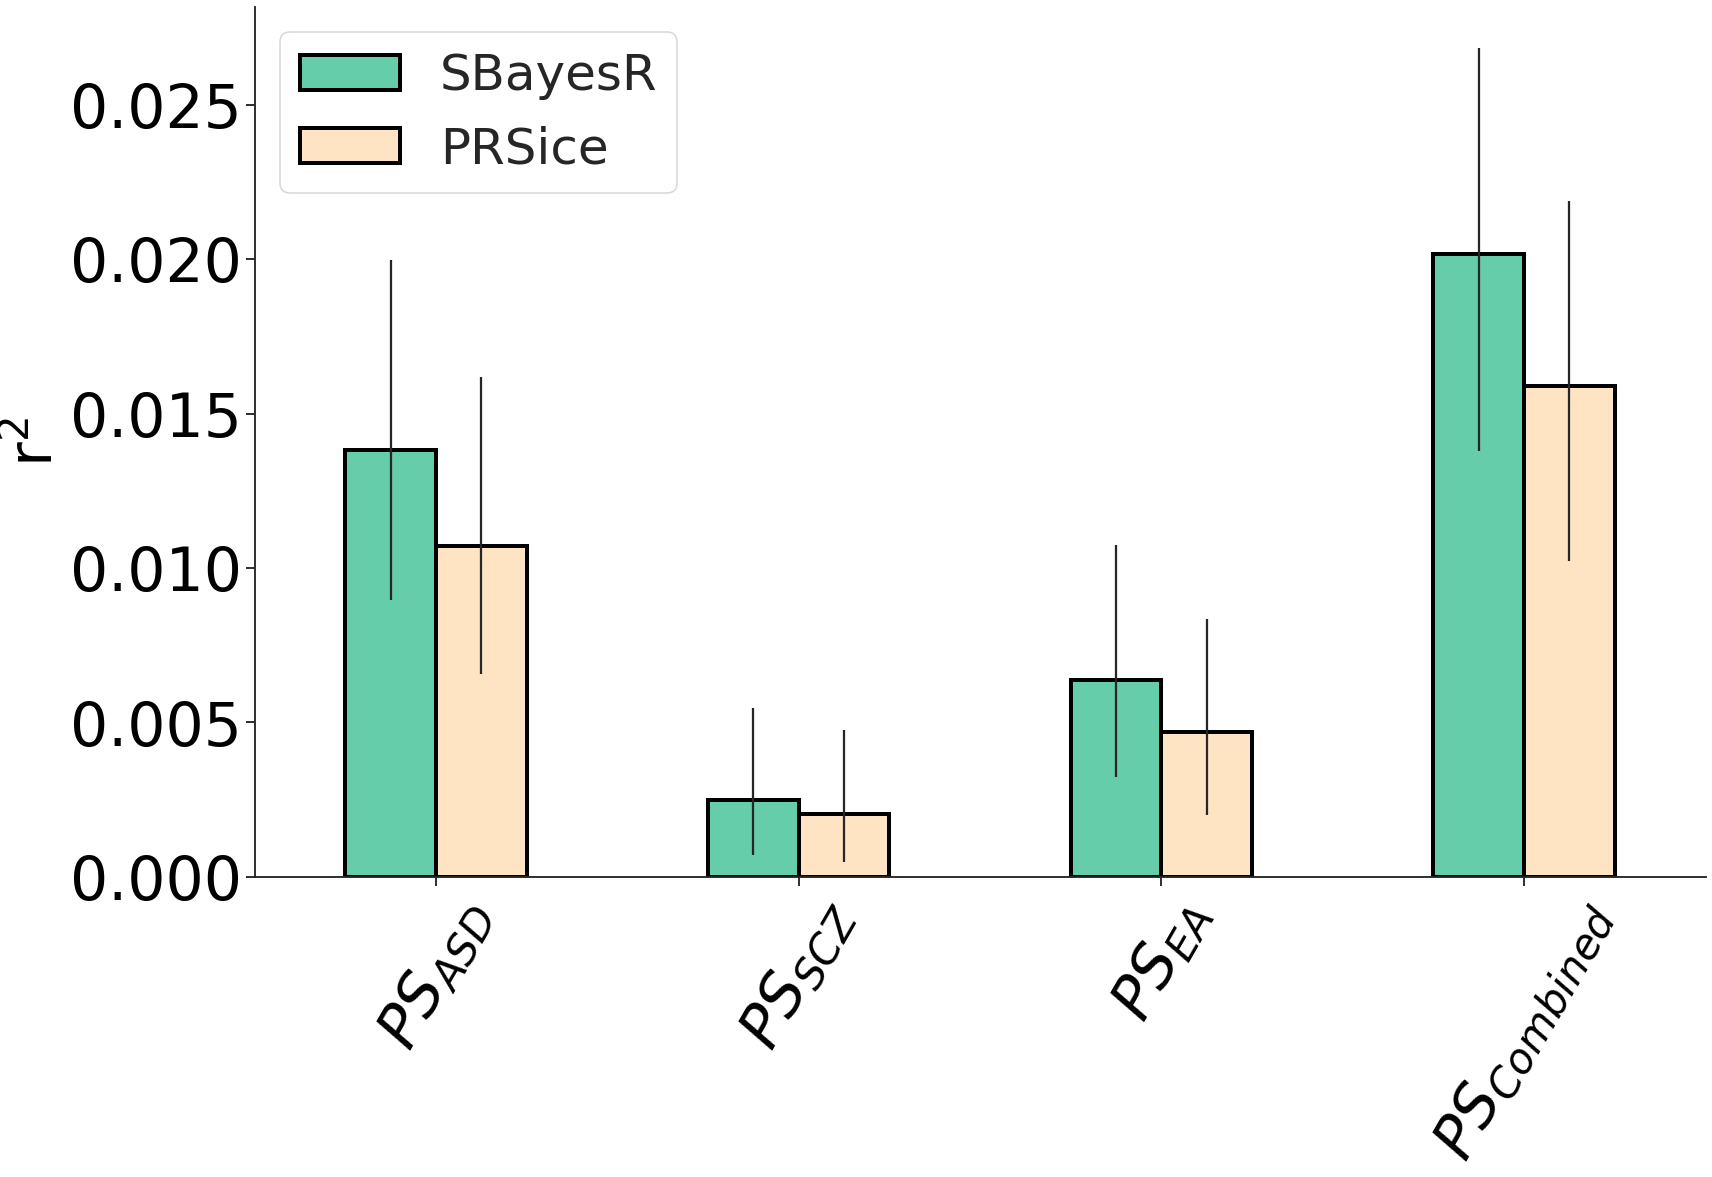

In [ ]:
# Figure 2A Supplement PRSice vs. SBayesR
# SBayesR
""" Analysis """
df = pd.read_csv("/content/r2_table.csv", sep = ",")
# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand = True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})
# To get the error bars, Danny uses the upper confidence interval value (shortcut?)
df['ci'] = df['ci_upper'] - df['nagelkerke_R2_val']
df["ci_lower_adj"] = df["nagelkerke_R2_val"] - df["ci_lower"]
df["ci_upper_adj"] = df["ci_upper"] - df["nagelkerke_R2_val"]
df = df[df["Sex"] == "Female & Male"].reset_index(drop = True)
df = df.reindex([1, 0, 3, 8, 5, 7, 6, 4, 2]).reset_index(drop = True)

df["Model"] = "SBayesR"
df_sbr = df

prs_categories = ["ptdt.asd.dev", "ptdt.scz.dev", "ptdt.ea.dev", "prs"]
df_sbr = df_sbr[df_sbr["R2_type"].isin(prs_categories)].reset_index(drop = True)

ci_lower_upper_sbr = df_sbr[['ci_lower_adj', 'ci_upper_adj']].apply(tuple, axis = 1).tolist()
ci_lower_upper_sbr = np.array(ci_lower_upper_sbr).T.tolist()


# PRSice
""" Analysis """
df = pd.read_csv("/content/r2_table.prsice.csv", sep = ",")
# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand = True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})
# To get the error bars, Danny uses the upper confidence interval value (shortcut?)
df['ci'] = df['ci_upper'] - df['nagelkerke_R2_val']
df["ci_lower_adj"] = df["nagelkerke_R2_val"] - df["ci_lower"]
df["ci_upper_adj"] = df["ci_upper"] - df["nagelkerke_R2_val"]
df = df[df["Sex"] == "Female & Male"].reset_index(drop = True)
df = df.reindex([1, 0, 3, 8, 5, 7, 6, 4, 2]).reset_index(drop = True)

df["Model"] = "PRSice"
df_prsice = df

prs_categories = ["ptdt.asd.dev", "ptdt.scz.dev", "ptdt.ea.dev", "prs"]
df_prsice = df_prsice[df_prsice["R2_type"].isin(prs_categories)].reset_index(drop = True)

ci_lower_upper_prsice = df_prsice[['ci_lower_adj', 'ci_upper_adj']].apply(tuple, axis = 1).tolist()
ci_lower_upper_prsice = np.array(ci_lower_upper_prsice).T.tolist()


# Combine asymmetric confidence intervals (error bars)
ci_lower_upper_sbr    = np.array(ci_lower_upper_sbr)
ci_lower_upper_prsice = np.array(ci_lower_upper_prsice)
ci_lower_upper_both = np.zeros([2, 2, 4])
ci_lower_upper_both[0,:,:] = ci_lower_upper_sbr
ci_lower_upper_both[1,:,:] = ci_lower_upper_prsice

""" Plotting """
dfm = df_sbr.merge(df_prsice, how = "left", on = ["text", "R2_type", "Sex"])

f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
dfm.plot.bar(
    x = "R2_type",
    y = ["nagelkerke_R2_val_x", "nagelkerke_R2_val_y"],
    yerr = ci_lower_upper_both,
    label = ["SBayesR", "PRSice"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE - 10)

ax.set_ylabel('r$^2$', fontsize = MASSIVE, color = "black")
ax.set_xlabel('')
xlabs = [
    '$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$',
    '$PS_{Combined}$'
]
ax.set_xticklabels(xlabs, rotation = 60)

plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

f.savefig("r2.sbayes_vs_prsice.png", bbox_inches = "tight")
f.savefig("r2.sbayes_vs_prsice.svg", bbox_inches = "tight")
f.savefig("r2.sbayes_vs_prsice.pdf", bbox_inches = "tight")

Misc

In [ ]:
# Environment information (just in case things change..)

# !python --version
# Python 3.7.11

# !pip list -v
# Package                       Version        Location                               Installer
# ----------------------------- -------------- -------------------------------------- ---------
# absl-py                       0.12.0         /usr/local/lib/python3.7/dist-packages pip
# alabaster                     0.7.12         /usr/local/lib/python3.7/dist-packages pip
# albumentations                0.1.12         /usr/local/lib/python3.7/dist-packages pip
# altair                        4.1.0          /usr/local/lib/python3.7/dist-packages pip
# appdirs                       1.4.4          /usr/local/lib/python3.7/dist-packages pip
# argcomplete                   1.12.3         /usr/local/lib/python3.7/dist-packages pip
# argon2-cffi                   20.1.0         /usr/local/lib/python3.7/dist-packages pip
# arviz                         0.11.2         /usr/local/lib/python3.7/dist-packages pip
# astor                         0.8.1          /usr/local/lib/python3.7/dist-packages pip
# astropy                       4.3.1          /usr/local/lib/python3.7/dist-packages pip
# astunparse                    1.6.3          /usr/local/lib/python3.7/dist-packages pip
# atari-py                      0.2.9          /usr/local/lib/python3.7/dist-packages pip
# atomicwrites                  1.4.0          /usr/local/lib/python3.7/dist-packages pip
# attrs                         21.2.0         /usr/local/lib/python3.7/dist-packages pip
# audioread                     2.1.9          /usr/local/lib/python3.7/dist-packages pip
# autograd                      1.3            /usr/local/lib/python3.7/dist-packages pip
# Babel                         2.9.1          /usr/local/lib/python3.7/dist-packages pip
# backcall                      0.2.0          /usr/local/lib/python3.7/dist-packages pip
# beautifulsoup4                4.6.3          /usr/local/lib/python3.7/dist-packages pip
# bleach                        4.0.0          /usr/local/lib/python3.7/dist-packages pip
# blis                          0.4.1          /usr/local/lib/python3.7/dist-packages pip
# bokeh                         2.3.3          /usr/local/lib/python3.7/dist-packages pip
# Bottleneck                    1.3.2          /usr/local/lib/python3.7/dist-packages pip
# branca                        0.4.2          /usr/local/lib/python3.7/dist-packages pip
# bs4                           0.0.1          /usr/local/lib/python3.7/dist-packages pip
# CacheControl                  0.12.6         /usr/local/lib/python3.7/dist-packages pip
# cached-property               1.5.2          /usr/local/lib/python3.7/dist-packages pip
# cachetools                    4.2.2          /usr/local/lib/python3.7/dist-packages pip
# catalogue                     1.0.0          /usr/local/lib/python3.7/dist-packages pip
# certifi                       2021.5.30      /usr/local/lib/python3.7/dist-packages pip
# cffi                          1.14.6         /usr/local/lib/python3.7/dist-packages pip
# cftime                        1.5.0          /usr/local/lib/python3.7/dist-packages pip
# chardet                       3.0.4          /usr/local/lib/python3.7/dist-packages pip
# charset-normalizer            2.0.4          /usr/local/lib/python3.7/dist-packages pip
# clang                         5.0            /usr/local/lib/python3.7/dist-packages pip
# click                         7.1.2          /usr/local/lib/python3.7/dist-packages pip
# cloudpickle                   1.3.0          /usr/local/lib/python3.7/dist-packages pip
# cmake                         3.12.0         /usr/local/lib/python3.7/dist-packages pip
# cmdstanpy                     0.9.5          /usr/local/lib/python3.7/dist-packages pip
# colorcet                      2.0.6          /usr/local/lib/python3.7/dist-packages pip
# colorlover                    0.3.0          /usr/local/lib/python3.7/dist-packages pip
# community                     1.0.0b1        /usr/local/lib/python3.7/dist-packages pip
# contextlib2                   0.5.5          /usr/local/lib/python3.7/dist-packages pip
# convertdate                   2.3.2          /usr/local/lib/python3.7/dist-packages pip
# coverage                      3.7.1          /usr/local/lib/python3.7/dist-packages pip
# coveralls                     0.5            /usr/local/lib/python3.7/dist-packages pip
# crcmod                        1.7            /usr/local/lib/python3.7/dist-packages pip
# cufflinks                     0.17.3         /usr/local/lib/python3.7/dist-packages pip
# cvxopt                        1.2.6          /usr/local/lib/python3.7/dist-packages pip
# cvxpy                         1.0.31         /usr/local/lib/python3.7/dist-packages pip
# cycler                        0.10.0         /usr/local/lib/python3.7/dist-packages pip
# cymem                         2.0.5          /usr/local/lib/python3.7/dist-packages pip
# Cython                        0.29.24        /usr/local/lib/python3.7/dist-packages pip
# daft                          0.0.4          /usr/local/lib/python3.7/dist-packages pip
# dask                          2.12.0         /usr/local/lib/python3.7/dist-packages pip
# datascience                   0.10.6         /usr/local/lib/python3.7/dist-packages pip
# debugpy                       1.0.0          /usr/local/lib/python3.7/dist-packages pip
# decorator                     4.4.2          /usr/local/lib/python3.7/dist-packages pip
# defusedxml                    0.7.1          /usr/local/lib/python3.7/dist-packages pip
# descartes                     1.1.0          /usr/local/lib/python3.7/dist-packages pip
# dill                          0.3.4          /usr/local/lib/python3.7/dist-packages pip
# distributed                   1.25.3         /usr/local/lib/python3.7/dist-packages pip
# dlib                          19.18.0        /usr/local/lib/python3.7/dist-packages pip
# dm-tree                       0.1.6          /usr/local/lib/python3.7/dist-packages pip
# docopt                        0.6.2          /usr/local/lib/python3.7/dist-packages pip
# docutils                      0.17.1         /usr/local/lib/python3.7/dist-packages pip
# dopamine-rl                   1.0.5          /usr/local/lib/python3.7/dist-packages pip
# earthengine-api               0.1.278        /usr/local/lib/python3.7/dist-packages pip
# easydict                      1.9            /usr/local/lib/python3.7/dist-packages pip
# ecos                          2.0.7.post1    /usr/local/lib/python3.7/dist-packages pip
# editdistance                  0.5.3          /usr/local/lib/python3.7/dist-packages pip
# en-core-web-sm                2.2.5          /usr/local/lib/python3.7/dist-packages pip
# entrypoints                   0.3            /usr/local/lib/python3.7/dist-packages pip
# ephem                         4.0.0.2        /usr/local/lib/python3.7/dist-packages pip
# et-xmlfile                    1.1.0          /usr/local/lib/python3.7/dist-packages pip
# fa2                           0.3.5          /usr/local/lib/python3.7/dist-packages pip
# fastai                        1.0.61         /usr/local/lib/python3.7/dist-packages pip
# fastdtw                       0.3.4          /usr/local/lib/python3.7/dist-packages pip
# fastprogress                  1.0.0          /usr/local/lib/python3.7/dist-packages pip
# fastrlock                     0.6            /usr/local/lib/python3.7/dist-packages pip
# fbprophet                     0.7.1          /usr/local/lib/python3.7/dist-packages
# feather-format                0.4.1          /usr/local/lib/python3.7/dist-packages pip
# filelock                      3.0.12         /usr/local/lib/python3.7/dist-packages pip
# firebase-admin                4.4.0          /usr/local/lib/python3.7/dist-packages pip
# fix-yahoo-finance             0.0.22         /usr/local/lib/python3.7/dist-packages pip
# Flask                         1.1.4          /usr/local/lib/python3.7/dist-packages pip
# flatbuffers                   1.12           /usr/local/lib/python3.7/dist-packages pip
# folium                        0.8.3          /usr/local/lib/python3.7/dist-packages pip
# future                        0.16.0         /usr/local/lib/python3.7/dist-packages pip
# gast                          0.4.0          /usr/local/lib/python3.7/dist-packages pip
# GDAL                          2.2.2          /usr/local/lib/python3.7/dist-packages pip
# gdown                         3.6.4          /usr/local/lib/python3.7/dist-packages pip
# gensim                        3.6.0          /usr/local/lib/python3.7/dist-packages pip
# geographiclib                 1.52           /usr/local/lib/python3.7/dist-packages pip
# geopy                         1.17.0         /usr/local/lib/python3.7/dist-packages pip
# gin-config                    0.4.0          /usr/local/lib/python3.7/dist-packages pip
# glob2                         0.7            /usr/local/lib/python3.7/dist-packages pip
# google                        2.0.3          /usr/local/lib/python3.7/dist-packages pip
# google-api-core               1.26.3         /usr/local/lib/python3.7/dist-packages pip
# google-api-python-client      1.12.8         /usr/local/lib/python3.7/dist-packages pip
# google-auth                   1.34.0         /usr/local/lib/python3.7/dist-packages pip
# google-auth-httplib2          0.0.4          /usr/local/lib/python3.7/dist-packages pip
# google-auth-oauthlib          0.4.5          /usr/local/lib/python3.7/dist-packages pip
# google-cloud-bigquery         1.21.0         /usr/local/lib/python3.7/dist-packages pip
# google-cloud-bigquery-storage 1.1.0          /usr/local/lib/python3.7/dist-packages pip
# google-cloud-core             1.0.3          /usr/local/lib/python3.7/dist-packages pip
# google-cloud-datastore        1.8.0          /usr/local/lib/python3.7/dist-packages pip
# google-cloud-firestore        1.7.0          /usr/local/lib/python3.7/dist-packages pip
# google-cloud-language         1.2.0          /usr/local/lib/python3.7/dist-packages pip
# google-cloud-storage          1.18.1         /usr/local/lib/python3.7/dist-packages pip
# google-cloud-translate        1.5.0          /usr/local/lib/python3.7/dist-packages pip
# google-colab                  1.0.0          /usr/local/lib/python3.7/dist-packages pip
# google-pasta                  0.2.0          /usr/local/lib/python3.7/dist-packages pip
# google-resumable-media        0.4.1          /usr/local/lib/python3.7/dist-packages pip
# googleapis-common-protos      1.53.0         /usr/local/lib/python3.7/dist-packages pip
# googledrivedownloader         0.4            /usr/local/lib/python3.7/dist-packages pip
# graphviz                      0.10.1         /usr/local/lib/python3.7/dist-packages pip
# greenlet                      1.1.1          /usr/local/lib/python3.7/dist-packages pip
# grpcio                        1.39.0         /usr/local/lib/python3.7/dist-packages pip
# gspread                       3.0.1          /usr/local/lib/python3.7/dist-packages pip
# gspread-dataframe             3.0.8          /usr/local/lib/python3.7/dist-packages pip
# gym                           0.17.3         /usr/local/lib/python3.7/dist-packages pip
# h5py                          3.1.0          /usr/local/lib/python3.7/dist-packages pip
# HeapDict                      1.0.1          /usr/local/lib/python3.7/dist-packages pip
# hijri-converter               2.1.3          /usr/local/lib/python3.7/dist-packages pip
# holidays                      0.10.5.2       /usr/local/lib/python3.7/dist-packages pip
# holoviews                     1.14.5         /usr/local/lib/python3.7/dist-packages pip
# html5lib                      1.0.1          /usr/local/lib/python3.7/dist-packages pip
# httpimport                    0.5.18         /usr/local/lib/python3.7/dist-packages pip
# httplib2                      0.17.4         /usr/local/lib/python3.7/dist-packages pip
# httplib2shim                  0.0.3          /usr/local/lib/python3.7/dist-packages pip
# humanize                      0.5.1          /usr/local/lib/python3.7/dist-packages pip
# hyperopt                      0.1.2          /usr/local/lib/python3.7/dist-packages pip
# ideep4py                      2.0.0.post3    /usr/local/lib/python3.7/dist-packages pip
# idna                          2.10           /usr/local/lib/python3.7/dist-packages pip
# imageio                       2.4.1          /usr/local/lib/python3.7/dist-packages pip
# imagesize                     1.2.0          /usr/local/lib/python3.7/dist-packages pip
# imbalanced-learn              0.4.3          /usr/local/lib/python3.7/dist-packages pip
# imblearn                      0.0            /usr/local/lib/python3.7/dist-packages pip
# imgaug                        0.2.9          /usr/local/lib/python3.7/dist-packages pip
# importlib-metadata            4.6.4          /usr/local/lib/python3.7/dist-packages pip
# importlib-resources           5.2.2          /usr/local/lib/python3.7/dist-packages pip
# imutils                       0.5.4          /usr/local/lib/python3.7/dist-packages pip
# inflect                       2.1.0          /usr/local/lib/python3.7/dist-packages pip
# iniconfig                     1.1.1          /usr/local/lib/python3.7/dist-packages pip
# intel-openmp                  2021.3.0       /usr/local/lib/python3.7/dist-packages pip
# intervaltree                  2.1.0          /usr/local/lib/python3.7/dist-packages pip
# ipykernel                     4.10.1         /usr/local/lib/python3.7/dist-packages pip
# ipython                       5.5.0          /usr/local/lib/python3.7/dist-packages pip
# ipython-genutils              0.2.0          /usr/local/lib/python3.7/dist-packages pip
# ipython-sql                   0.3.9          /usr/local/lib/python3.7/dist-packages pip
# ipywidgets                    7.6.3          /usr/local/lib/python3.7/dist-packages pip
# itsdangerous                  1.1.0          /usr/local/lib/python3.7/dist-packages pip
# jax                           0.2.19         /usr/local/lib/python3.7/dist-packages pip
# jaxlib                        0.1.70+cuda110 /usr/local/lib/python3.7/dist-packages pip
# jdcal                         1.4.1          /usr/local/lib/python3.7/dist-packages pip
# jedi                          0.18.0         /usr/local/lib/python3.7/dist-packages pip
# jieba                         0.42.1         /usr/local/lib/python3.7/dist-packages pip
# Jinja2                        2.11.3         /usr/local/lib/python3.7/dist-packages pip
# joblib                        1.0.1          /usr/local/lib/python3.7/dist-packages pip
# jpeg4py                       0.1.4          /usr/local/lib/python3.7/dist-packages pip
# jsonschema                    2.6.0          /usr/local/lib/python3.7/dist-packages pip
# jupyter                       1.0.0          /usr/local/lib/python3.7/dist-packages pip
# jupyter-client                5.3.5          /usr/local/lib/python3.7/dist-packages pip
# jupyter-console               5.2.0          /usr/local/lib/python3.7/dist-packages pip
# jupyter-core                  4.7.1          /usr/local/lib/python3.7/dist-packages pip
# jupyterlab-pygments           0.1.2          /usr/local/lib/python3.7/dist-packages pip
# jupyterlab-widgets            1.0.0          /usr/local/lib/python3.7/dist-packages pip
# kaggle                        1.5.12         /usr/local/lib/python3.7/dist-packages pip
# kapre                         0.3.5          /usr/local/lib/python3.7/dist-packages pip
# keras                         2.6.0          /usr/local/lib/python3.7/dist-packages pip
# Keras-Preprocessing           1.1.2          /usr/local/lib/python3.7/dist-packages pip
# keras-vis                     0.4.1          /usr/local/lib/python3.7/dist-packages pip
# kiwisolver                    1.3.1          /usr/local/lib/python3.7/dist-packages pip
# korean-lunar-calendar         0.2.1          /usr/local/lib/python3.7/dist-packages pip
# librosa                       0.8.1          /usr/local/lib/python3.7/dist-packages pip
# lightgbm                      2.2.3          /usr/local/lib/python3.7/dist-packages pip
# llvmlite                      0.34.0         /usr/local/lib/python3.7/dist-packages pip
# lmdb                          0.99           /usr/local/lib/python3.7/dist-packages pip
# LunarCalendar                 0.0.9          /usr/local/lib/python3.7/dist-packages pip
# lxml                          4.2.6          /usr/local/lib/python3.7/dist-packages pip
# Markdown                      3.3.4          /usr/local/lib/python3.7/dist-packages pip
# MarkupSafe                    2.0.1          /usr/local/lib/python3.7/dist-packages pip
# matplotlib                    3.2.2          /usr/local/lib/python3.7/dist-packages pip
# matplotlib-inline             0.1.2          /usr/local/lib/python3.7/dist-packages pip
# matplotlib-venn               0.11.6         /usr/local/lib/python3.7/dist-packages pip
# missingno                     0.5.0          /usr/local/lib/python3.7/dist-packages pip
# mistune                       0.8.4          /usr/local/lib/python3.7/dist-packages pip
# mizani                        0.6.0          /usr/local/lib/python3.7/dist-packages pip
# mkl                           2019.0         /usr/local/lib/python3.7/dist-packages pip
# mlxtend                       0.14.0         /usr/local/lib/python3.7/dist-packages pip
# more-itertools                8.8.0          /usr/local/lib/python3.7/dist-packages pip
# moviepy                       0.2.3.5        /usr/local/lib/python3.7/dist-packages pip
# mpmath                        1.2.1          /usr/local/lib/python3.7/dist-packages pip
# msgpack                       1.0.2          /usr/local/lib/python3.7/dist-packages pip
# multiprocess                  0.70.12.2      /usr/local/lib/python3.7/dist-packages pip
# multitasking                  0.0.9          /usr/local/lib/python3.7/dist-packages pip
# murmurhash                    1.0.5          /usr/local/lib/python3.7/dist-packages pip
# music21                       5.5.0          /usr/local/lib/python3.7/dist-packages pip
# natsort                       5.5.0          /usr/local/lib/python3.7/dist-packages pip
# nbclient                      0.5.4          /usr/local/lib/python3.7/dist-packages pip
# nbconvert                     5.6.1          /usr/local/lib/python3.7/dist-packages pip
# nbformat                      5.1.3          /usr/local/lib/python3.7/dist-packages pip
# nest-asyncio                  1.5.1          /usr/local/lib/python3.7/dist-packages pip
# netCDF4                       1.5.7          /usr/local/lib/python3.7/dist-packages pip
# networkx                      2.6.2          /usr/local/lib/python3.7/dist-packages pip
# nibabel                       3.0.2          /usr/local/lib/python3.7/dist-packages pip
# nltk                          3.2.5          /usr/local/lib/python3.7/dist-packages pip
# notebook                      5.3.1          /usr/local/lib/python3.7/dist-packages pip
# numba                         0.51.2         /usr/local/lib/python3.7/dist-packages pip
# numexpr                       2.7.3          /usr/local/lib/python3.7/dist-packages pip
# numpy                         1.19.5         /usr/local/lib/python3.7/dist-packages pip
# nvidia-ml-py3                 7.352.0        /usr/local/lib/python3.7/dist-packages pip
# oauth2client                  4.1.3          /usr/local/lib/python3.7/dist-packages pip
# oauthlib                      3.1.1          /usr/local/lib/python3.7/dist-packages pip
# okgrade                       0.4.3          /usr/local/lib/python3.7/dist-packages pip
# opencv-contrib-python         4.1.2.30       /usr/local/lib/python3.7/dist-packages pip
# opencv-python                 4.1.2.30       /usr/local/lib/python3.7/dist-packages pip
# openpyxl                      2.5.9          /usr/local/lib/python3.7/dist-packages pip
# opt-einsum                    3.3.0          /usr/local/lib/python3.7/dist-packages pip
# osqp                          0.6.2.post0    /usr/local/lib/python3.7/dist-packages pip
# packaging                     21.0           /usr/local/lib/python3.7/dist-packages pip
# palettable                    3.3.0          /usr/local/lib/python3.7/dist-packages pip
# pandas                        1.1.5          /usr/local/lib/python3.7/dist-packages pip
# pandas-datareader             0.9.0          /usr/local/lib/python3.7/dist-packages pip
# pandas-gbq                    0.13.3         /usr/local/lib/python3.7/dist-packages pip
# pandas-profiling              1.4.1          /usr/local/lib/python3.7/dist-packages pip
# pandocfilters                 1.4.3          /usr/local/lib/python3.7/dist-packages pip
# panel                         0.12.1         /usr/local/lib/python3.7/dist-packages pip
# param                         1.11.1         /usr/local/lib/python3.7/dist-packages pip
# parso                         0.8.2          /usr/local/lib/python3.7/dist-packages pip
# pathlib                       1.0.1          /usr/local/lib/python3.7/dist-packages pip
# patsy                         0.5.1          /usr/local/lib/python3.7/dist-packages pip
# pep517                        0.11.0         /usr/local/lib/python3.7/dist-packages pip
# pexpect                       4.8.0          /usr/local/lib/python3.7/dist-packages pip
# pickleshare                   0.7.5          /usr/local/lib/python3.7/dist-packages pip
# Pillow                        7.1.2          /usr/local/lib/python3.7/dist-packages pip
# pip                           21.1.3         /usr/local/lib/python3.7/dist-packages pip
# pip-tools                     6.2.0          /usr/local/lib/python3.7/dist-packages pip
# plac                          1.1.3          /usr/local/lib/python3.7/dist-packages pip
# plotly                        4.4.1          /usr/local/lib/python3.7/dist-packages pip
# plotnine                      0.6.0          /usr/local/lib/python3.7/dist-packages pip
# pluggy                        0.7.1          /usr/local/lib/python3.7/dist-packages pip
# pooch                         1.4.0          /usr/local/lib/python3.7/dist-packages pip
# portpicker                    1.3.9          /usr/local/lib/python3.7/dist-packages pip
# prefetch-generator            1.0.1          /usr/local/lib/python3.7/dist-packages pip
# preshed                       3.0.5          /usr/local/lib/python3.7/dist-packages pip
# prettytable                   2.1.0          /usr/local/lib/python3.7/dist-packages pip
# progressbar2                  3.38.0         /usr/local/lib/python3.7/dist-packages pip
# prometheus-client             0.11.0         /usr/local/lib/python3.7/dist-packages pip
# promise                       2.3            /usr/local/lib/python3.7/dist-packages pip
# prompt-toolkit                1.0.18         /usr/local/lib/python3.7/dist-packages pip
# protobuf                      3.17.3         /usr/local/lib/python3.7/dist-packages pip
# psutil                        5.4.8          /usr/local/lib/python3.7/dist-packages pip
# psycopg2                      2.7.6.1        /usr/local/lib/python3.7/dist-packages pip
# ptyprocess                    0.7.0          /usr/local/lib/python3.7/dist-packages pip
# py                            1.10.0         /usr/local/lib/python3.7/dist-packages pip
# pyarrow                       3.0.0          /usr/local/lib/python3.7/dist-packages pip
# pyasn1                        0.4.8          /usr/local/lib/python3.7/dist-packages pip
# pyasn1-modules                0.2.8          /usr/local/lib/python3.7/dist-packages pip
# pycocotools                   2.0.2          /usr/local/lib/python3.7/dist-packages pip
# pycparser                     2.20           /usr/local/lib/python3.7/dist-packages pip
# pyct                          0.4.8          /usr/local/lib/python3.7/dist-packages pip
# pydata-google-auth            1.2.0          /usr/local/lib/python3.7/dist-packages pip
# pydot                         1.3.0          /usr/local/lib/python3.7/dist-packages pip
# pydot-ng                      2.0.0          /usr/local/lib/python3.7/dist-packages pip
# pydotplus                     2.0.2          /usr/local/lib/python3.7/dist-packages pip
# PyDrive                       1.3.1          /usr/local/lib/python3.7/dist-packages pip
# pyemd                         0.5.1          /usr/local/lib/python3.7/dist-packages pip
# pyerfa                        2.0.0          /usr/local/lib/python3.7/dist-packages pip
# pyglet                        1.5.0          /usr/local/lib/python3.7/dist-packages pip
# Pygments                      2.6.1          /usr/local/lib/python3.7/dist-packages pip
# pygobject                     3.26.1         /usr/lib/python3/dist-packages
# pymc3                         3.11.2         /usr/local/lib/python3.7/dist-packages pip
# PyMeeus                       0.5.11         /usr/local/lib/python3.7/dist-packages pip
# pymongo                       3.12.0         /usr/local/lib/python3.7/dist-packages pip
# pymystem3                     0.2.0          /usr/local/lib/python3.7/dist-packages pip
# PyOpenGL                      3.1.5          /usr/local/lib/python3.7/dist-packages pip
# pyparsing                     2.4.7          /usr/local/lib/python3.7/dist-packages pip
# pyrsistent                    0.18.0         /usr/local/lib/python3.7/dist-packages pip
# pysndfile                     1.3.8          /usr/local/lib/python3.7/dist-packages pip
# PySocks                       1.7.1          /usr/local/lib/python3.7/dist-packages pip
# pystan                        2.19.1.1       /usr/local/lib/python3.7/dist-packages pip
# pytest                        3.6.4          /usr/local/lib/python3.7/dist-packages pip
# python-apt                    0.0.0          /usr/local/lib/python3.7/dist-packages
# python-chess                  0.23.11        /usr/local/lib/python3.7/dist-packages pip
# python-dateutil               2.8.2          /usr/local/lib/python3.7/dist-packages pip
# python-louvain                0.15           /usr/local/lib/python3.7/dist-packages pip
# python-slugify                5.0.2          /usr/local/lib/python3.7/dist-packages pip
# python-utils                  2.5.6          /usr/local/lib/python3.7/dist-packages pip
# pytz                          2018.9         /usr/local/lib/python3.7/dist-packages pip
# pyviz-comms                   2.1.0          /usr/local/lib/python3.7/dist-packages pip
# PyWavelets                    1.1.1          /usr/local/lib/python3.7/dist-packages pip
# PyYAML                        3.13           /usr/local/lib/python3.7/dist-packages pip
# pyzmq                         22.2.1         /usr/local/lib/python3.7/dist-packages pip
# qdldl                         0.1.5.post0    /usr/local/lib/python3.7/dist-packages pip
# qtconsole                     5.1.1          /usr/local/lib/python3.7/dist-packages pip
# QtPy                          1.10.0         /usr/local/lib/python3.7/dist-packages pip
# regex                         2019.12.20     /usr/local/lib/python3.7/dist-packages pip
# requests                      2.23.0         /usr/local/lib/python3.7/dist-packages pip
# requests-oauthlib             1.3.0          /usr/local/lib/python3.7/dist-packages pip
# resampy                       0.2.2          /usr/local/lib/python3.7/dist-packages pip
# retrying                      1.3.3          /usr/local/lib/python3.7/dist-packages pip
# rpy2                          3.4.5          /usr/local/lib/python3.7/dist-packages pip
# rsa                           4.7.2          /usr/local/lib/python3.7/dist-packages pip
# scikit-image                  0.16.2         /usr/local/lib/python3.7/dist-packages pip
# scikit-learn                  0.22.2.post1   /usr/local/lib/python3.7/dist-packages pip
# scipy                         1.4.1          /usr/local/lib/python3.7/dist-packages pip
# screen-resolution-extra       0.0.0          /usr/lib/python3/dist-packages
# scs                           2.1.4          /usr/local/lib/python3.7/dist-packages pip
# seaborn                       0.11.1         /usr/local/lib/python3.7/dist-packages pip
# semver                        2.13.0         /usr/local/lib/python3.7/dist-packages pip
# Send2Trash                    1.8.0          /usr/local/lib/python3.7/dist-packages pip
# setuptools                    57.4.0         /usr/local/lib/python3.7/dist-packages pip
# setuptools-git                1.2            /usr/local/lib/python3.7/dist-packages pip
# Shapely                       1.7.1          /usr/local/lib/python3.7/dist-packages pip
# simplegeneric                 0.8.1          /usr/local/lib/python3.7/dist-packages pip
# six                           1.15.0         /usr/local/lib/python3.7/dist-packages pip
# sklearn                       0.0            /usr/local/lib/python3.7/dist-packages pip
# sklearn-pandas                1.8.0          /usr/local/lib/python3.7/dist-packages pip
# smart-open                    5.1.0          /usr/local/lib/python3.7/dist-packages pip
# snowballstemmer               2.1.0          /usr/local/lib/python3.7/dist-packages pip
# sortedcontainers              2.4.0          /usr/local/lib/python3.7/dist-packages pip
# SoundFile                     0.10.3.post1   /usr/local/lib/python3.7/dist-packages pip
# spacy                         2.2.4          /usr/local/lib/python3.7/dist-packages pip
# Sphinx                        1.8.5          /usr/local/lib/python3.7/dist-packages pip
# sphinxcontrib-serializinghtml 1.1.5          /usr/local/lib/python3.7/dist-packages pip
# sphinxcontrib-websupport      1.2.4          /usr/local/lib/python3.7/dist-packages pip
# SQLAlchemy                    1.4.22         /usr/local/lib/python3.7/dist-packages pip
# sqlparse                      0.4.1          /usr/local/lib/python3.7/dist-packages pip
# srsly                         1.0.5          /usr/local/lib/python3.7/dist-packages pip
# statsmodels                   0.10.2         /usr/local/lib/python3.7/dist-packages pip
# sympy                         1.7.1          /usr/local/lib/python3.7/dist-packages pip
# tables                        3.4.4          /usr/local/lib/python3.7/dist-packages pip
# tabulate                      0.8.9          /usr/local/lib/python3.7/dist-packages pip
# tblib                         1.7.0          /usr/local/lib/python3.7/dist-packages pip
# tensorboard                   2.6.0          /usr/local/lib/python3.7/dist-packages pip
# tensorboard-data-server       0.6.1          /usr/local/lib/python3.7/dist-packages pip
# tensorboard-plugin-wit        1.8.0          /usr/local/lib/python3.7/dist-packages pip
# tensorflow                    2.6.0          /usr/local/lib/python3.7/dist-packages pip
# tensorflow-datasets           4.0.1          /usr/local/lib/python3.7/dist-packages pip
# tensorflow-estimator          2.6.0          /usr/local/lib/python3.7/dist-packages pip
# tensorflow-gcs-config         2.6.0          /usr/local/lib/python3.7/dist-packages pip
# tensorflow-hub                0.12.0         /usr/local/lib/python3.7/dist-packages pip
# tensorflow-metadata           1.2.0          /usr/local/lib/python3.7/dist-packages pip
# tensorflow-probability        0.13.0         /usr/local/lib/python3.7/dist-packages pip
# termcolor                     1.1.0          /usr/local/lib/python3.7/dist-packages pip
# terminado                     0.11.0         /usr/local/lib/python3.7/dist-packages pip
# testpath                      0.5.0          /usr/local/lib/python3.7/dist-packages pip
# text-unidecode                1.3            /usr/local/lib/python3.7/dist-packages pip
# textblob                      0.15.3         /usr/local/lib/python3.7/dist-packages pip
# Theano-PyMC                   1.1.2          /usr/local/lib/python3.7/dist-packages pip
# thinc                         7.4.0          /usr/local/lib/python3.7/dist-packages pip
# tifffile                      2021.8.8       /usr/local/lib/python3.7/dist-packages pip
# toml                          0.10.2         /usr/local/lib/python3.7/dist-packages pip
# tomli                         1.2.1          /usr/local/lib/python3.7/dist-packages pip
# toolz                         0.11.1         /usr/local/lib/python3.7/dist-packages pip
# torch                         1.9.0+cu102    /usr/local/lib/python3.7/dist-packages pip
# torchsummary                  1.5.1          /usr/local/lib/python3.7/dist-packages pip
# torchtext                     0.10.0         /usr/local/lib/python3.7/dist-packages pip
# torchvision                   0.10.0+cu102   /usr/local/lib/python3.7/dist-packages pip
# tornado                       5.1.1          /usr/local/lib/python3.7/dist-packages pip
# tqdm                          4.62.0         /usr/local/lib/python3.7/dist-packages pip
# traitlets                     5.0.5          /usr/local/lib/python3.7/dist-packages pip
# tweepy                        3.10.0         /usr/local/lib/python3.7/dist-packages pip
# typeguard                     2.7.1          /usr/local/lib/python3.7/dist-packages pip
# typing-extensions             3.7.4.3        /usr/local/lib/python3.7/dist-packages pip
# tzlocal                       1.5.1          /usr/local/lib/python3.7/dist-packages pip
# uritemplate                   3.0.1          /usr/local/lib/python3.7/dist-packages pip
# urllib3                       1.24.3         /usr/local/lib/python3.7/dist-packages pip
# vega-datasets                 0.9.0          /usr/local/lib/python3.7/dist-packages pip
# wasabi                        0.8.2          /usr/local/lib/python3.7/dist-packages pip
# wcwidth                       0.2.5          /usr/local/lib/python3.7/dist-packages pip
# webencodings                  0.5.1          /usr/local/lib/python3.7/dist-packages pip
# Werkzeug                      1.0.1          /usr/local/lib/python3.7/dist-packages pip
# wheel                         0.37.0         /usr/local/lib/python3.7/dist-packages pip
# widgetsnbextension            3.5.1          /usr/local/lib/python3.7/dist-packages pip
# wordcloud                     1.5.0          /usr/local/lib/python3.7/dist-packages pip
# wrapt                         1.12.1         /usr/local/lib/python3.7/dist-packages pip
# xarray                        0.18.2         /usr/local/lib/python3.7/dist-packages pip
# xgboost                       0.90           /usr/local/lib/python3.7/dist-packages pip
# xkit                          0.0.0          /usr/lib/python3/dist-packages
# xlrd                          1.1.0          /usr/local/lib/python3.7/dist-packages pip
# xlwt                          1.3.0          /usr/local/lib/python3.7/dist-packages pip
# yellowbrick                   0.9.1          /usr/local/lib/python3.7/dist-packages pip
# zict                          2.0.0          /usr/local/lib/python3.7/dist-packages pip
# zipp                          3.5.0          /usr/local/lib/python3.7/dist-packages pip


# Mostly out of curiosity..

# !cat /proc/cpuinfo
# processor	: 0
# vendor_id	: GenuineIntel
# cpu family	: 6
# model		: 79
# model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
# stepping	: 0
# microcode	: 0x1
# cpu MHz		: 2200.192
# cache size	: 56320 KB
# physical id	: 0
# siblings	: 2
# core id		: 0
# cpu cores	: 1
# apicid		: 0
# initial apicid	: 0
# fpu		: yes
# fpu_exception	: yes
# cpuid level	: 13
# wp		: yes
# flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
# bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
# bogomips	: 4400.38
# clflush size	: 64
# cache_alignment	: 64
# address sizes	: 46 bits physical, 48 bits virtual
# power management:

# processor	: 1
# vendor_id	: GenuineIntel
# cpu family	: 6
# model		: 79
# model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
# stepping	: 0
# microcode	: 0x1
# cpu MHz		: 2200.192
# cache size	: 56320 KB
# physical id	: 0
# siblings	: 2
# core id		: 0
# cpu cores	: 1
# apicid		: 1
# initial apicid	: 1
# fpu		: yes
# fpu_exception	: yes
# cpuid level	: 13
# wp		: yes
# flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
# bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
# bogomips	: 4400.38
# clflush size	: 64
# cache_alignment	: 64
# address sizes	: 46 bits physical, 48 bits virtual
# power management:


# !cat /proc/meminfo
# MemTotal:       13302928 kB
# MemFree:        10534200 kB
# MemAvailable:   12523712 kB
# Buffers:          145904 kB
# Cached:          1969792 kB
# SwapCached:            0 kB
# Active:          1016696 kB
# Inactive:        1513976 kB
# Active(anon):     371668 kB
# Inactive(anon):      472 kB
# Active(file):     645028 kB
# Inactive(file):  1513504 kB
# Unevictable:           0 kB
# Mlocked:               0 kB
# SwapTotal:             0 kB
# SwapFree:              0 kB
# Dirty:               188 kB
# Writeback:             0 kB
# AnonPages:        414932 kB
# Mapped:           239008 kB
# Shmem:              1148 kB
# KReclaimable:     144912 kB
# Slab:             189152 kB
# SReclaimable:     144912 kB
# SUnreclaim:        44240 kB
# KernelStack:        4656 kB
# PageTables:         5572 kB
# NFS_Unstable:          0 kB
# Bounce:                0 kB
# WritebackTmp:          0 kB
# CommitLimit:     6651464 kB
# Committed_AS:    3091256 kB
# VmallocTotal:   34359738367 kB
# VmallocUsed:        7028 kB
# VmallocChunk:          0 kB
# Percpu:             1400 kB
# AnonHugePages:      2048 kB
# ShmemHugePages:        0 kB
# ShmemPmdMapped:        0 kB
# FileHugePages:         0 kB
# FilePmdMapped:         0 kB
# CmaTotal:              0 kB
# CmaFree:               0 kB
# HugePages_Total:       0
# HugePages_Free:        0
# HugePages_Rsvd:        0
# HugePages_Surp:        0
# Hugepagesize:       2048 kB
# Hugetlb:               0 kB
# DirectMap4k:       90944 kB
# DirectMap2M:     5148672 kB
# DirectMap1G:    10485760 kB


MemTotal:       13302928 kB
MemFree:        10534200 kB
MemAvailable:   12523712 kB
Buffers:          145904 kB
Cached:          1969792 kB
SwapCached:            0 kB
Active:          1016696 kB
Inactive:        1513976 kB
Active(anon):     371668 kB
Inactive(anon):      472 kB
Active(file):     645028 kB
Inactive(file):  1513504 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               188 kB
Writeback:             0 kB
AnonPages:        414932 kB
Mapped:           239008 kB
Shmem:              1148 kB
KReclaimable:     144912 kB
Slab:             189152 kB
SReclaimable:     144912 kB
SUnreclaim:        44240 kB
KernelStack:        4656 kB
PageTables:         5572 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651464 kB
Committed_AS:    3091256 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        7028 kB
VmallocChunk:          0 kB
Percpu:          